# 0. Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.io import ascii
from astropy.wcs import WCS
import os, glob

import photutils
from photutils.isophote import Ellipse, EllipseGeometry, build_ellipse_model

from astropy.nddata import Cutout2D
from astropy.stats import sigma_clipped_stats

plt.rcParams.update({'font.size': 25})
plt.rcParams.update({'font.weight': 'normal'})

plt.rcParams.update({'xtick.direction': 'in'})
plt.rcParams.update({'ytick.direction': 'in'})
plt.rcParams.update({'xtick.major.size': 10})
plt.rcParams.update({'xtick.minor.size': 6})
plt.rcParams.update({'ytick.major.size': 10})
plt.rcParams.update({'ytick.minor.size': 6})
plt.rcParams.update({'xtick.major.width': 1.6})
plt.rcParams.update({'xtick.minor.width': 1.6})
plt.rcParams.update({'ytick.major.width': 1.6})
plt.rcParams.update({'ytick.minor.width': 1.6})

plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'axes.linewidth': 1.6})
plt.rcParams.update({'axes.labelpad': 4})
plt.rcParams.update({'xtick.major.pad': 7})
plt.rcParams.update({'image.origin':'lower'})
%config InlineBackend.figure_format = 'retina'

from astropy import coordinates
from astropy.table import Table

class matching:
     #~ FWHM/2
    def __init__(self, coordr, coord, match_thres = 0.03):
        match_thresf = match_thres
        matchres = coordinates.match_coordinates_sky(coordr, coord,
                                            nthneighbor = 1, storekdtree = 'kdtree_sky')
        matchres = [matchres[0], matchres[1].arcsec, matchres[2].value]
        matchhead = ['idcatcoord', 'sep2d', 'dist3d']
        matcht = Table(rows = np.array(matchres).T, names = matchhead,
                       dtype = ('i8', 'f8', 'f8'))
        self.table = matcht
        self.indr = np.where(matcht['sep2d'] < match_thresf)[0]
        self.indt = np.array(matcht['idcatcoord'][np.where(matcht['sep2d'] < match_thresf)[0]])
        
    def catalogr(self, catr):
        return catr[self.indr]
        
    
    def catalogt(self, catt):
        return catt[self.indt]

# 1. Iterate on all images

## 1) PreProcess Param 

In [3]:
# origin data 
alignfits = np.sort(glob.glob('../img/align-image/*_aligned.fits'))
alignsegmfits = np.sort(glob.glob('../img/align-image/*_aligned_segm.fits'))
origfits = np.sort(glob.glob('../img/original-big-image/*_i2d.fits'))
filters = ['F115W', 'F150W', 'F200W']
origrefname = origfits[0]

# tag for filename
tag = "ellipse_1"

fittabs = [] # result table 
isolist = [] 

# making cutout data - target view 
cutouts = []
cutoutnames = []

segm_cutouts = []
segm_cutoutnames = []

cntr = (1996, 4137)
size = 100

calculate pixel scale

In [4]:
pixel_scale = []
for j in range(len(filters)):
    pixel_scale.append(np.sqrt(fits.getheader(origfits[j], ext=1)['PIXAR_A2']))

## 2)  Preview for Cutout (in reference-aligned image)

Check the Center of the Ellipse Geometry

In [5]:
cx_list, cy_list = [50.344, 50.344, 50.344], [50.329, 50.329, 50.329]
# Center의 위치는 앞에서 계산해서 X0 Y0를 fix_center=False로 얻은 값을 다시 대입해서 넣은 것 

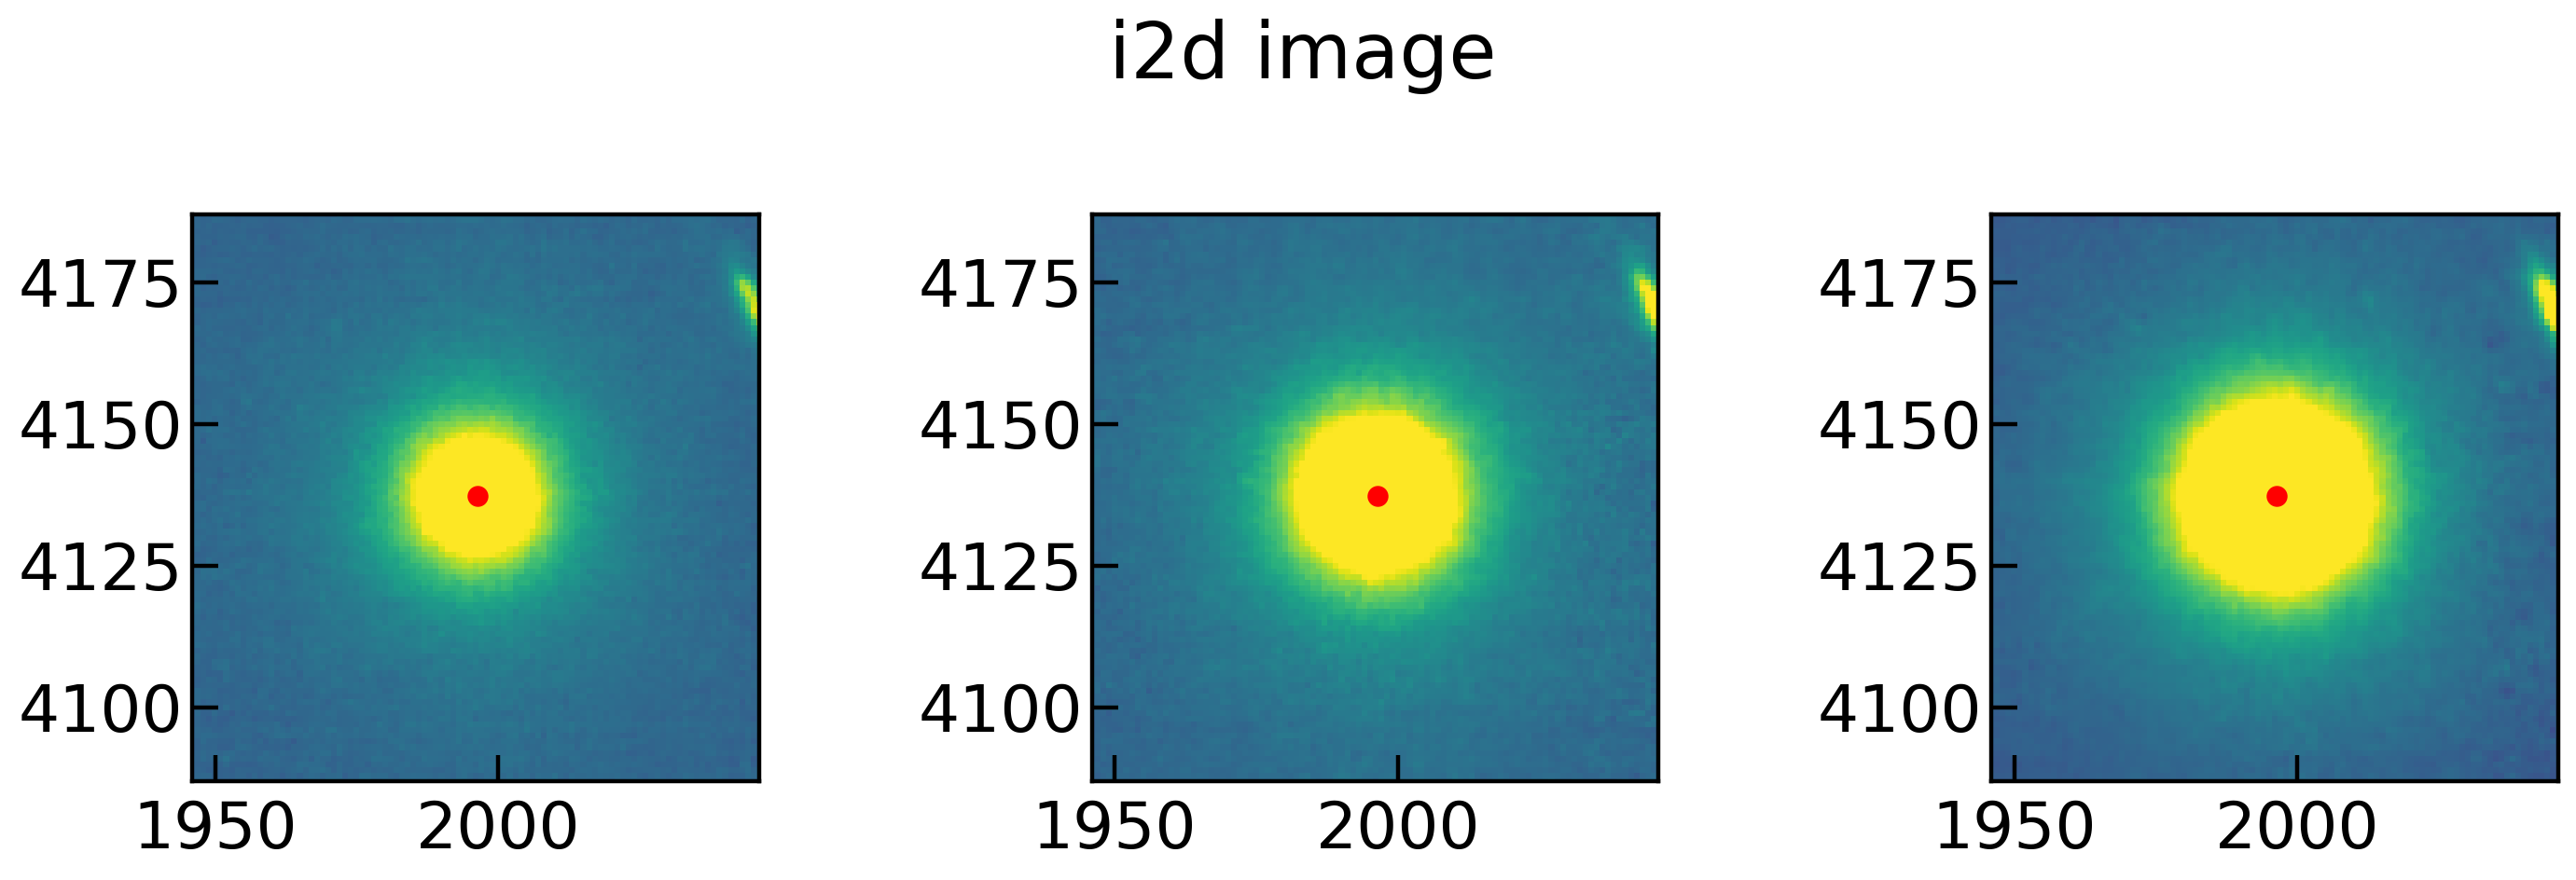

In [6]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
ZInterval = ZScaleInterval()
vmin, vmax = ZInterval.get_limits(fits.getdata(os.path.realpath(alignfits[0]), ext=1))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("i2d image")
ax[0].imshow(fits.getdata(os.path.realpath(alignfits[0]), ext=1), vmin=vmin, vmax=vmax, origin='lower')
ax[1].imshow(fits.getdata(os.path.realpath(alignfits[1]), ext=1), vmin=vmin, vmax=vmax, origin='lower')
ax[2].imshow(fits.getdata(os.path.realpath(alignfits[2]), ext=1), vmin=vmin, vmax=vmax, origin='lower')

ax[0].set_xlim(cntr[0]-size/2, cntr[0]+size/2)
ax[0].set_ylim(cntr[1]-size/2, cntr[1]+size/2)
ax[1].set_xlim(cntr[0]-size/2, cntr[0]+size/2)
ax[1].set_ylim(cntr[1]-size/2, cntr[1]+size/2)
ax[2].set_xlim(cntr[0]-size/2, cntr[0]+size/2)
ax[2].set_ylim(cntr[1]-size/2, cntr[1]+size/2)

ax[0].scatter(cx_list[0]+cntr[0]-size/2, cy_list[0]+cntr[1]-size/2, s=50, color='red')
ax[1].scatter(cx_list[1]+cntr[0]-size/2, cy_list[1]+cntr[1]-size/2, s=50, color='red')
ax[2].scatter(cx_list[2]+cntr[0]-size/2, cy_list[2]+cntr[1]-size/2, s=50, color='red')
plt.tight_layout()

''' segmap cutout view temporraily no use
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("segm image")
ax[0].imshow(fits.getdata(os.path.realpath(alignsegmfits[0]), ext=1))
ax[1].imshow(fits.getdata(os.path.realpath(alignsegmfits[1]), ext=1))
ax[2].imshow(fits.getdata(os.path.realpath(alignsegmfits[2]), ext=1))

ax[0].set_xlim(cntr[0]-size/2, cntr[0]+size/2)
ax[0].set_ylim(cntr[1]-size/2, cntr[1]+size/2)
ax[1].set_xlim(cntr[0]-size/2, cntr[0]+size/2)
ax[1].set_ylim(cntr[1]-size/2, cntr[1]+size/2)
ax[2].set_xlim(cntr[0]-size/2, cntr[0]+size/2)
ax[2].set_ylim(cntr[1]-size/2, cntr[1]+size/2)

ax[0].scatter(cx_list[0]+cntr[0]-size/2, cy_list[0]+cntr[1]-size/2, s=50, color='red')
ax[1].scatter(cx_list[1]+cntr[0]-size/2, cy_list[1]+cntr[1]-size/2, s=50, color='red')
ax[2].scatter(cx_list[2]+cntr[0]-size/2, cy_list[2]+cntr[1]-size/2, s=50, color='red')
''' 
plt.tight_layout()

## 3) Main Process + Save ouptut fits

In [7]:
#fitting
for ii in range(len(filters)):
    # Making cutout for i2d image
    print(f'making cutouts for {filters[ii]} image')
    fitsind = fits.open(alignfits[ii])
    wcsind = WCS(fits.open(origrefname)[1].header)
    
    dataind = fitsind[1].data
    cutind = Cutout2D(dataind, cntr, size, wcsind)

    primhdu = fits.PrimaryHDU()
    primhdu.header.update(fits.open(origfits[ii])[0].header)
    
    imhdu = fits.ImageHDU()
    imhdu.data = cutind.data
    imhdu.header.update(cutind.wcs.to_header())
    newhdu = fits.HDUList([primhdu, imhdu])
    cutoutname = '../img/cutout-image/Cutout_{}_{}.fits'.format(tag, filters[ii])
    newhdu.writeto(cutoutname, overwrite = True)

    cutouts.append(cutind)
    cutoutnames.append(cutoutname)
    
    print(f'Starting ellipse modeling for {filters[ii]} image')
    #Background estimation - using MMM relation
    fitsind = fits.open(cutoutnames[ii])
    dataind = fitsind[1].data 
    ''' 
    fig, ax = plt.subplots(figsize = (6, 4))
    ax.hist(dataind.flatten(), bins = np.arange(0, 1, 0.01))
    mean, median, stdev = sigma_clipped_stats(dataind)
    modeback = (3*median) - (2*mean)
    print('Background: {:.3g}'.format(modeback))
    ax.axvline(modeback, color = 'red')
    ax.axvline(median, color = 'orange')
    ax.set_title(f'{filters[ii]}')]
    '''
    
    #background-estimate : mean of fourside 
    height, width, bkgcut_size = dataind.shape[0], dataind.shape[1], 15
    top_left_mean = np.mean(dataind[0:bkgcut_size, height-bkgcut_size:height])
    top_right_mean = np.mean(dataind[width-bkgcut_size:width, height-bkgcut_size:height])
    bottom_left_mean = np.mean(dataind[0:bkgcut_size, 0:bkgcut_size])
    bottom_right_mean = np.mean(dataind[width-bkgcut_size:width, 0:bkgcut_size])
    bkg = np.mean([top_left_mean, top_right_mean, bottom_left_mean, bottom_right_mean])
    print('Background: {:.3g}'.format(bkg))
    
    #Ellipse fitting
    g = EllipseGeometry(x0=cx_list[ii], y0=cy_list[ii], sma=30, eps=0, pa=0)
    ellind = Ellipse(dataind-bkg, geometry=g)
    fitres = ellind.fit_image(sclip=3., nclip=3, fix_center=True)
    model_image = build_ellipse_model(dataind.shape, fitres)
    print(f'Building {filters[ii]} model is done!')
    datares = dataind - model_image

    fittab = fitres.to_table()
    # make a new column sma in arcsec unit
    fittab['sma_arcsec']=fittab['sma']*pixel_scale[ii]
    
    fittabs.append(fittab)
    isolist.append(fitres)

    #Saving model image
    primhdu = fits.PrimaryHDU()
    primhdu.header.update(fits.open(origfits[ii])[0].header)

    cutind = cutouts[ii]
    imhdu = fits.ImageHDU()
    imhdu.data = model_image
    imhdu.header.update(cutind.wcs.to_header())

    newhdu = fits.HDUList([primhdu, imhdu])
    modelname = '../img/ellipse-model-image/Model_{}_{}.fits'.format(tag, filters[ii])
    newhdu.writeto(modelname, overwrite = True)

    #Saving residual image
    primhdu = fits.PrimaryHDU()
    primhdu.header.update(fits.open(origfits[ii])[0].header)

    cutind = cutouts[ii]
    imhdu = fits.ImageHDU()
    imhdu.data = datares
    imhdu.header.update(cutind.wcs.to_header())

    newhdu = fits.HDUList([primhdu, imhdu])
    resname = '../img/ellipse-model-image/Residual_{}_{}.fits'.format(tag, filters[ii])
    newhdu.writeto(resname, overwrite = True)

making cutouts for F115W image
Starting ellipse modeling for F115W image
Background: 0.219


Set DATE-AVG to '2022-06-22T00:06:18.287' from MJD-AVG.
Set DATE-END to '2022-06-22T01:14:35.286' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.795264 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725510974.395 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Building F115W model is done!
making cutouts for F150W image
Starting ellipse modeling for F150W image
Background: 0.231


Set DATE-AVG to '2022-06-22T00:06:18.287' from MJD-AVG.
Set DATE-END to '2022-06-22T01:14:35.286' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.795264 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725510974.395 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Building F150W model is done!
making cutouts for F200W image


Set DATE-AVG to '2022-06-22T00:06:18.287' from MJD-AVG.
Set DATE-END to '2022-06-22T01:14:35.286' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.795264 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725510974.395 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Starting ellipse modeling for F200W image
Background: 0.212
Building F200W model is done!


In [9]:
#plotting
modnames = np.sort(glob.glob(f'../img/ellipse-model-image/Model_{tag}_*.fits'))
resnames = np.sort(glob.glob(f'../img/ellipse-model-image/Residual_{tag}_*.fits'))
print(modnames, resnames, cutoutnames)

['../img/ellipse-model-image/Model_ellipse_1_F115W.fits'
 '../img/ellipse-model-image/Model_ellipse_1_F150W.fits'
 '../img/ellipse-model-image/Model_ellipse_1_F200W.fits'] ['../img/ellipse-model-image/Residual_ellipse_1_F115W.fits'
 '../img/ellipse-model-image/Residual_ellipse_1_F150W.fits'
 '../img/ellipse-model-image/Residual_ellipse_1_F200W.fits'] ['../img/cutout-image/Cutout_ellipse_1_F115W.fits', '../img/cutout-image/Cutout_ellipse_1_F150W.fits', '../img/cutout-image/Cutout_ellipse_1_F200W.fits']


## 4) Plot for Data/Bkg-subtractedData/Model/Residual


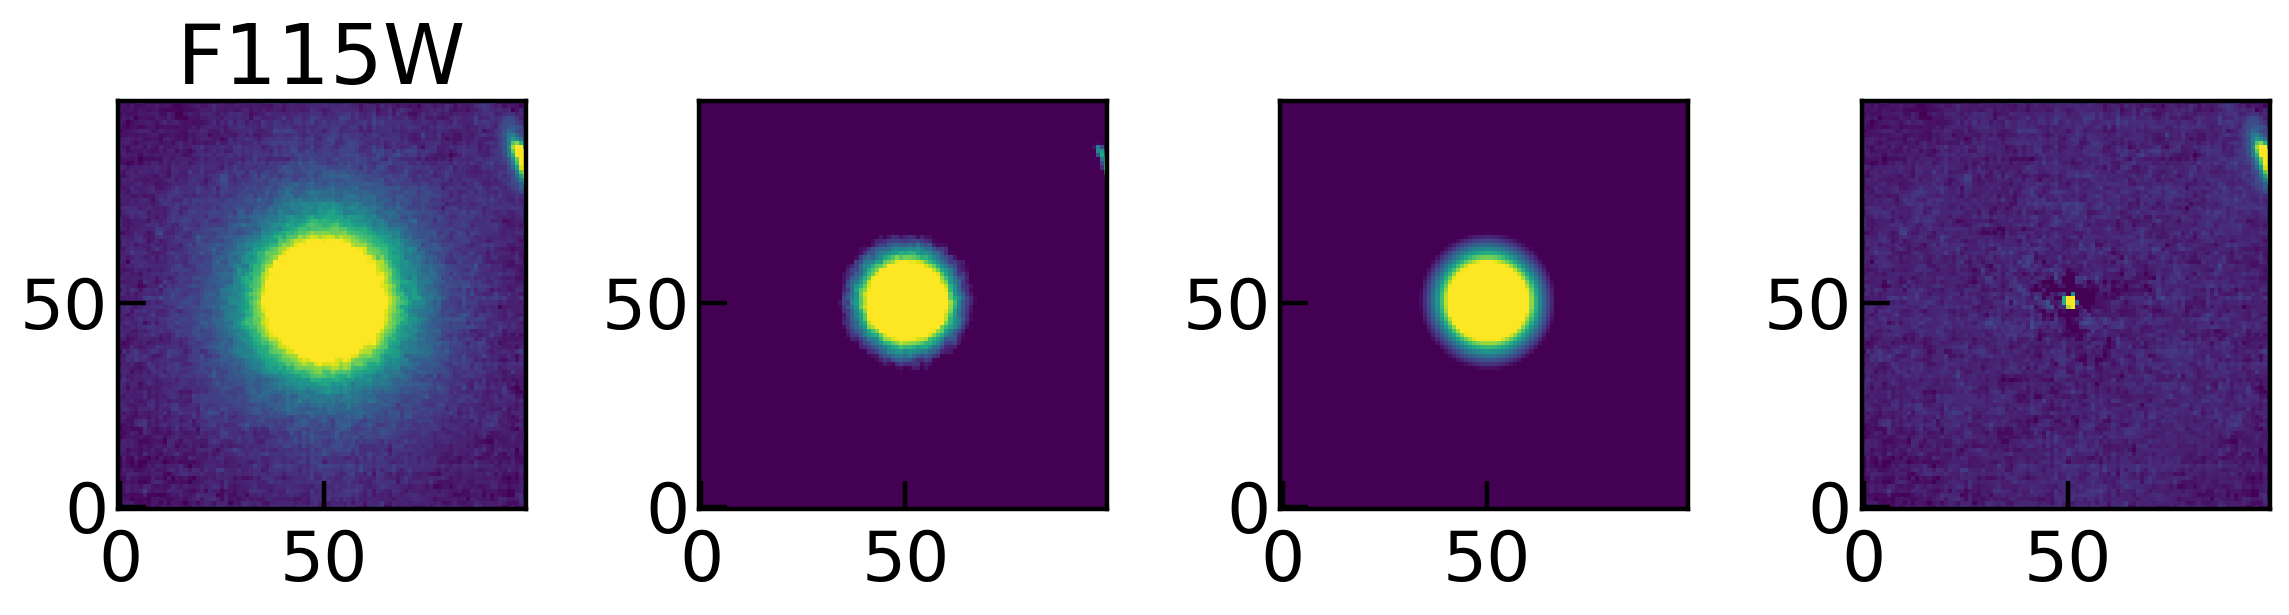

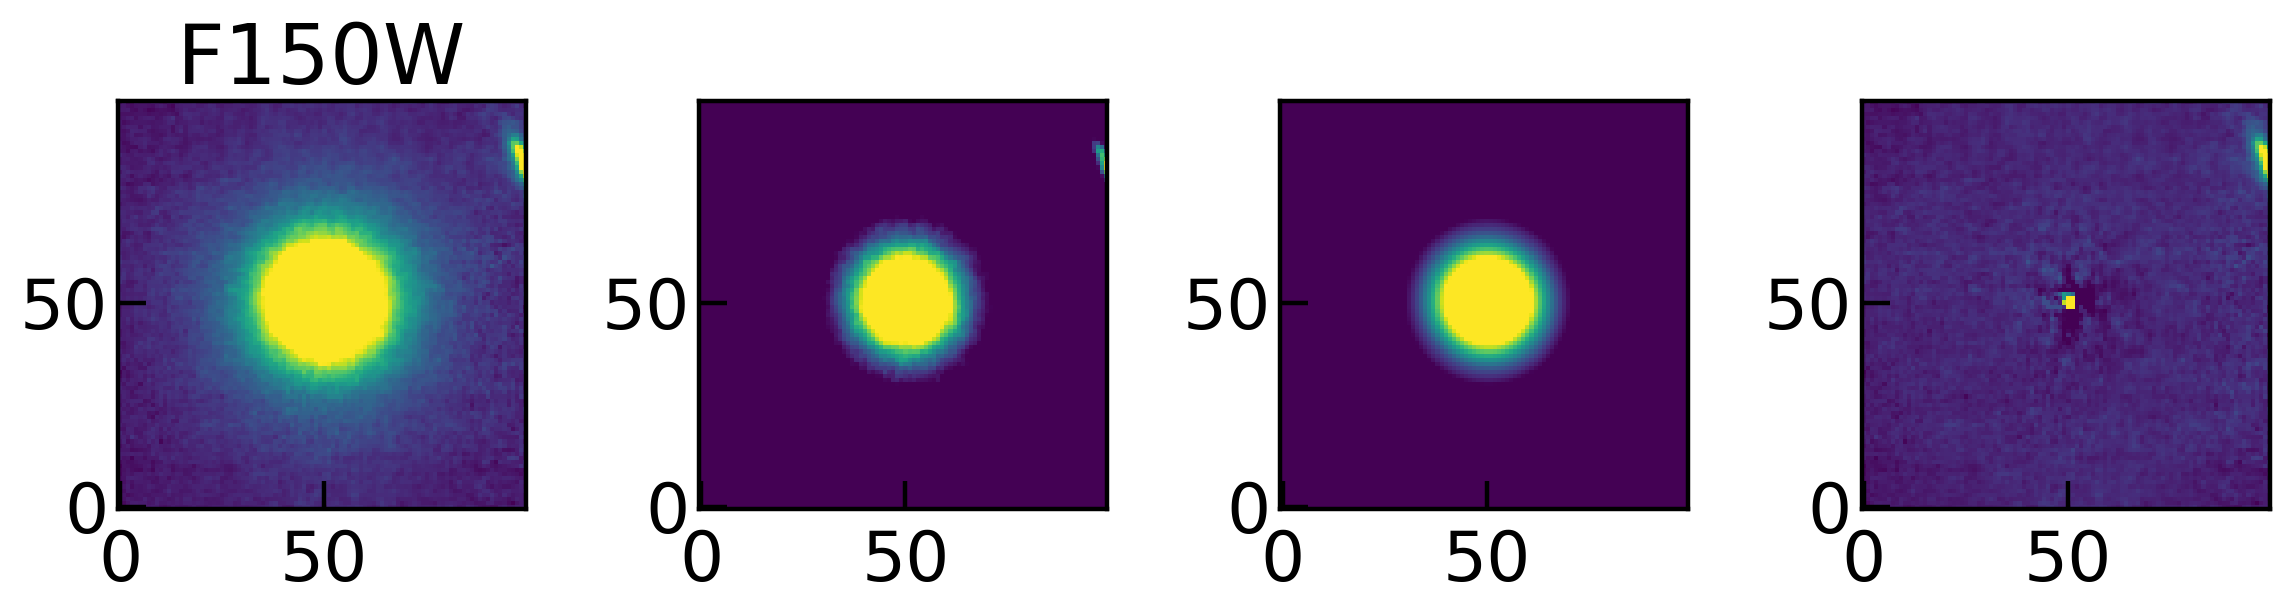

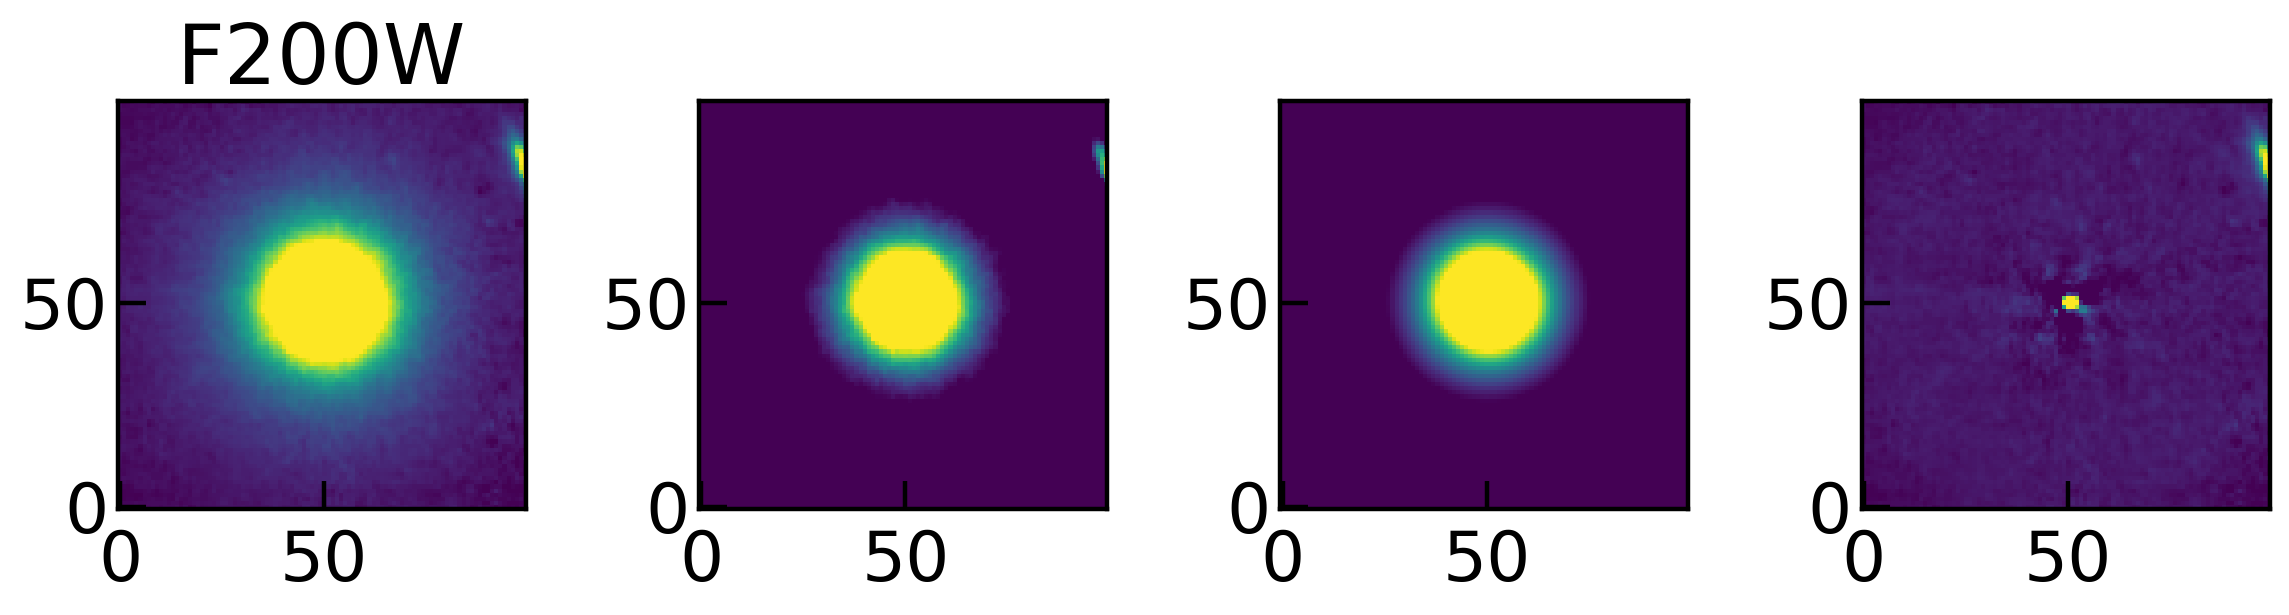

In [10]:
from astropy.visualization import ZScaleInterval
ZInterval = ZScaleInterval()
#cutoutnames, modnames, resnames
for ii in range(len(modnames)):
    cutind = fits.open(cutoutnames[ii])[1].data
    modind = fits.open(modnames[ii])[1].data
    resind = fits.open(resnames[ii])[1].data

    height, width, bkgcut_size = cutind.shape[0], cutind.shape[1], 15
    top_left_mean = np.mean(cutind[0:bkgcut_size, height-bkgcut_size:height])
    top_right_mean = np.mean(cutind[width-bkgcut_size:width, height-bkgcut_size:height])
    bottom_left_mean = np.mean(cutind[0:bkgcut_size, 0:bkgcut_size])
    bottom_right_mean = np.mean(cutind[width-bkgcut_size:width, 0:bkgcut_size])
    bkg = np.mean([top_left_mean, top_right_mean, bottom_left_mean, bottom_right_mean])

    ZInterval = ZScaleInterval()
    vmin, vmax = ZInterval.get_limits(cutind)
    fig, axes = plt.subplots(1, 4, figsize = (12, 4))

    axes[0].imshow(cutind, vmin = vmin, vmax = vmax)
    axes[0].set_title(f'{filters[ii]}')
    axes[1].imshow(cutind-bkg, vmin=vmin, vmax=vmax)
    axes[2].imshow(modind, vmin = vmin, vmax = vmax)
    axes[3].imshow(resind, vmin = vmin, vmax = vmax)

    plt.tight_layout()
    plt.show()
    plt.close()

# 3. Individual Analaysis

## 1) Brightness Profile

/tmp/ipykernel_26143/3898286869.py:13: RuntimeWarning: invalid value encountered in log10
  axes.scatter(isolist[ii].sma**0.25, -2.5*np.log10(isolist[ii].intens))


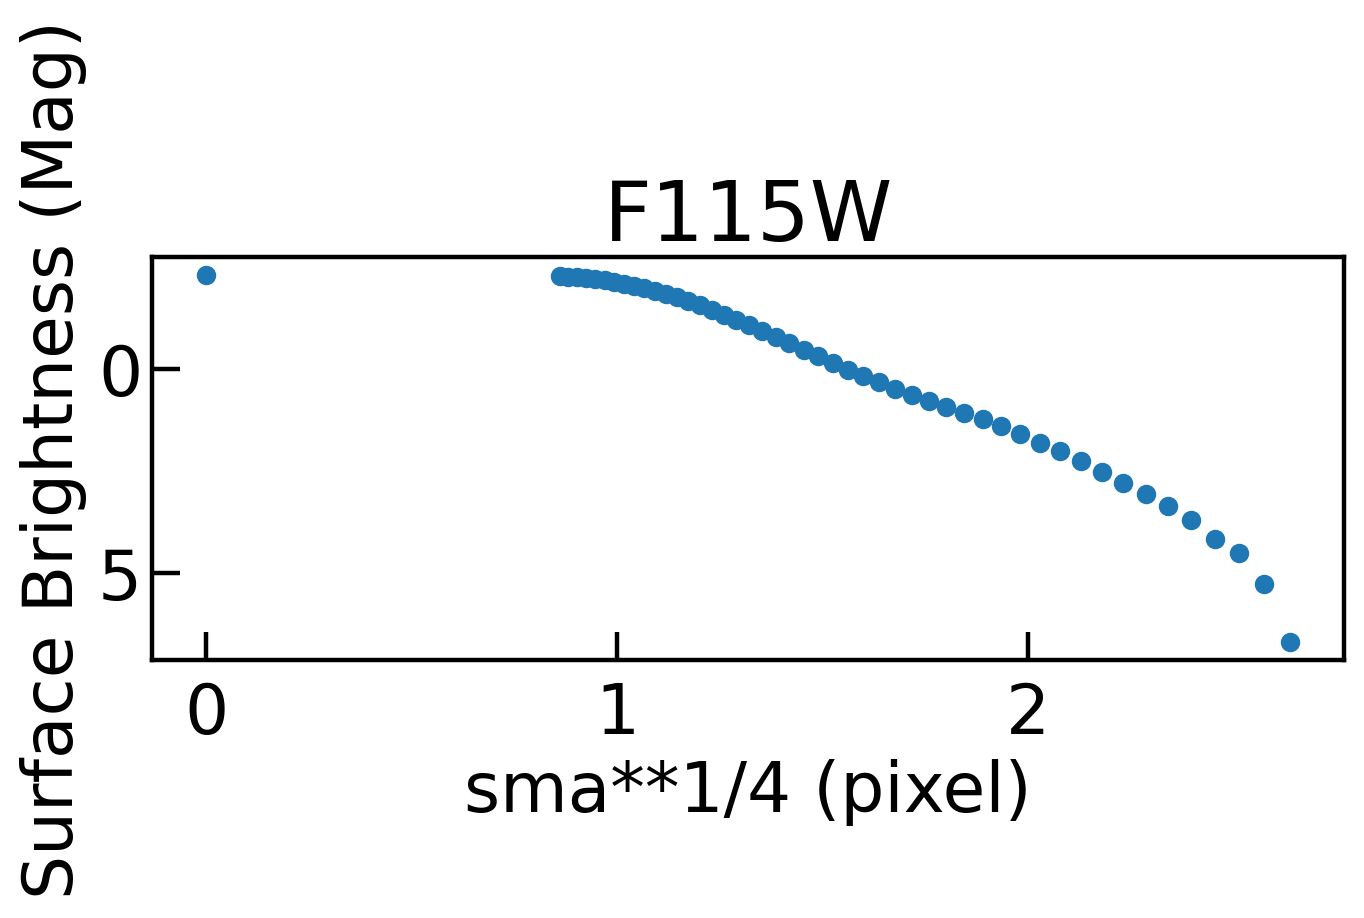

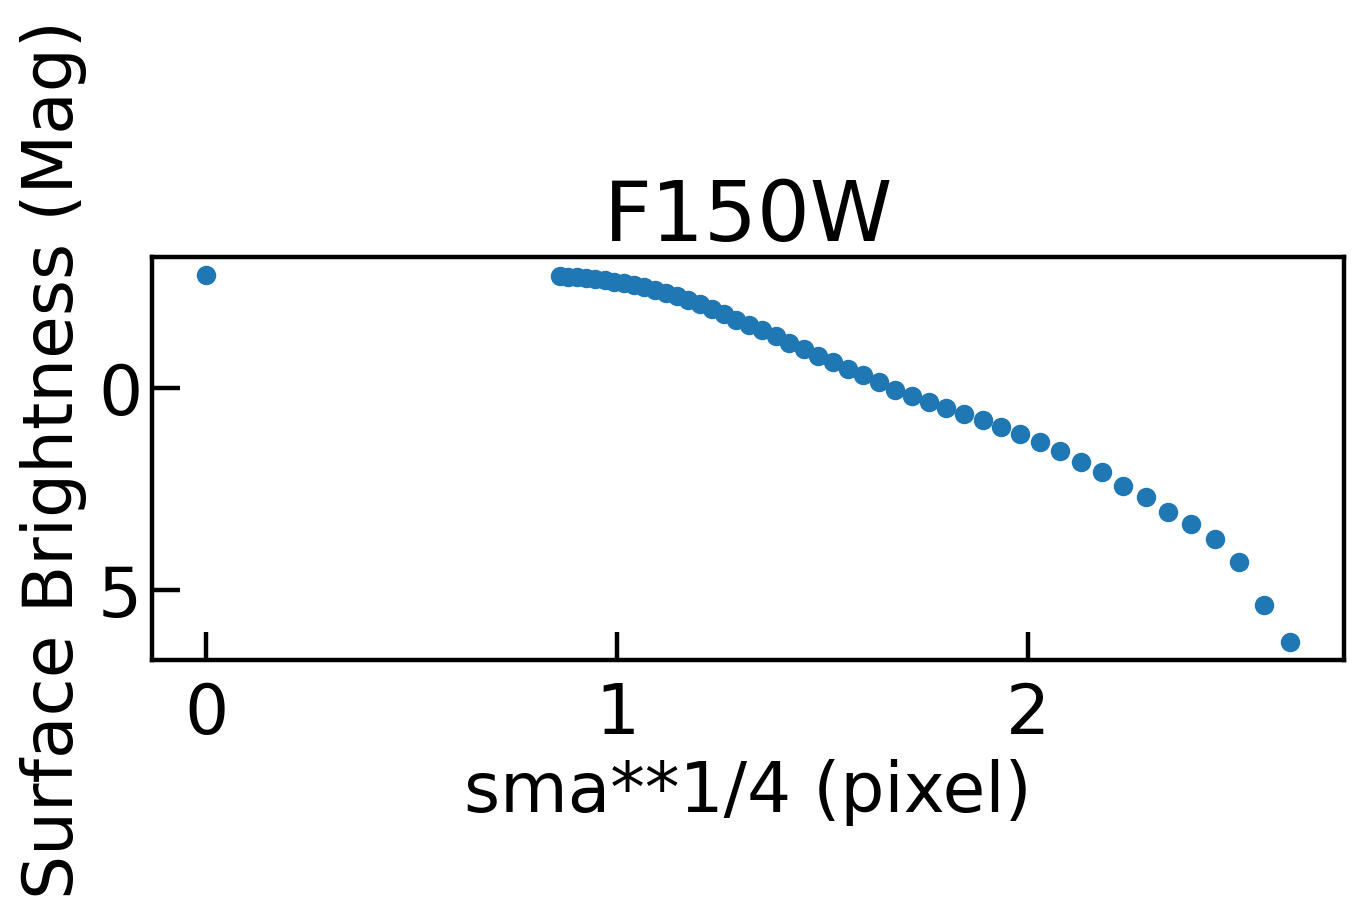

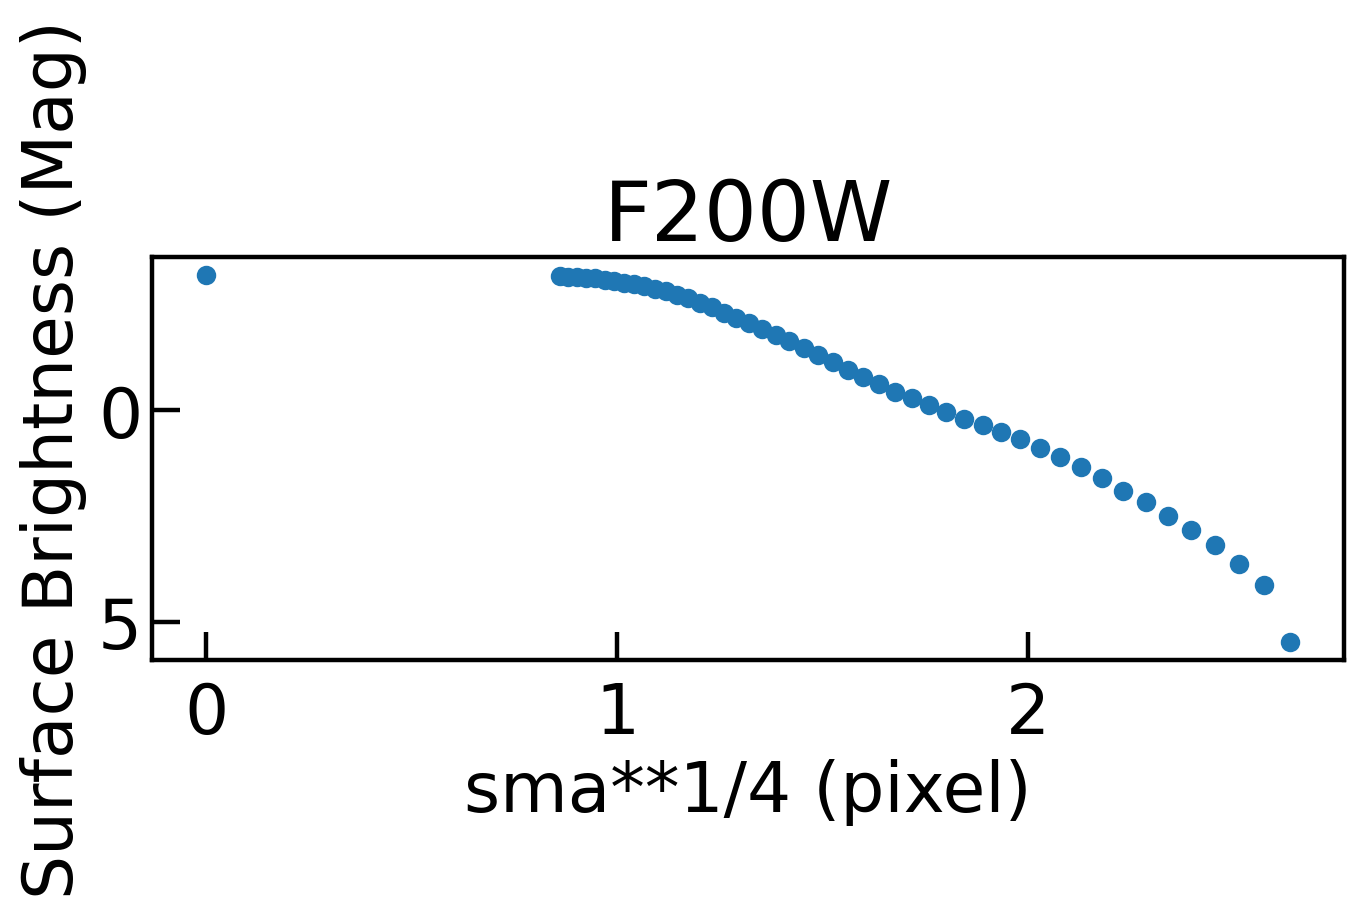

In [11]:
from astropy.visualization import ZScaleInterval
ZInterval = ZScaleInterval()
#cutoutnames, modnames, resnames
for ii in range(len(modnames)):
    cutind = fits.open(cutoutnames[ii])[1].data
    modind = fits.open(modnames[ii])[1].data
    resind = fits.open(resnames[ii])[1].data

    ZInterval = ZScaleInterval()
    vmin, vmax = ZInterval.get_limits(cutind)
    fig, axes = plt.subplots(1, 1, figsize = (8, 4))

    axes.scatter(isolist[ii].sma**0.25, -2.5*np.log10(isolist[ii].intens))
    axes.set_title(f'{filters[ii]}')
    axes.invert_yaxis()
    axes.set_xlabel('sma**1/4 (pixel)')
    axes.set_ylabel('Surface Brightness (Mag)')
    
    plt.tight_layout()
    plt.show()
    plt.close()

## 2) Angle - Intensity (Spherical? / Disky?)

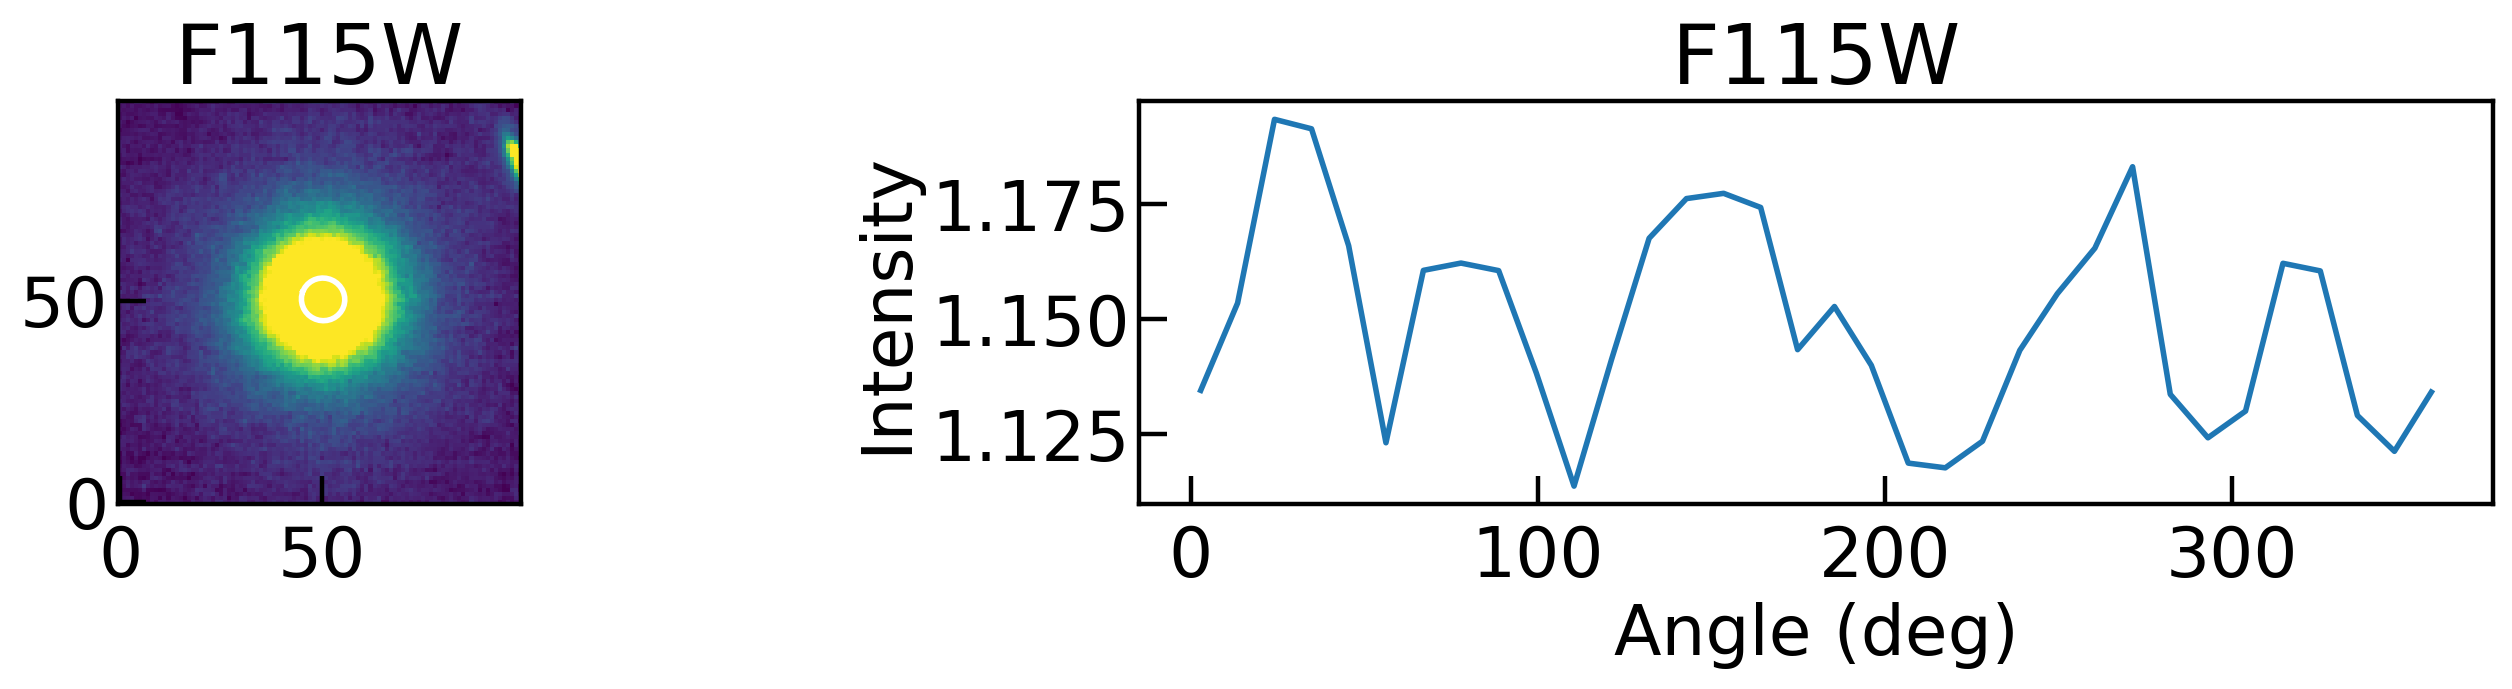

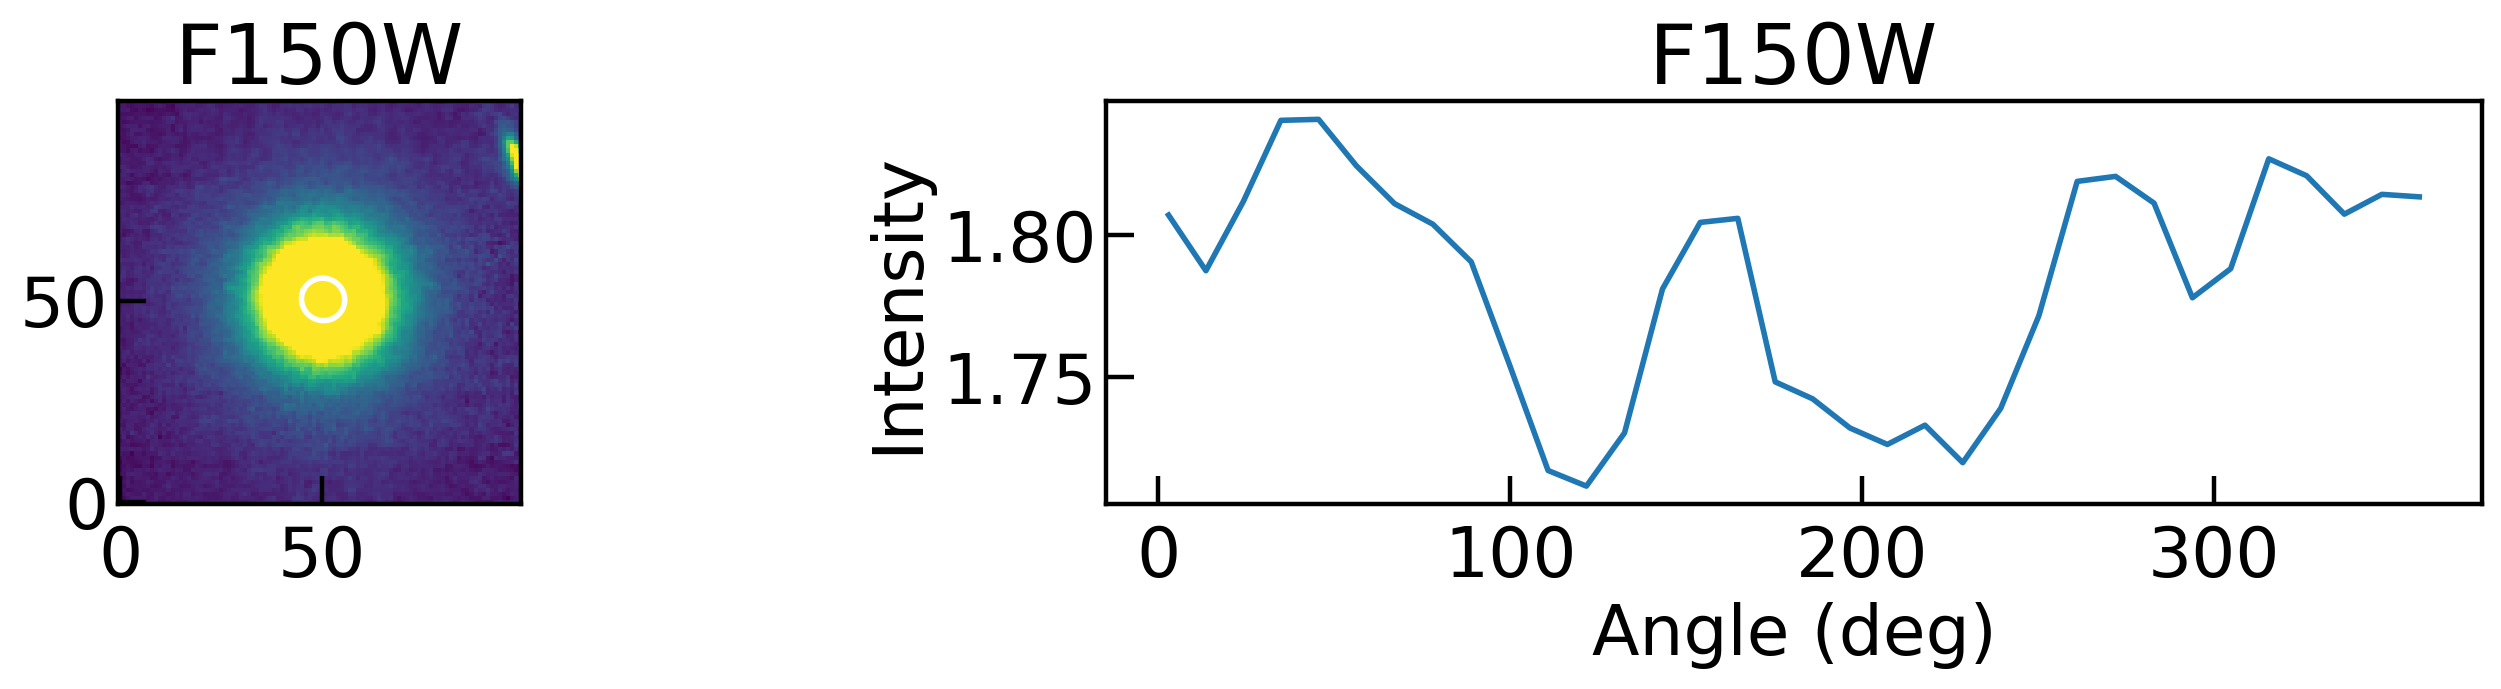

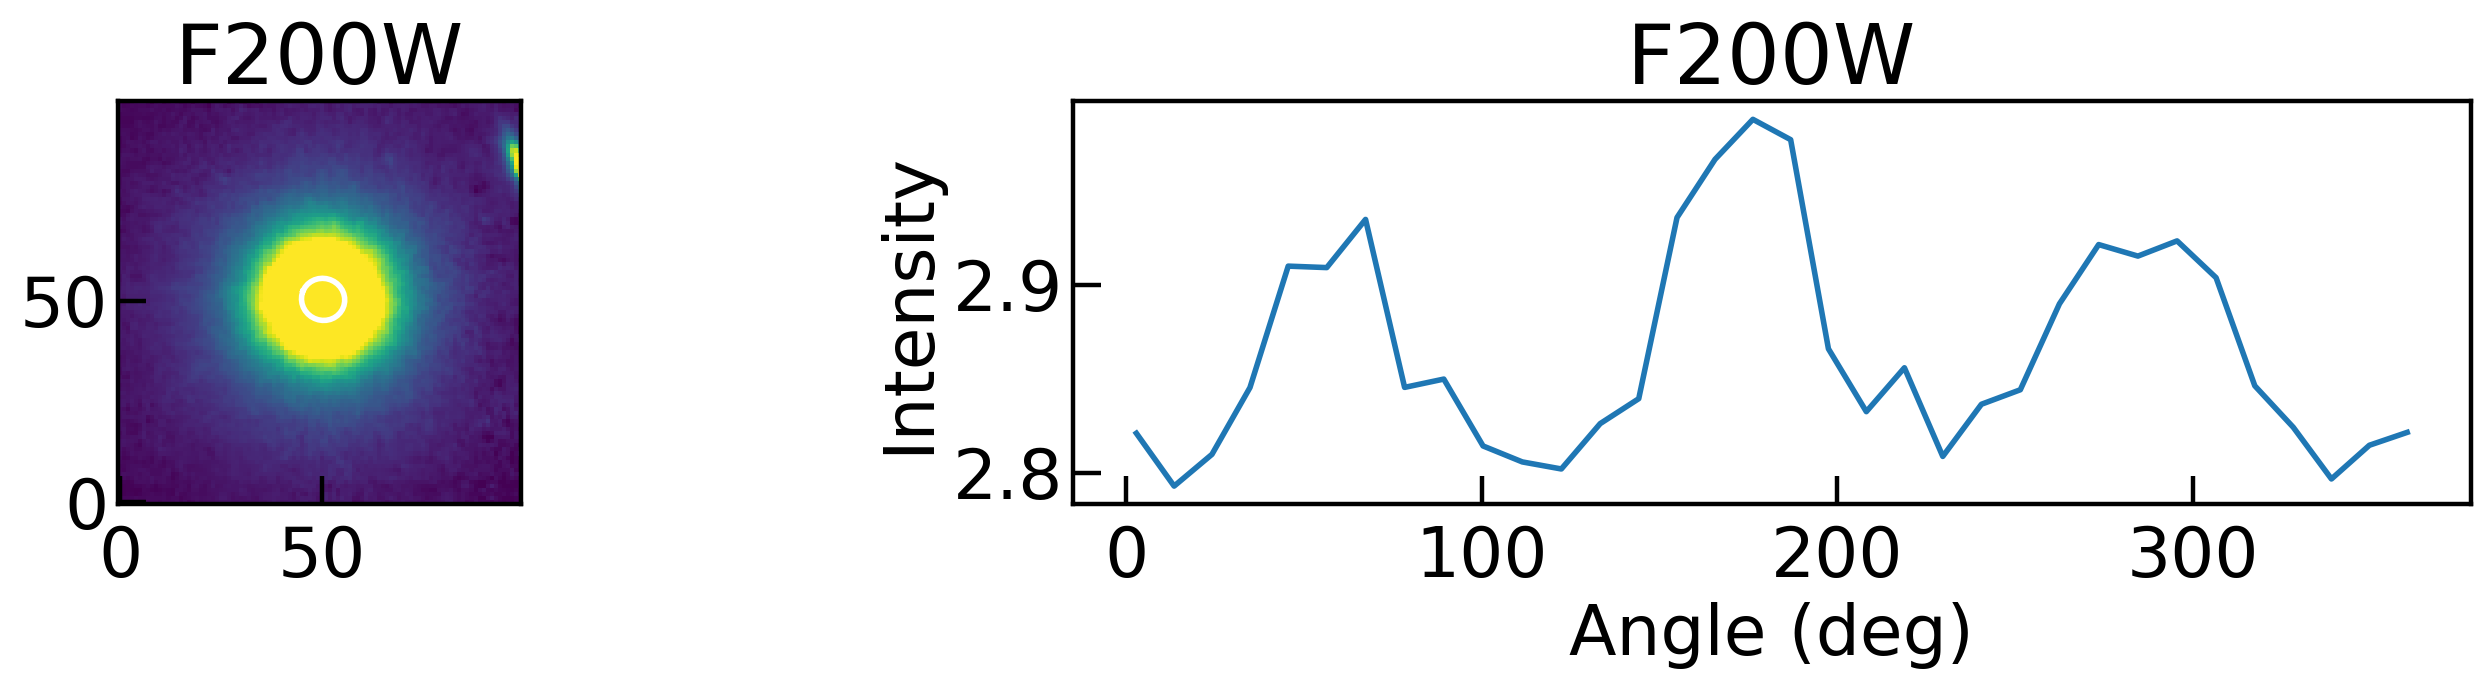

In [12]:
from astropy.visualization import ZScaleInterval
ZInterval = ZScaleInterval()
#cutoutnames, modnames, resnames
for ii in range(len(modnames)):
    cutind = fits.open(cutoutnames[ii])[1].data
    modind = fits.open(modnames[ii])[1].data
    resind = fits.open(resnames[ii])[1].data
    isoind = isolist[ii]
    
    iso = isoind.get_closest(np.median(isoind.sma))
    xd, yd = iso.sampled_coordinates()

    ZInterval = ZScaleInterval()
    vmin, vmax = ZInterval.get_limits(cutind)
    fig, axes = plt.subplots(1, 2, figsize = (15, 4))

    axes[0].imshow(cutind, vmin=vmin, vmax=vmax)
    axes[0].plot(xd, yd, color='white')
    
    axes[1].plot(iso.sample.values[0] / np.pi*180., iso.sample.values[2])
    
    axes[1].set_ylabel("Intensity")
    axes[1].set_xlabel("Angle (deg)")
    
    axes[0].set_title(f'{filters[ii]}')
    axes[1].set_title(f'{filters[ii]}')

    plt.tight_layout()
    plt.show()
    plt.close()

## Ellipstical Feature

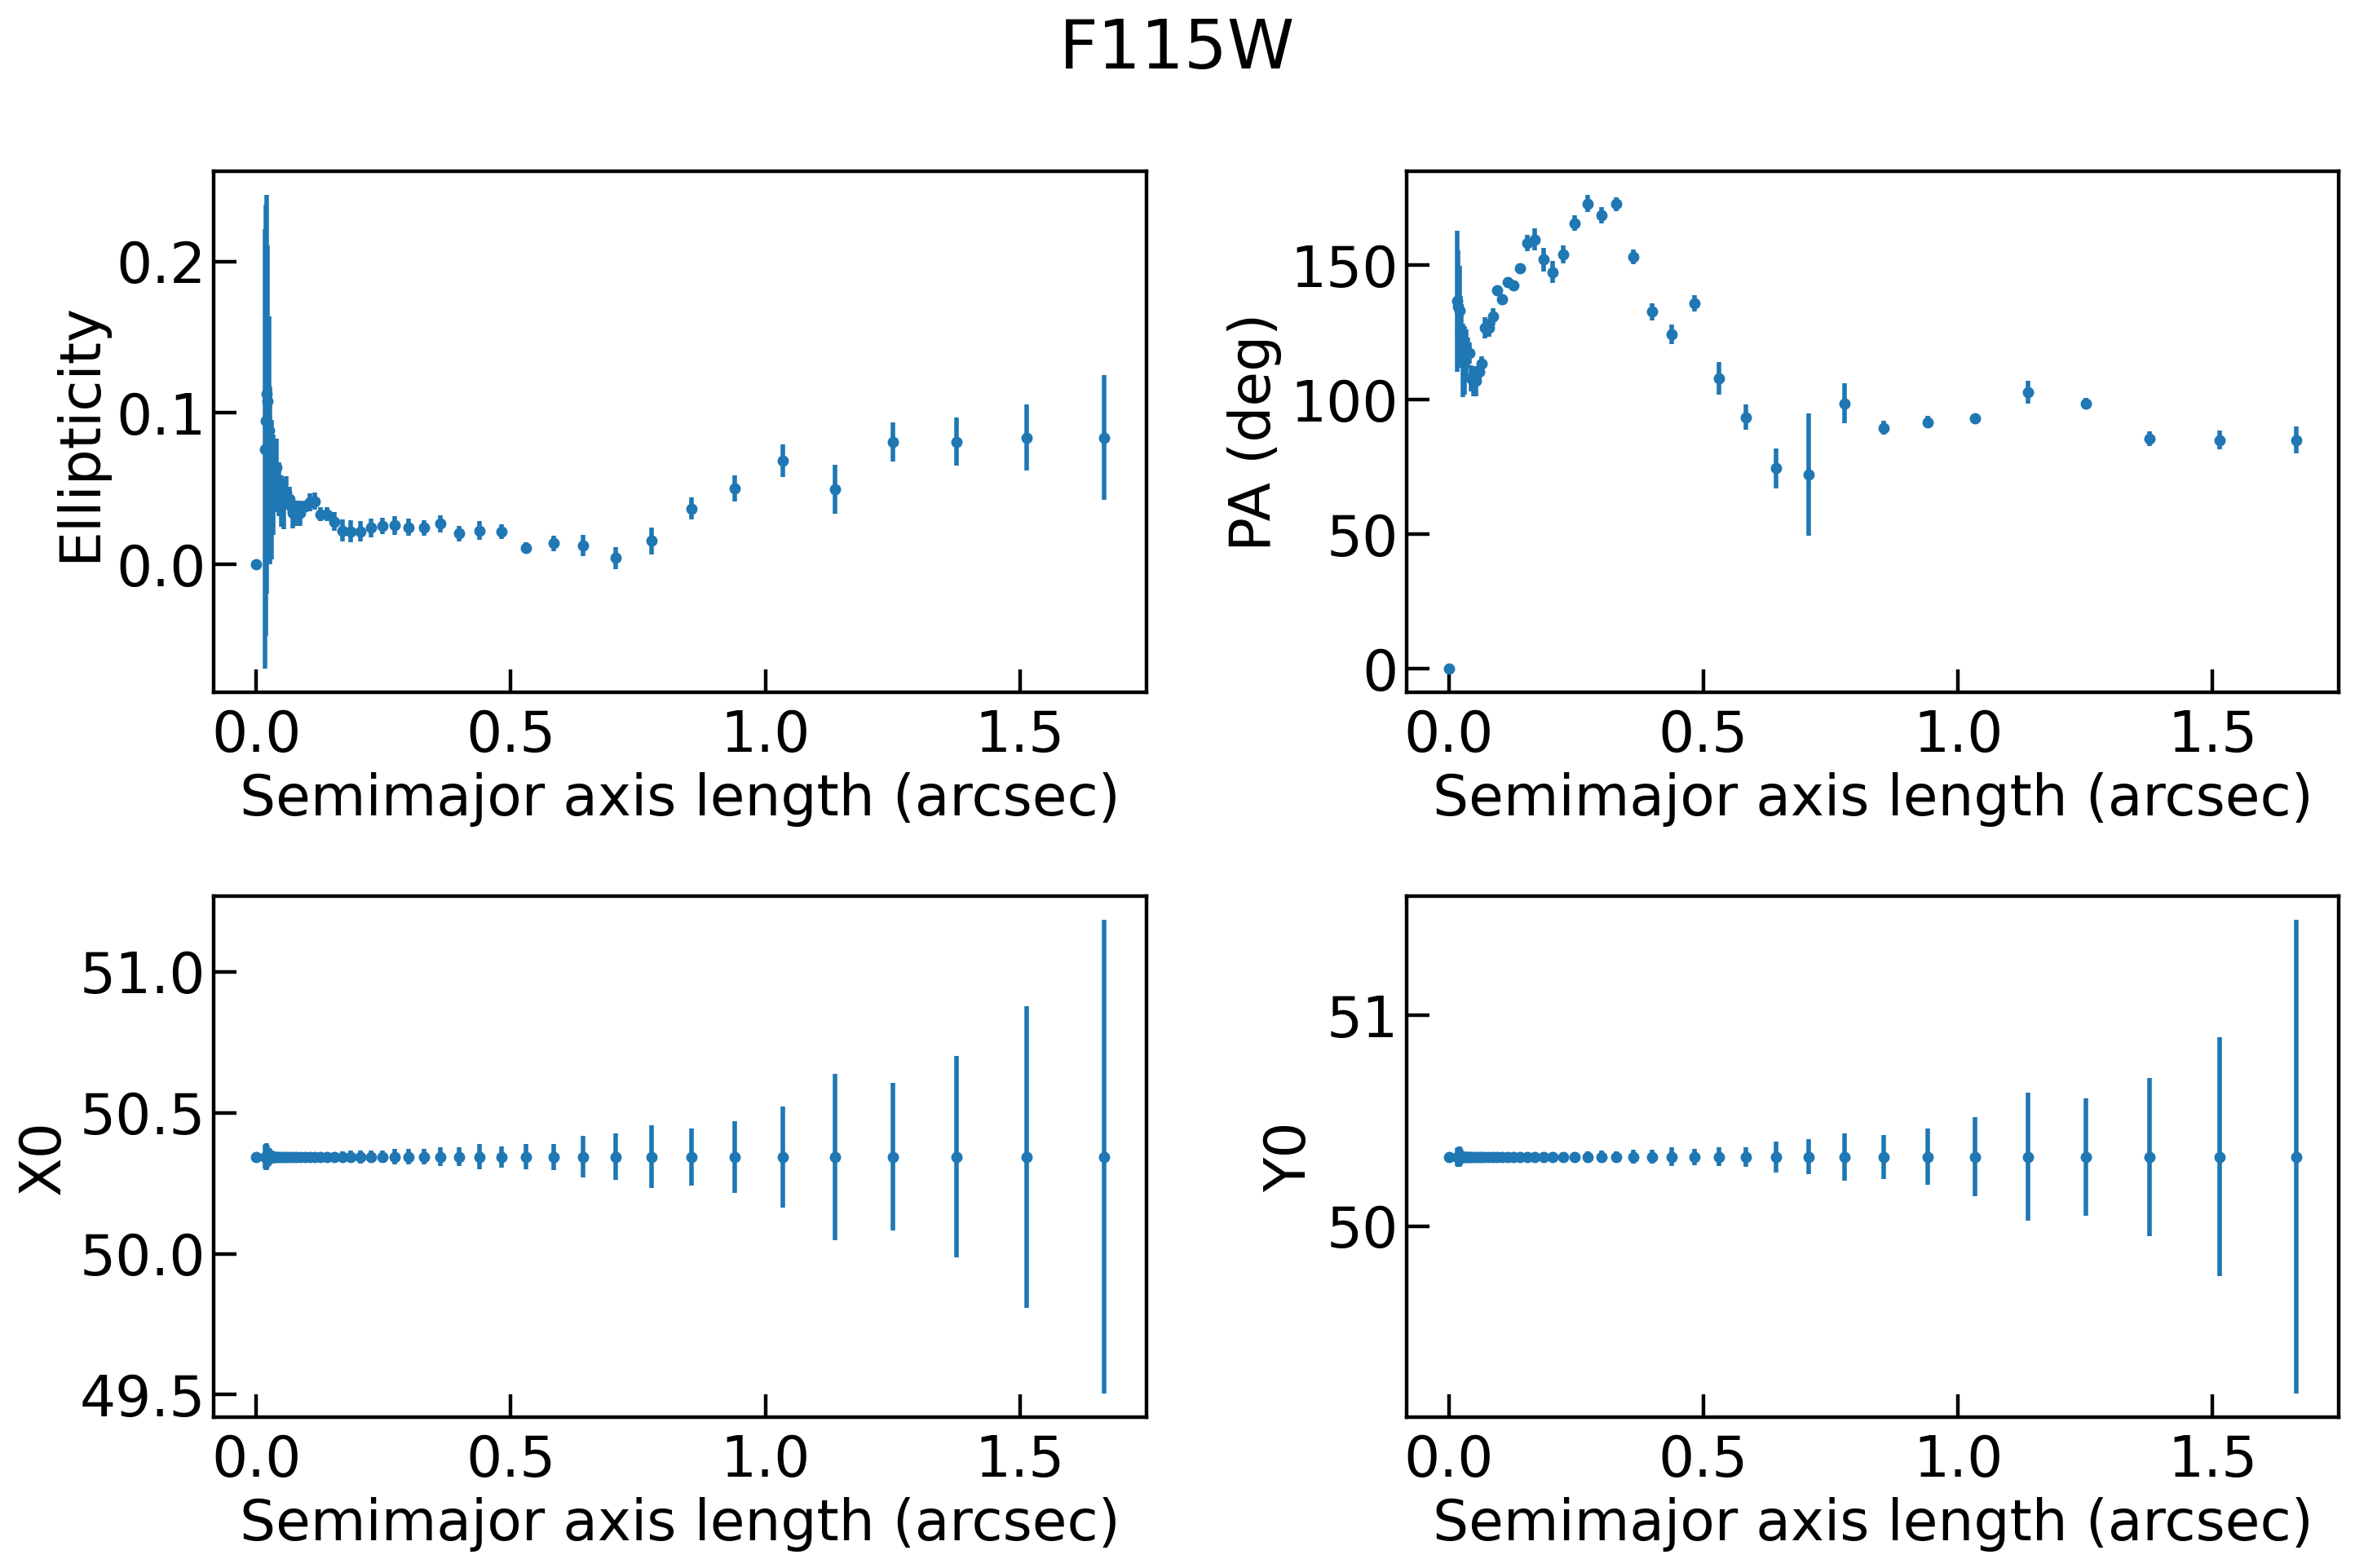

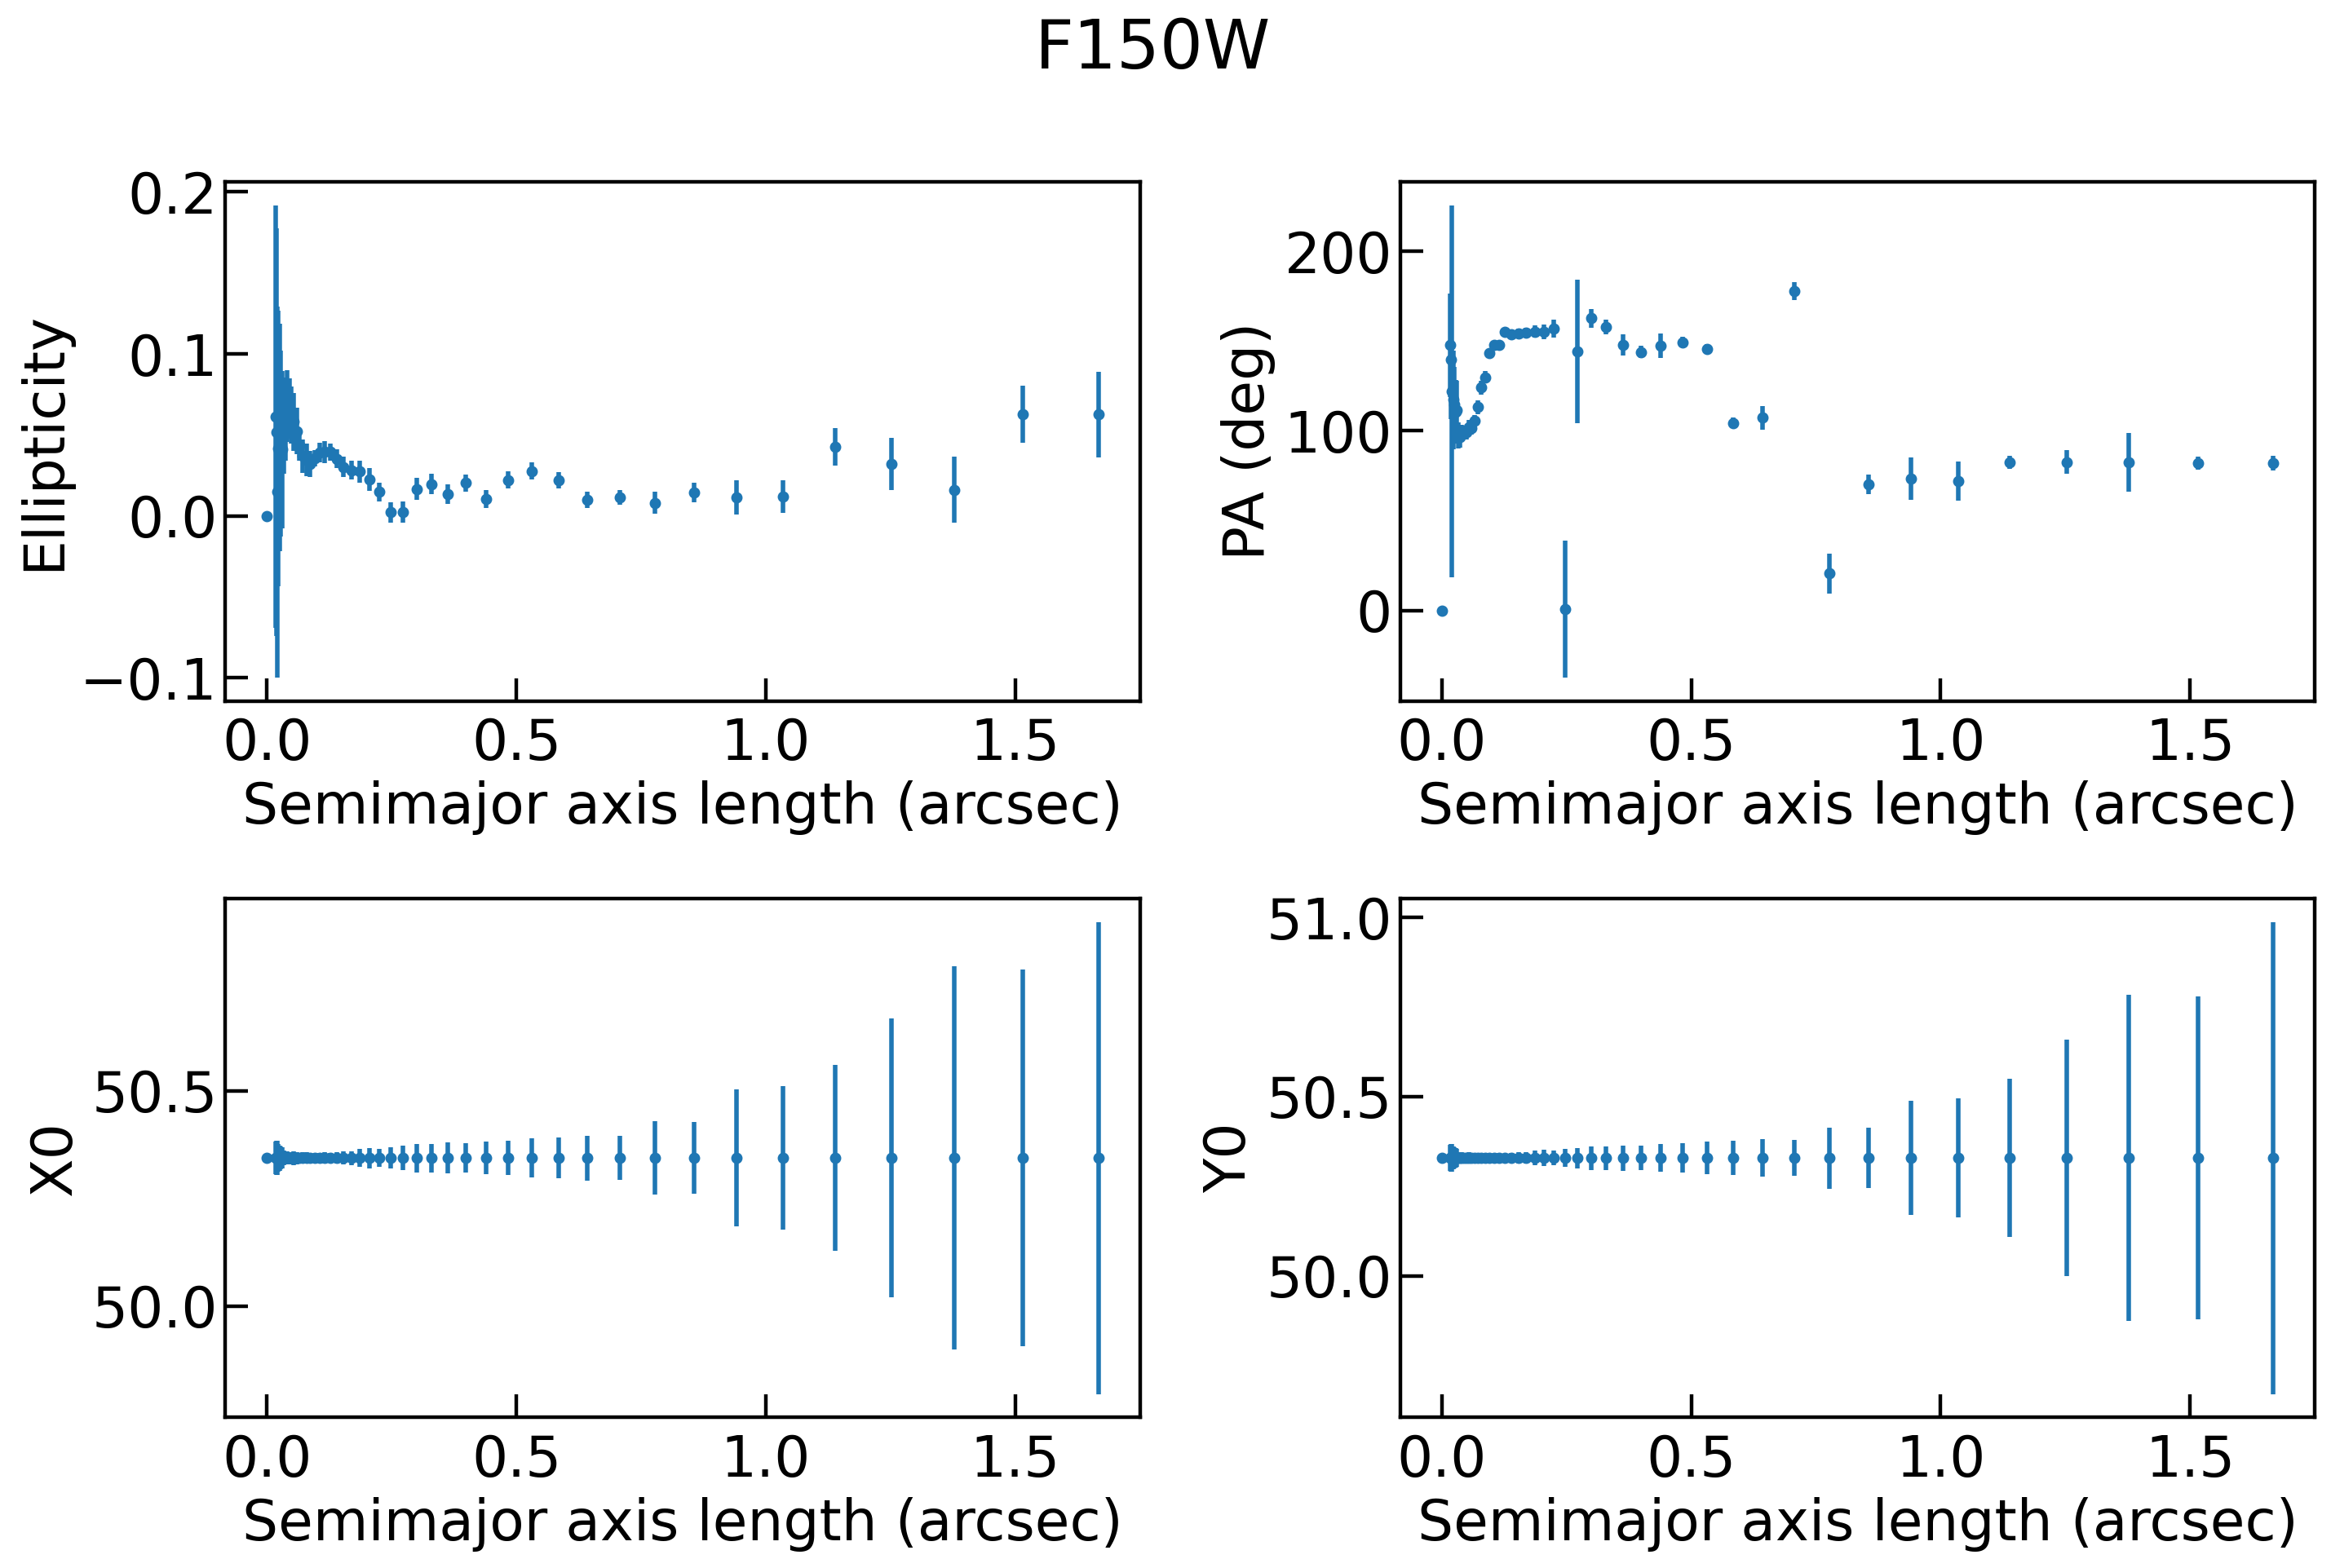

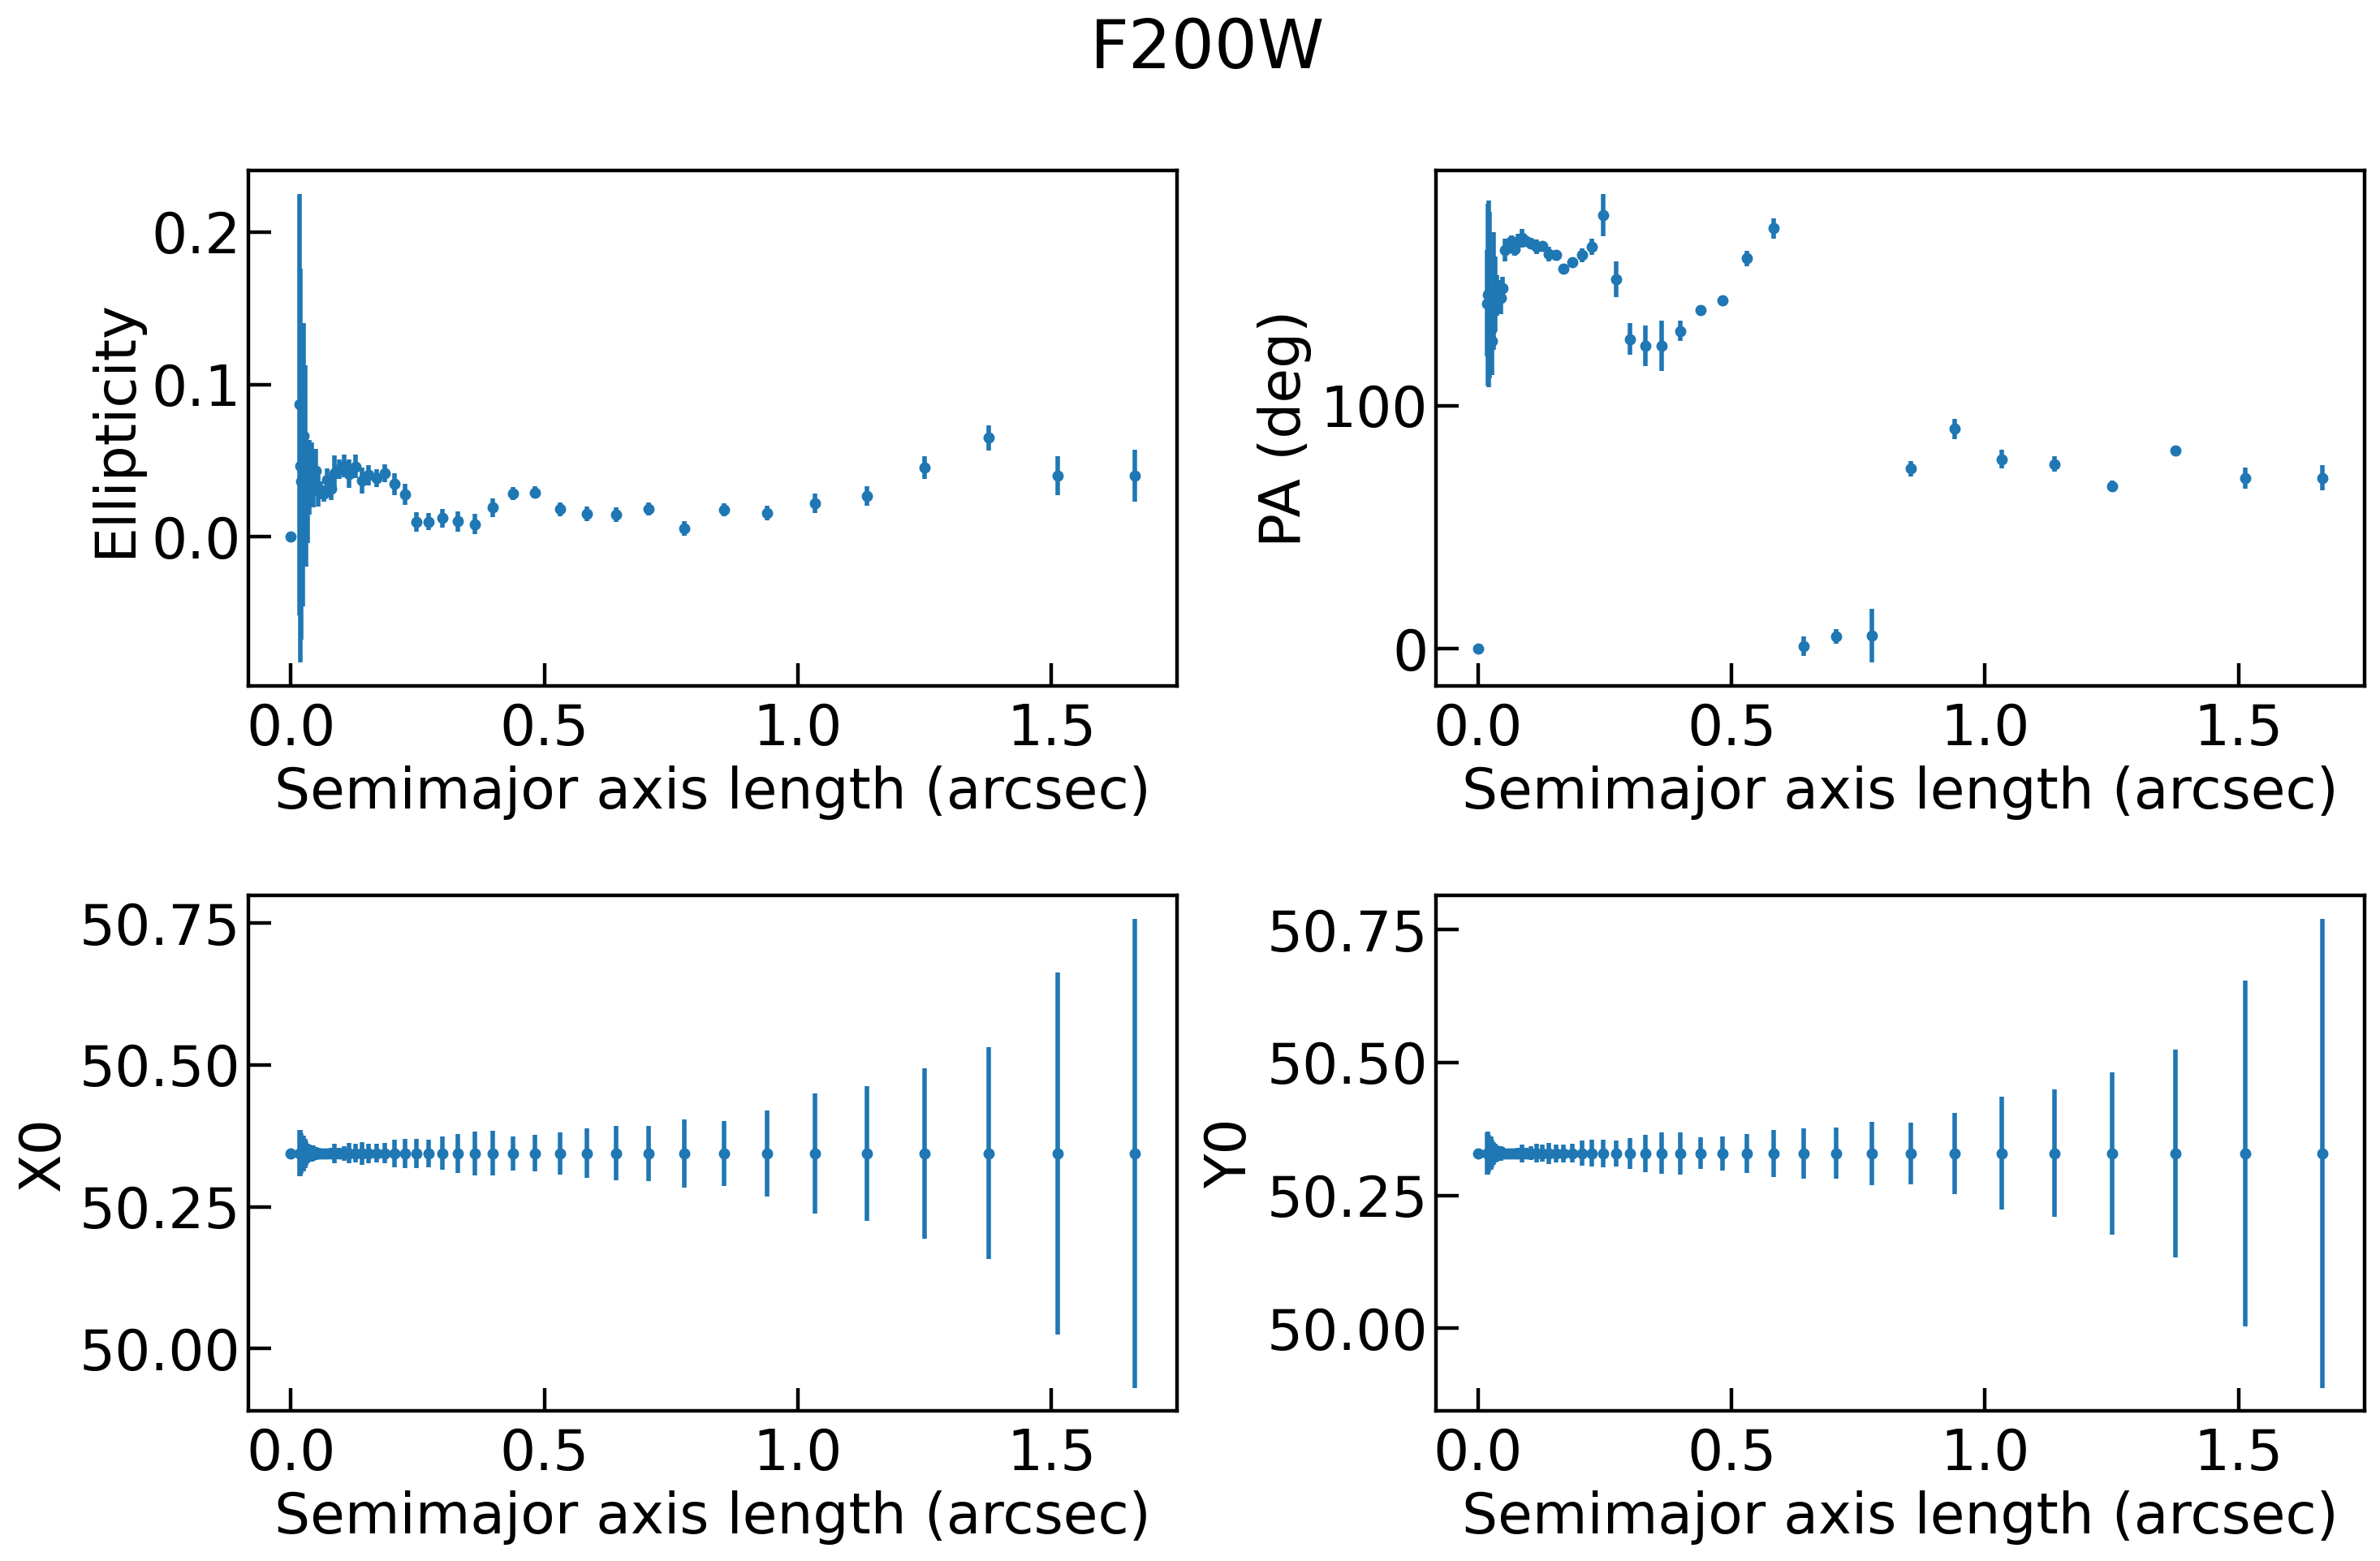

In [13]:
from astropy.visualization import ZScaleInterval
ZInterval = ZScaleInterval()
#cutoutnames, modnames, resnames
for ii in range(len(modnames)):
    cutind = fits.open(cutoutnames[ii])[1].data
    modind = fits.open(modnames[ii])[1].data
    resind = fits.open(resnames[ii])[1].data
    isoind = isolist[ii]
    tabind = fittabs[ii]
    
    ZInterval = ZScaleInterval()
    vmin, vmax = ZInterval.get_limits(cutind)
    fig, axes = plt.subplots(2, 2, figsize = (15, 10))
    fig.suptitle(f'{filters[ii]}')
   
   
    axes[0,0].errorbar(tabind['sma_arcsec'], isoind.eps, yerr=isoind.ellip_err, fmt='o', markersize=4)
    axes[0,0].set_xlabel('Semimajor axis length (arcsec)')
    axes[0,0].set_ylabel('Ellipticity')
    
    axes[0,1].errorbar(tabind['sma_arcsec'], isoind.pa/np.pi*180., yerr=isoind.pa_err/np.pi* 80., fmt='o', markersize=4)
    axes[0,1].set_xlabel('Semimajor axis length (arcsec)')
    axes[0,1].set_ylabel('PA (deg)')

    
    axes[1,0].errorbar(tabind['sma_arcsec'], isoind.x0, yerr=isoind.x0_err, fmt='o', markersize=4)
    axes[1,0].set_xlabel('Semimajor axis length (arcsec)')
    axes[1,0].set_ylabel('X0')

    
    axes[1,1].errorbar(tabind['sma_arcsec'], isoind.y0, yerr=isoind.y0_err, fmt='o', markersize=4)
    axes[1,1].set_xlabel('Semimajor axis length (arcsec)')
    axes[1,1].set_ylabel('Y0')

    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

    plt.tight_layout()
    plt.show()
    plt.close()

## Elliptical Function Feature

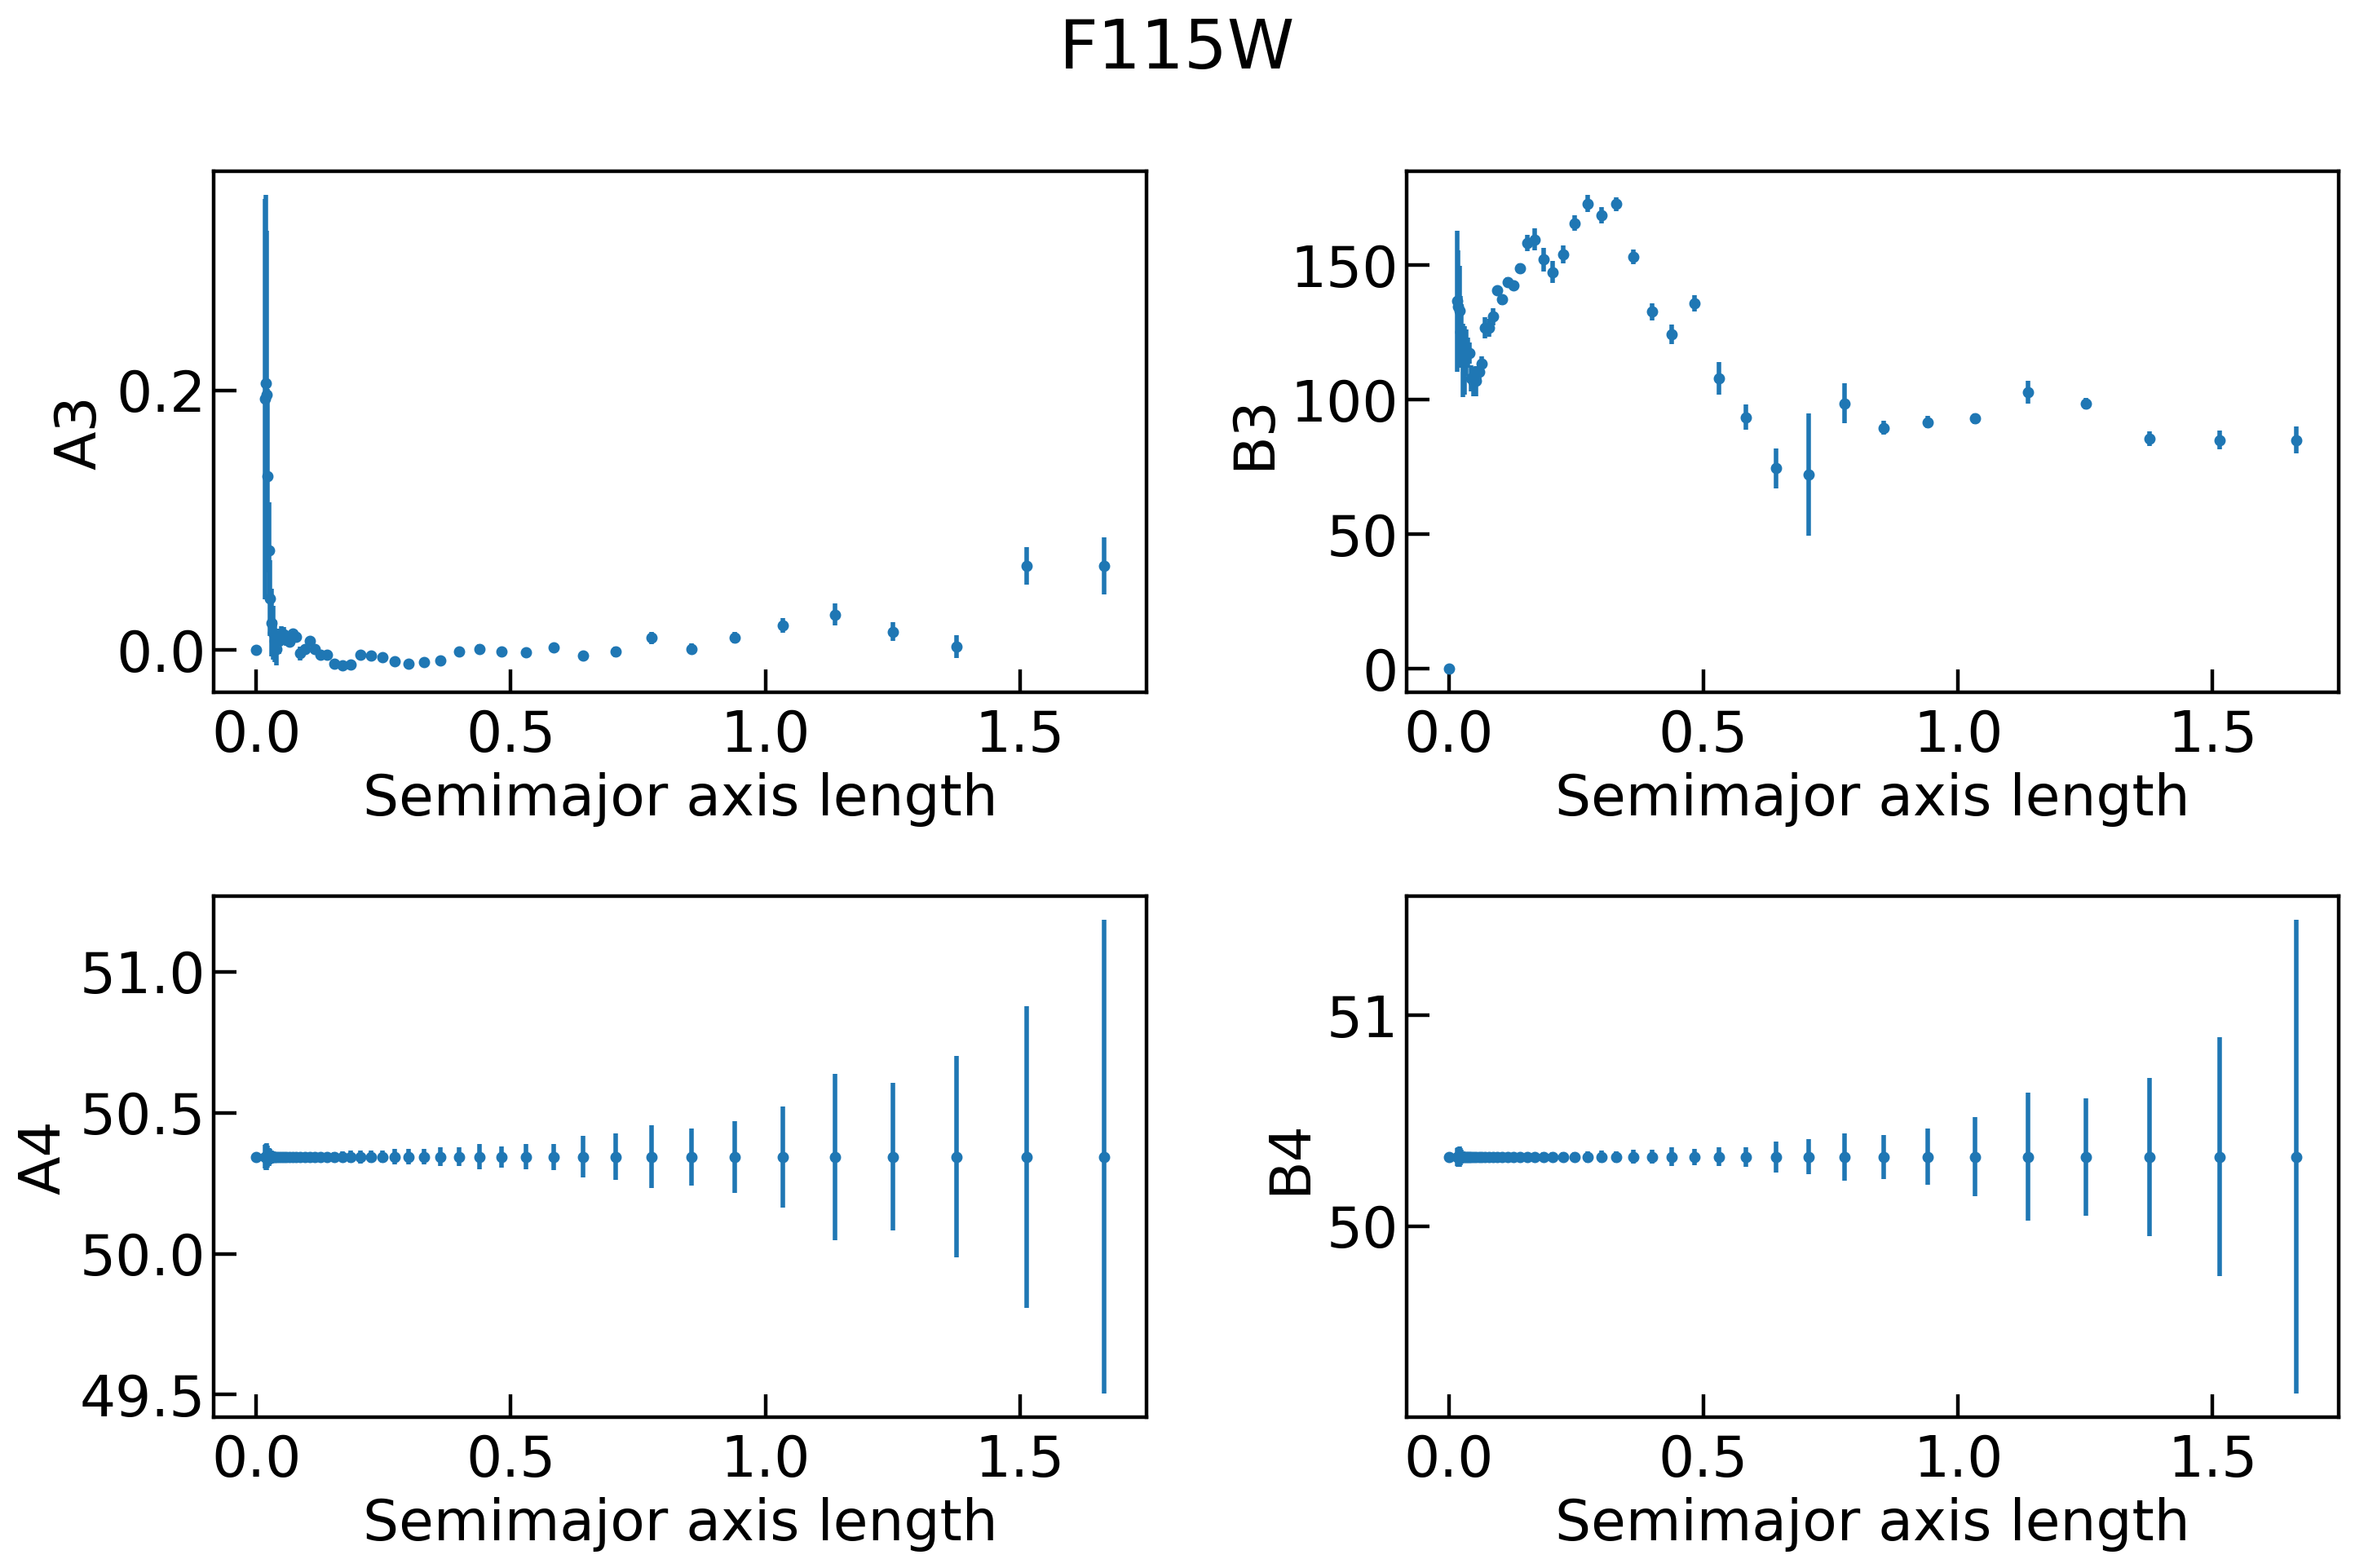

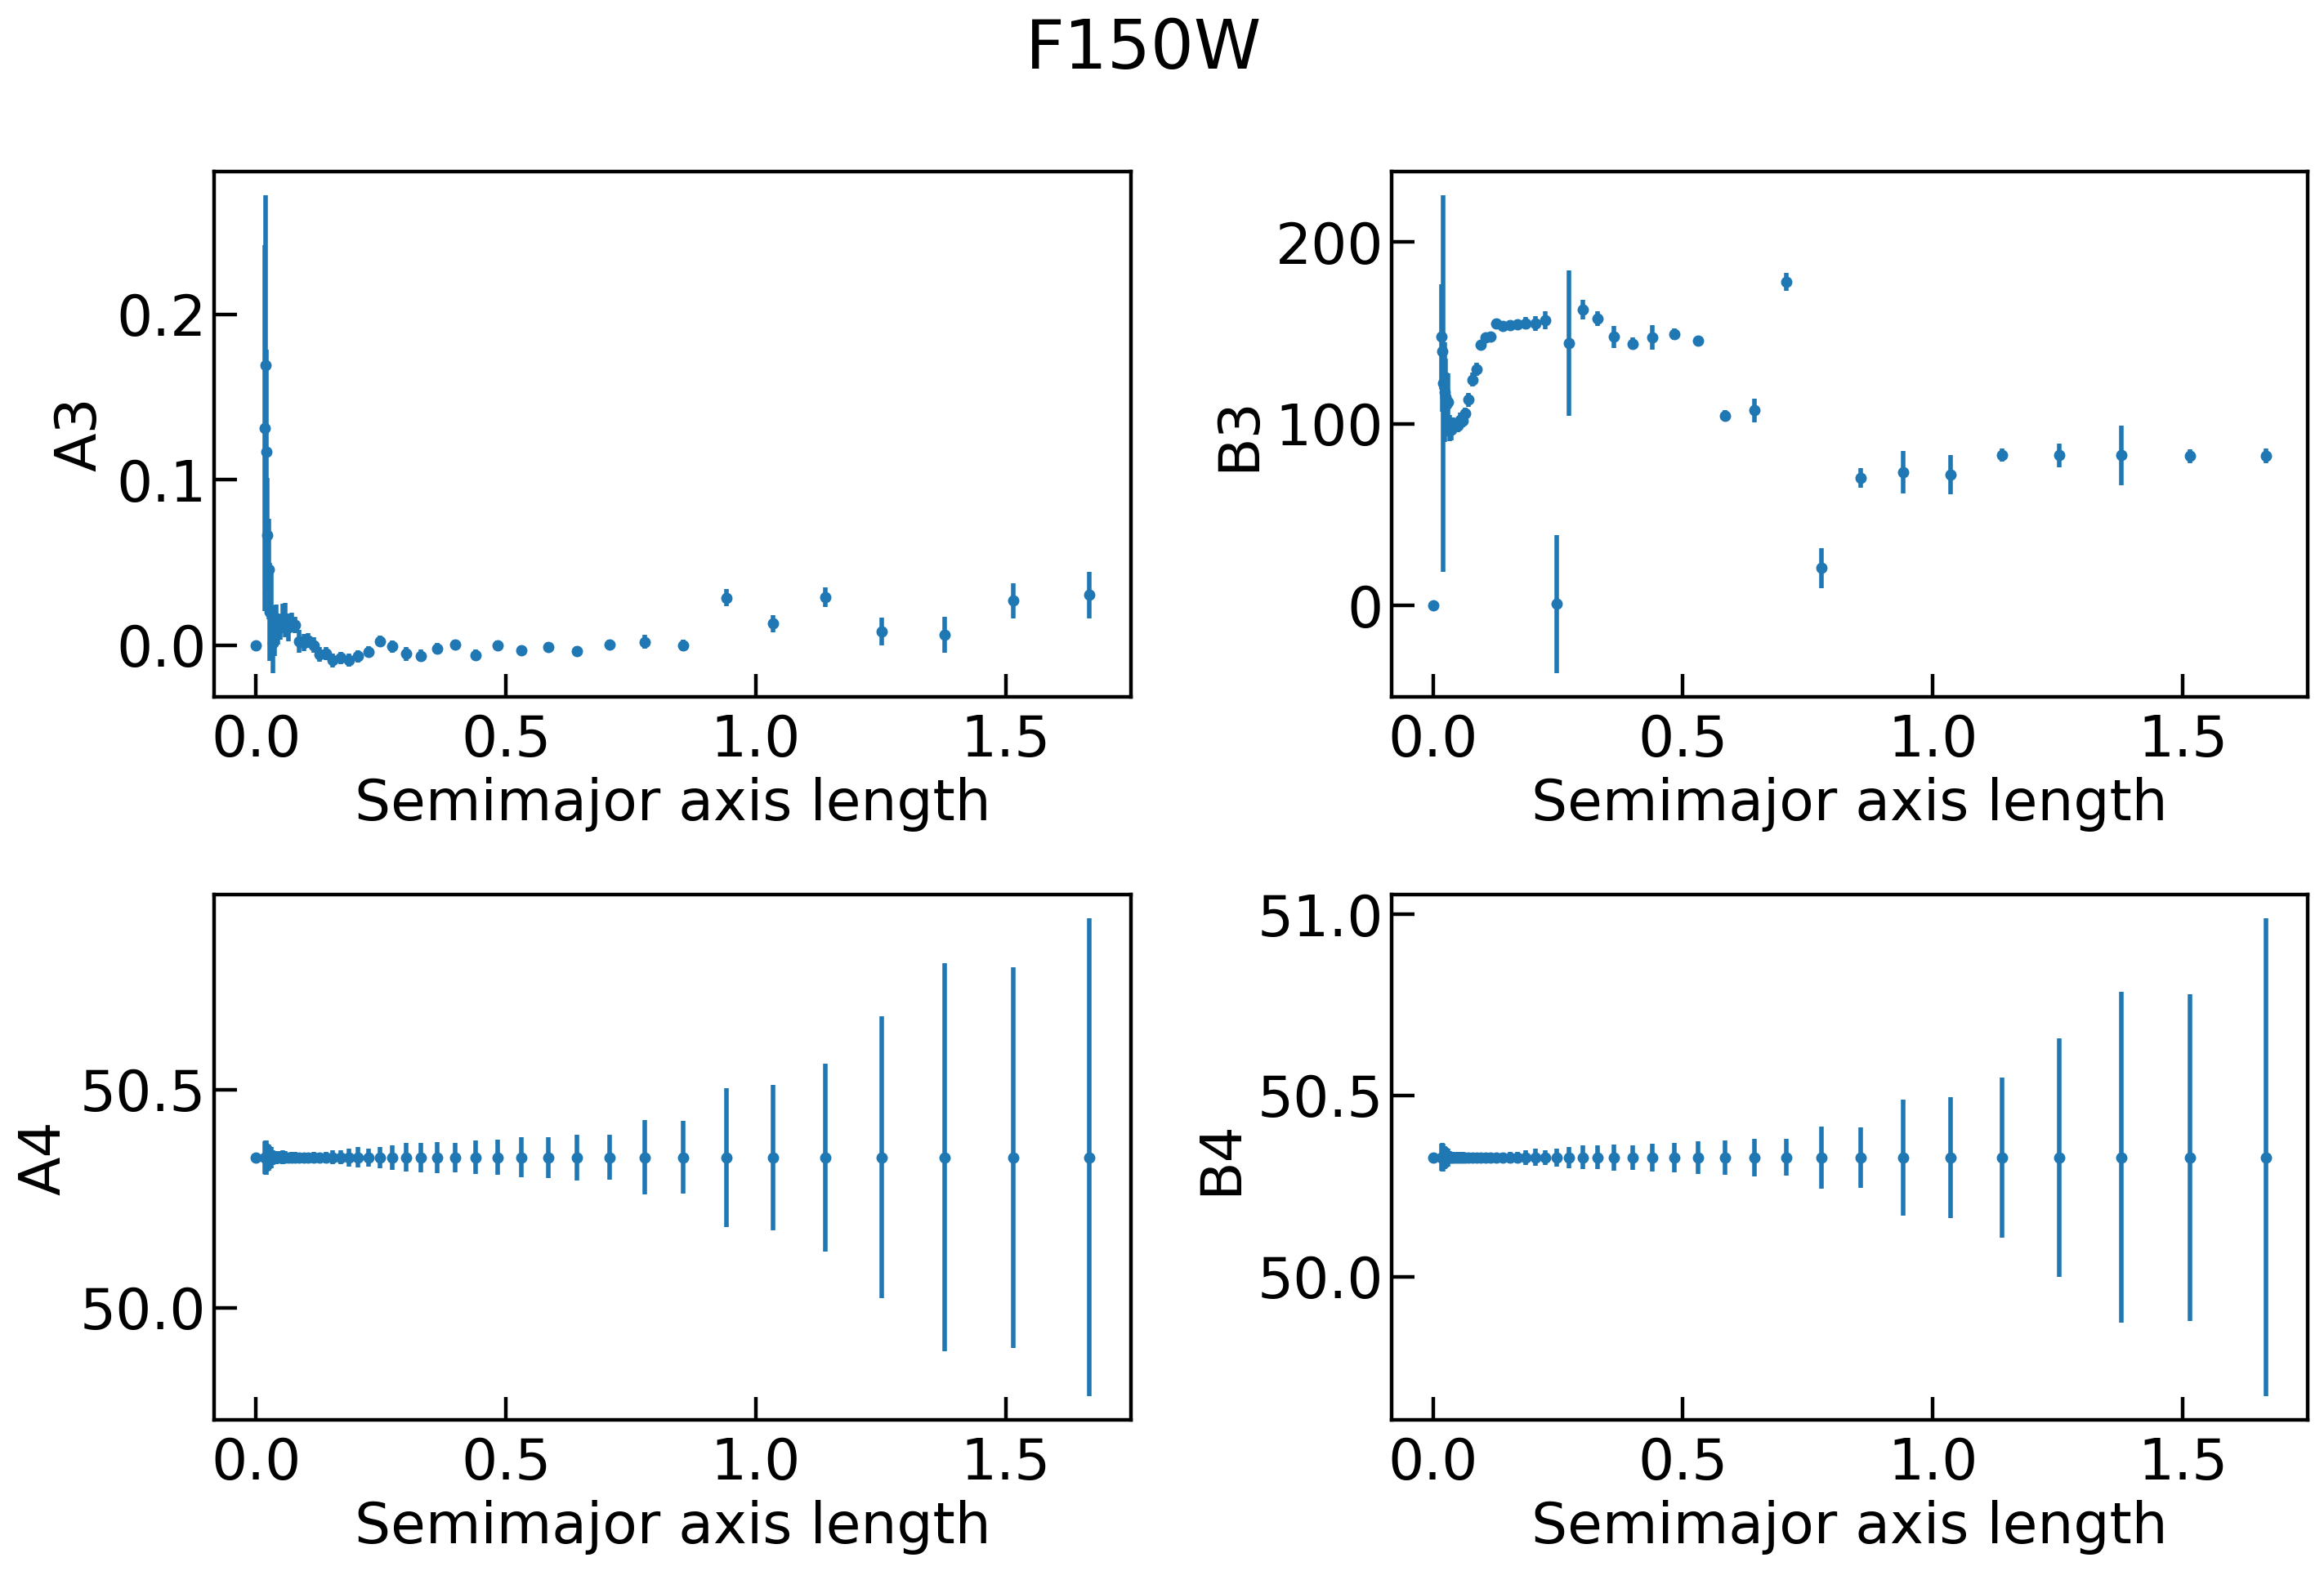

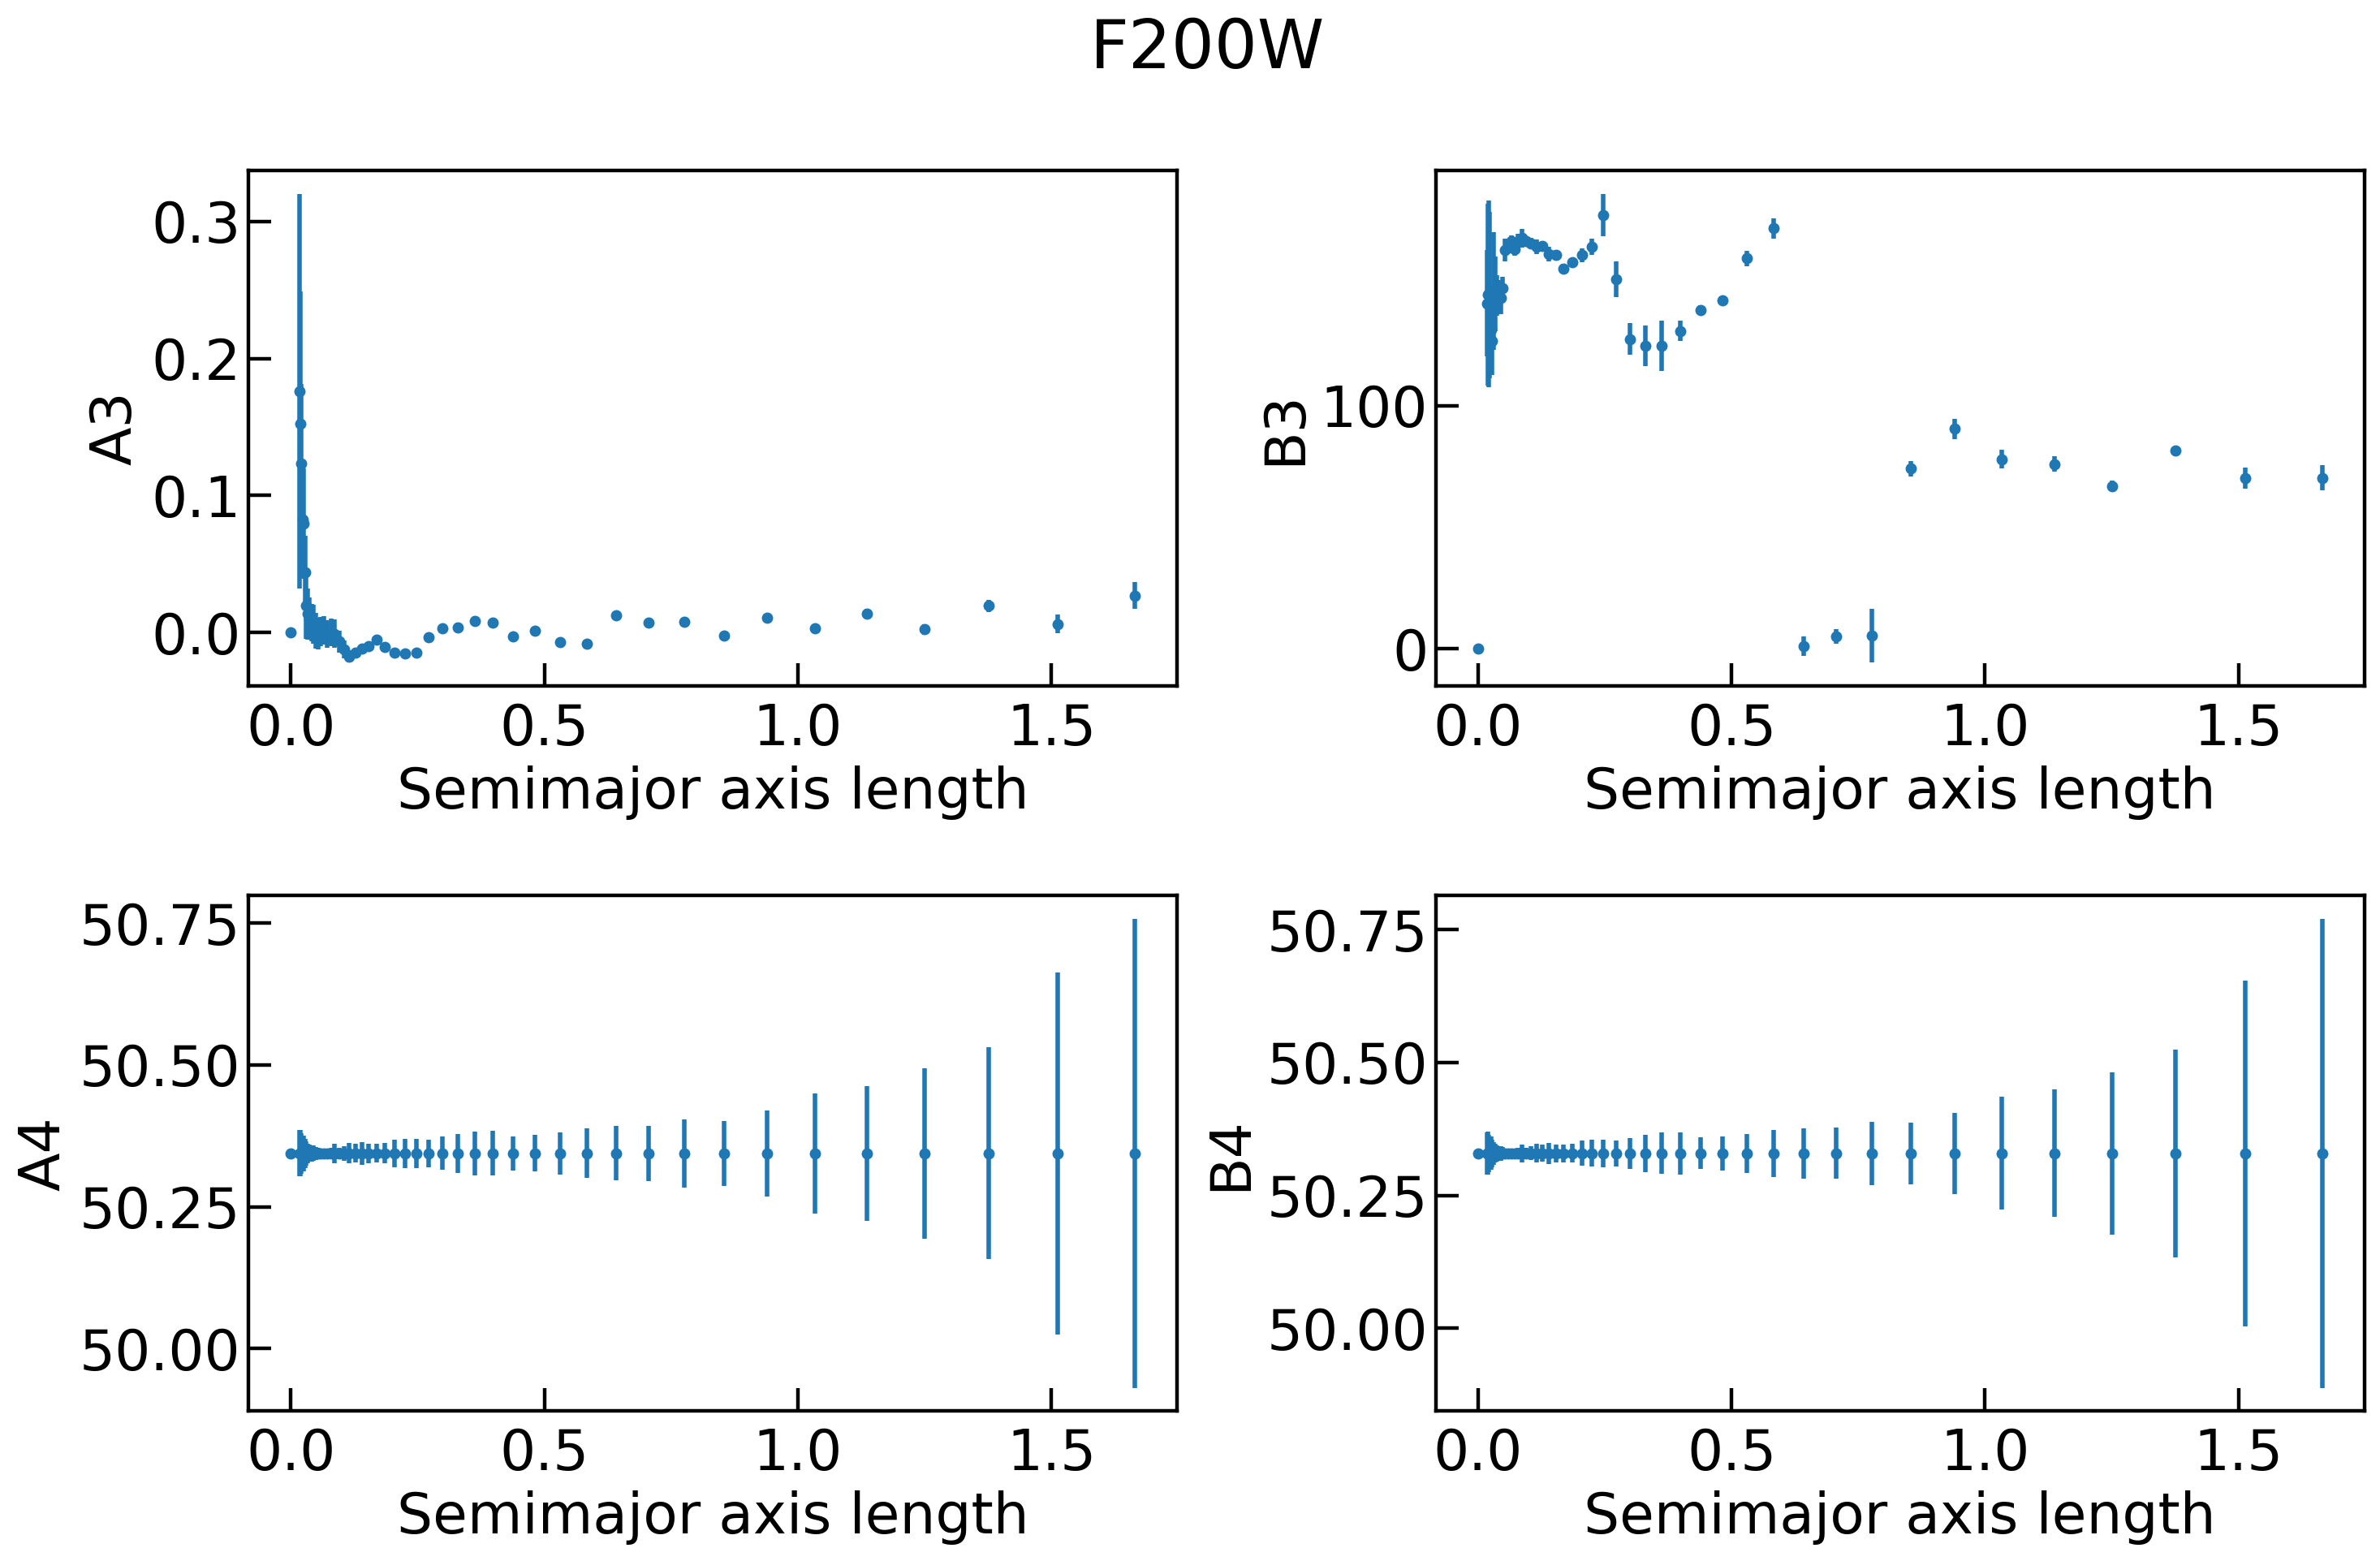

In [14]:
from astropy.visualization import ZScaleInterval
ZInterval = ZScaleInterval()
#cutoutnames, modnames, resnames
for ii in range(len(modnames)):
    cutind = fits.open(cutoutnames[ii])[1].data
    modind = fits.open(modnames[ii])[1].data
    resind = fits.open(resnames[ii])[1].data
    isoind = isolist[ii]
    tabind = fittabs[ii]

    ZInterval = ZScaleInterval()
    vmin, vmax = ZInterval.get_limits(cutind)
    fig, axes = plt.subplots(2, 2, figsize = (15, 10))
    fig.suptitle(f'{filters[ii]}')
   
   
    axes[0,0].errorbar(tabind['sma_arcsec'], isoind.a3, yerr=isoind.a3_err, fmt='o', markersize=4)
    axes[0,0].set_xlabel('Semimajor axis length')
    axes[0,0].set_ylabel('A3')
    
    axes[0,1].errorbar(tabind['sma_arcsec'], isoind.pa/np.pi*180., yerr=isoind.pa_err/np.pi* 80., fmt='o', markersize=4)
    axes[0,1].set_xlabel('Semimajor axis length')
    axes[0,1].set_ylabel('B3')

    
    axes[1,0].errorbar(tabind['sma_arcsec'], isoind.x0, yerr=isoind.x0_err, fmt='o', markersize=4)
    axes[1,0].set_xlabel('Semimajor axis length')
    axes[1,0].set_ylabel('A4')

    
    axes[1,1].errorbar(tabind['sma_arcsec'], isoind.y0, yerr=isoind.y0_err, fmt='o', markersize=4)
    axes[1,1].set_xlabel('Semimajor axis length')
    axes[1,1].set_ylabel('B4')

    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

    plt.tight_layout()
    plt.show()
    plt.close()

## Final Data Model Residual 

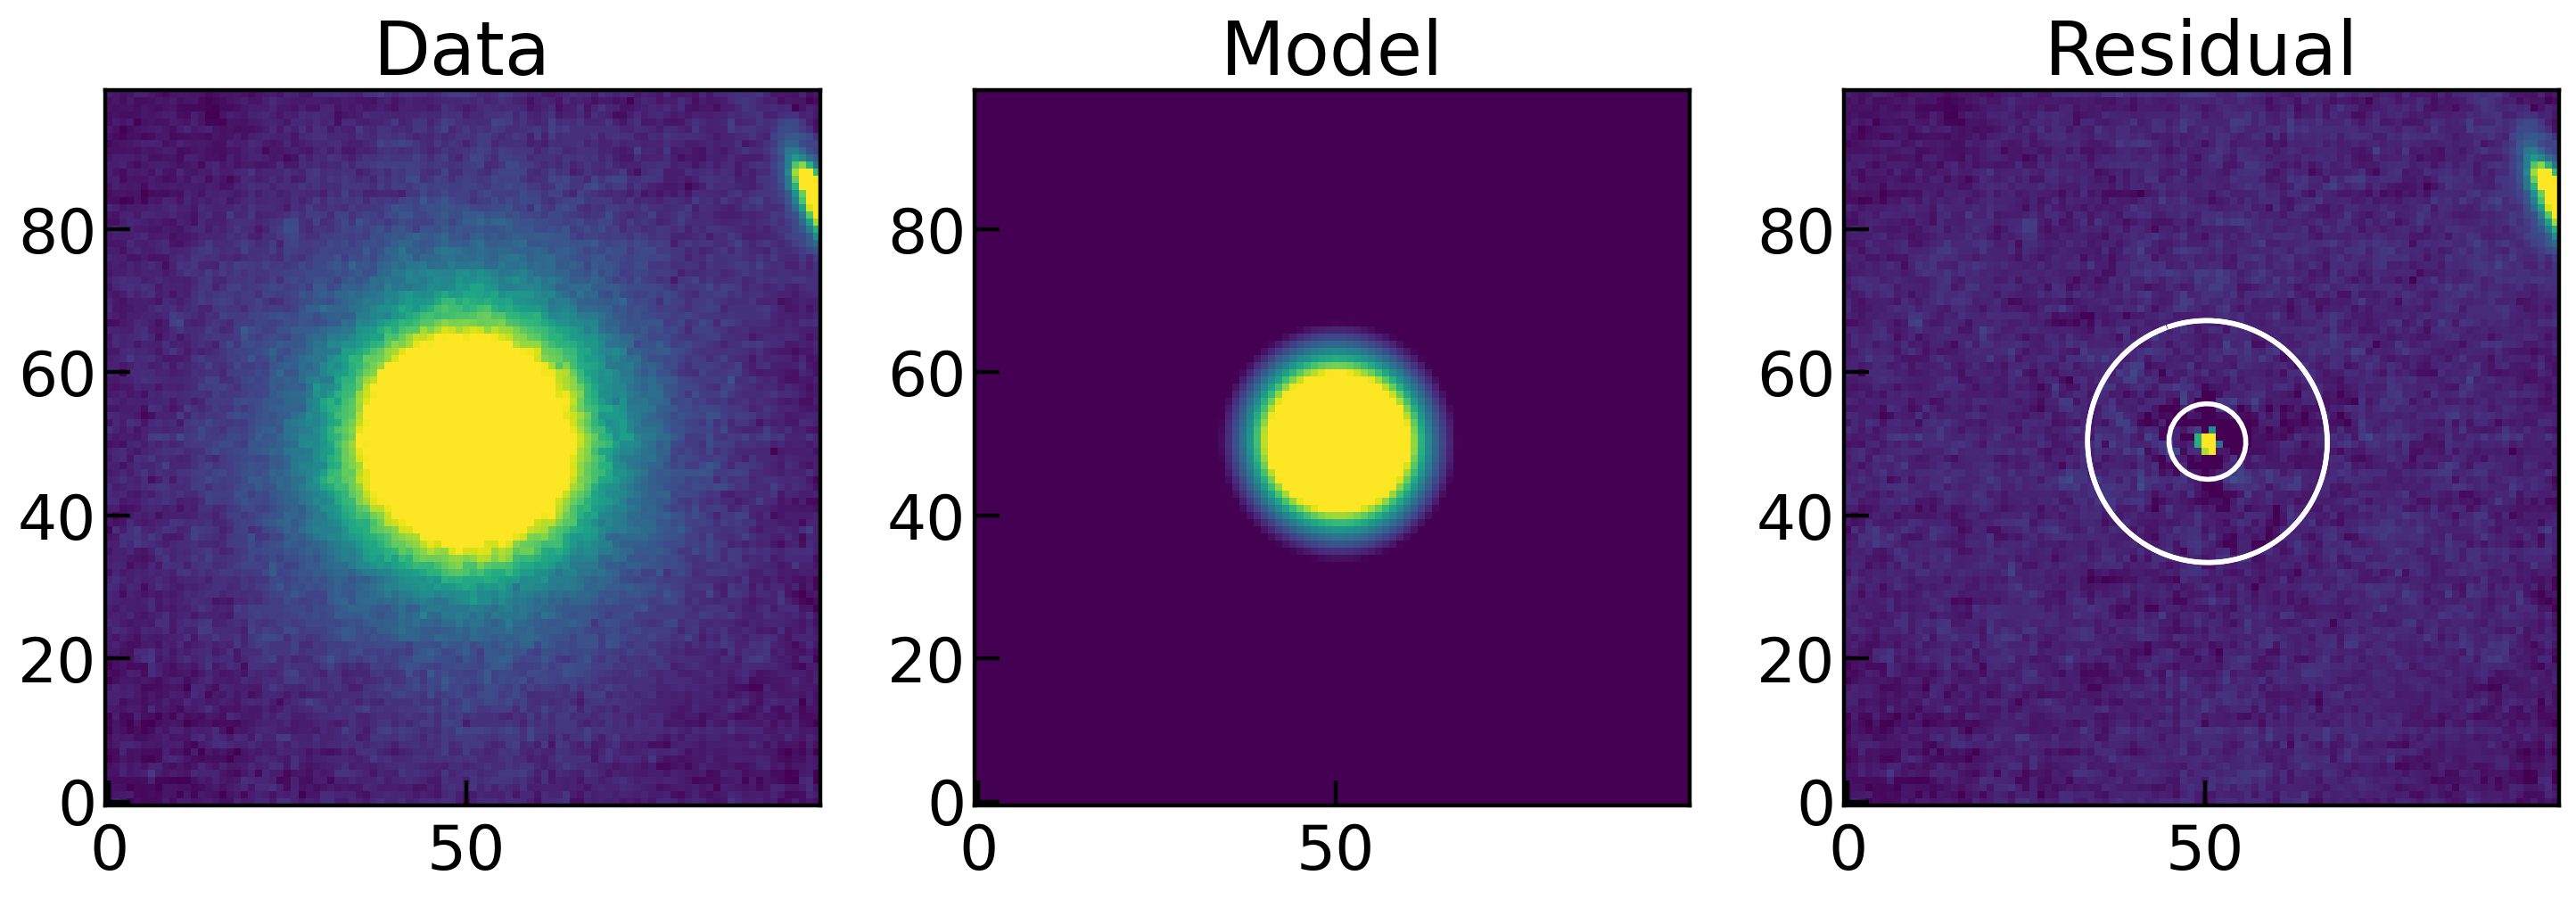

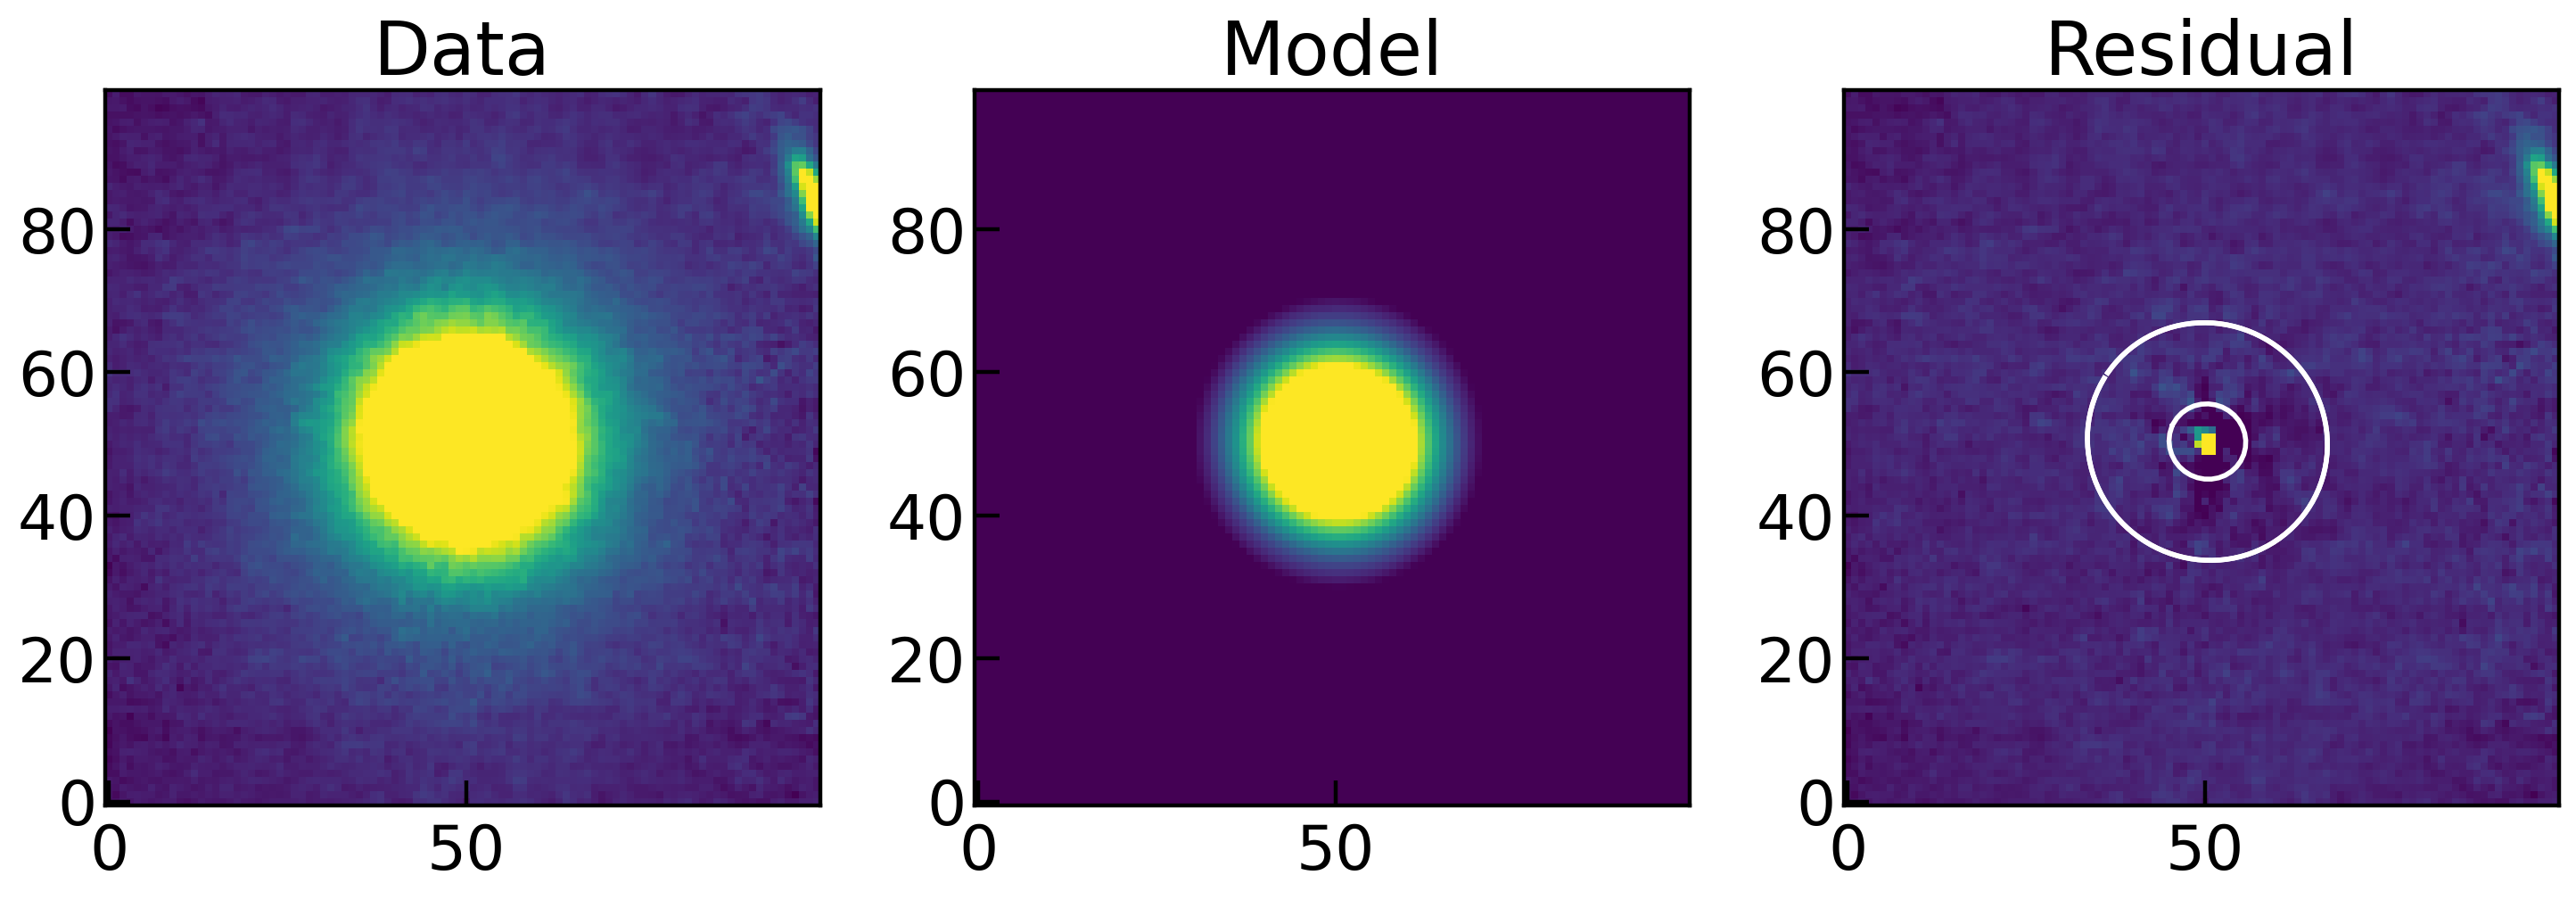

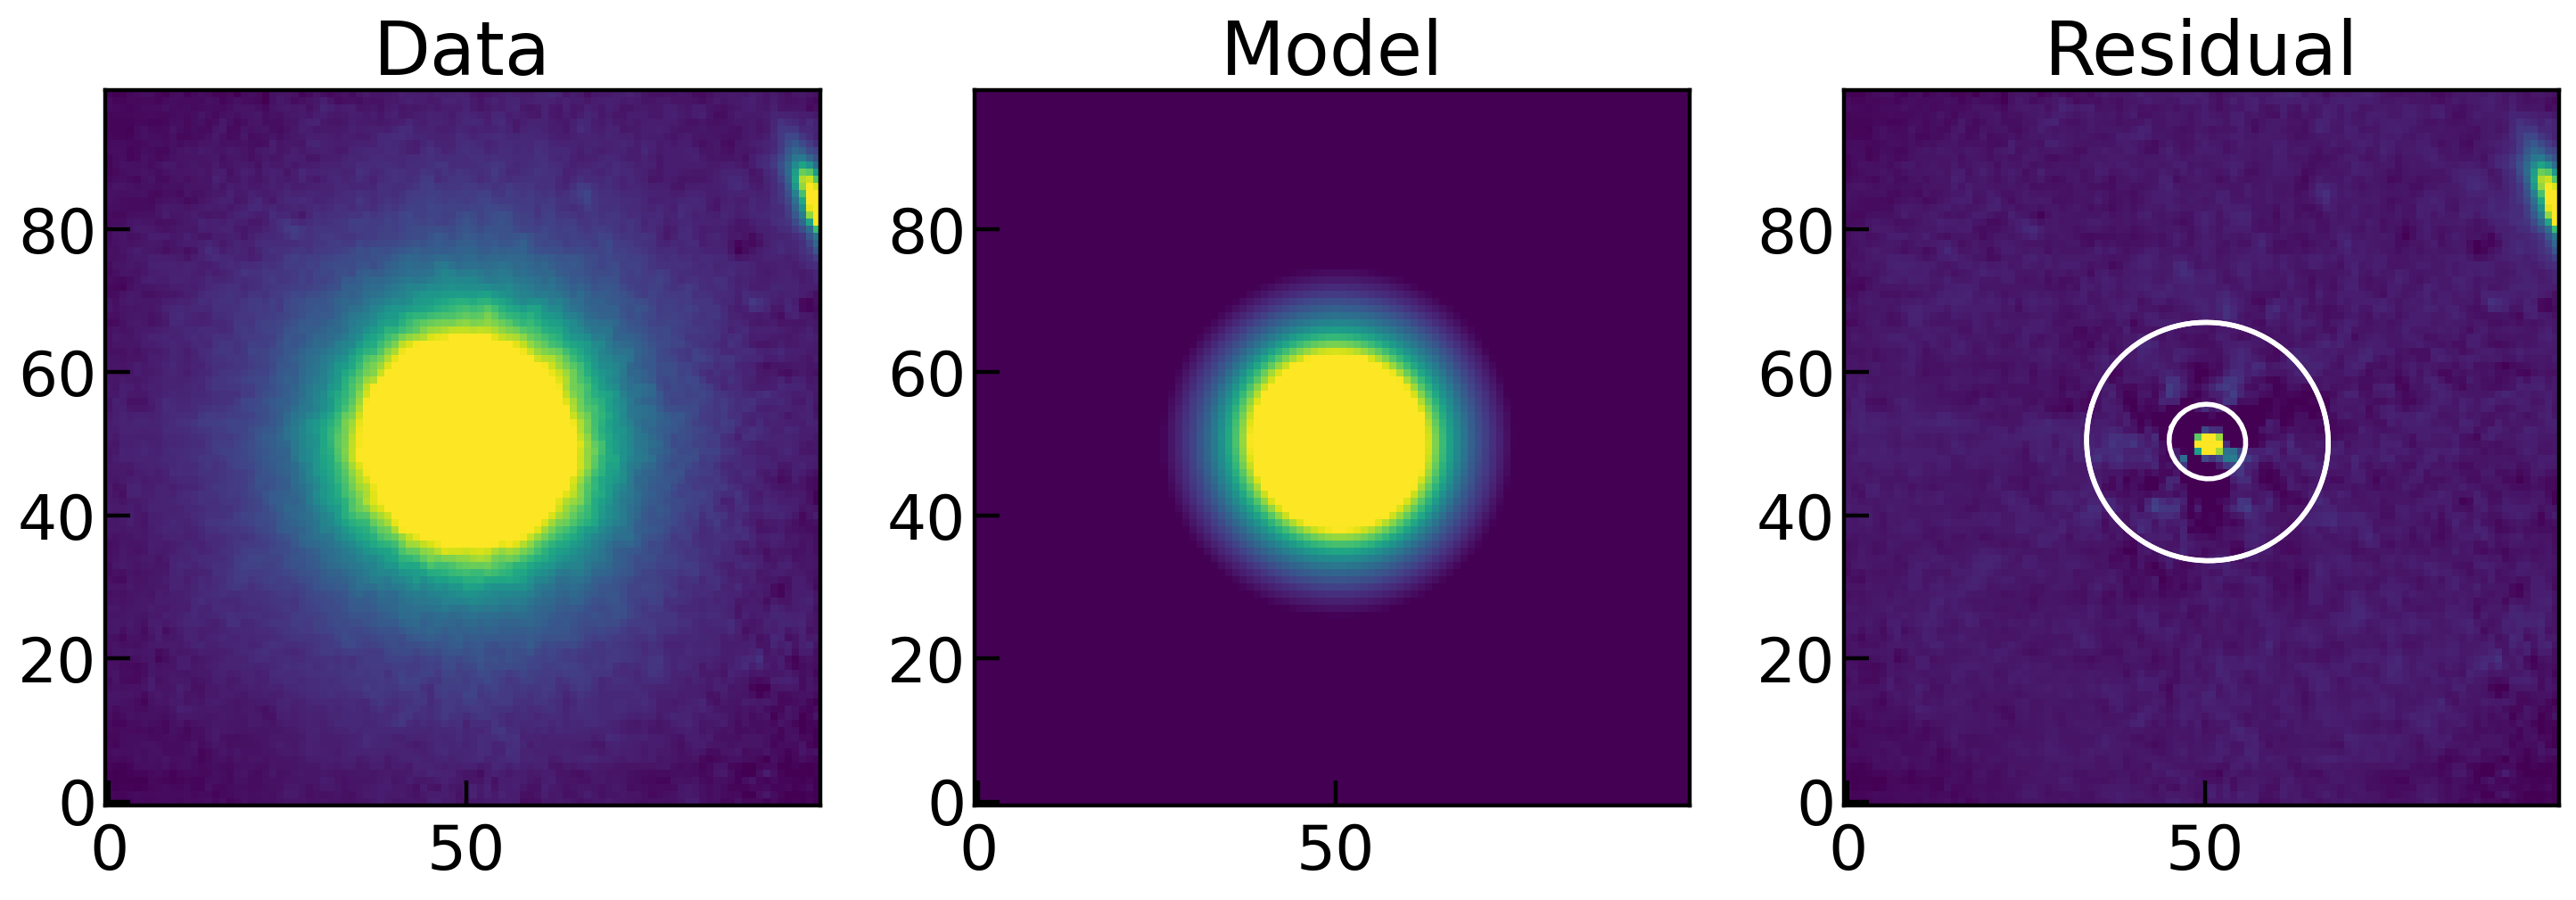

In [15]:
from astropy.visualization import ZScaleInterval
ZInterval = ZScaleInterval()
#cutoutnames, modnames, resnames
for ii in range(len(modnames)):
    cutind = fits.open(cutoutnames[ii])[1].data
    modind = fits.open(modnames[ii])[1].data
    resind = fits.open(resnames[ii])[1].data
    isoind = isolist[ii]

    ZInterval = ZScaleInterval()
    vmin, vmax = ZInterval.get_limits(cutind)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

    ax1.imshow(cutind, vmin=vmin, vmax=vmax)

    ax1.set_title("Data")

    ax2.imshow(modind, vmin=vmin, vmax=vmax)

    ax2.set_title("Model")

    ax3.imshow(resind, vmin=vmin, vmax=vmax)

    ax3.set_title("Residual")

    iso1 = isoind.get_closest(np.quantile(isoind.sma, 0.5))
    iso2 = isoind.get_closest(np.quantile(isoind.sma, 0.75))
    iso3 = isoind.get_closest(np.quantile(isoind.sma, 0.95))    
    
    xd1, yd1 = iso1.sampled_coordinates()
    ax3.plot(xd1, yd1, color='white')

    xd2, yd2 = iso2.sampled_coordinates()
    ax3.plot(xd2, yd2, color='white')    
    
    xd3, yd3 = iso3.sampled_coordinates()
    ax3.plot(xd2, yd2, color='white')



    plt.tight_layout()
    plt.show()
    plt.close()

fitref = fittabs[0]
plt.figure(figsize=(8, 4))
plt.scatter(fitref['sma']**0.25, -2.5*np.log10(fitref['intens']))
plt.xlabel('sma**1/4')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()View Fits header in originla image 

Photometry Information 

JWST Image physical unit of the array values are MJy/sr 

but we have flux density producing 1cps in / nominal pixel area in photometry inofmation
 
 이를 통해서 pixel value (Mjy/sr)

==> 결국 Jy/arcsec 단위로 변환하고 

nominal pixel area를 통해 한 pixel이 어떤 arcsec를 갖는 지를 이용한 변환을 진행하면 
Flux, intensity 구할 수 있따. 

zp또 따로 구한다. 

example1

# 4. Total Analysis

/tmp/ipykernel_26143/652543726.py:16: RuntimeWarning: invalid value encountered in log10
  axes.scatter(tabind['sma_arcsec']**0.25, -2.5*np.log10(isoind.intens), label=f'{filters[ii]}')


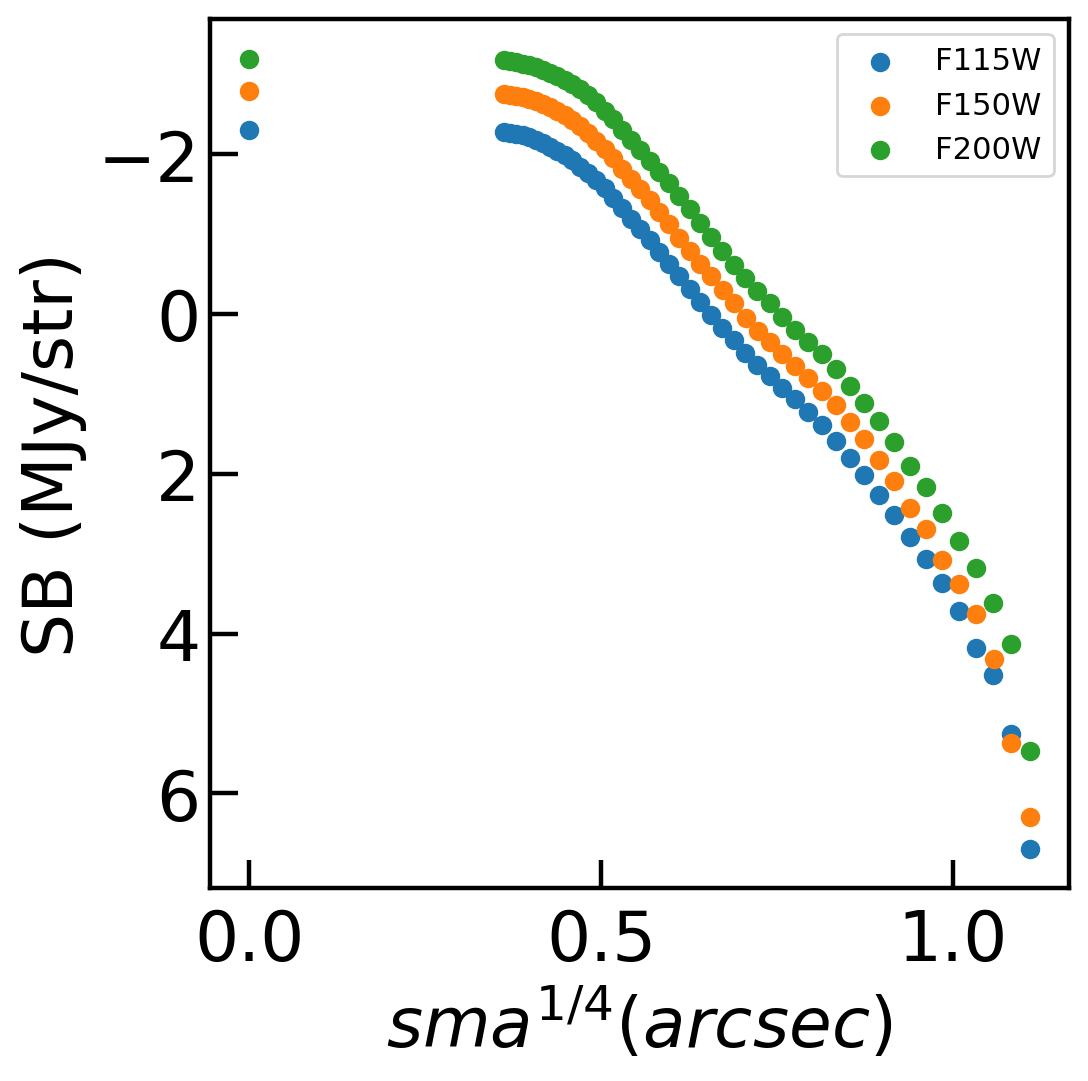

In [16]:
from astropy.visualization import ZScaleInterval
ZInterval = ZScaleInterval()
#cutoutnames, modnames, resnames
fig, axes = plt.subplots(1, 1, figsize = (6, 6))

axes.set_xlabel('${sma}^{1/4} (arcsec)$')
axes.set_ylabel('SB (MJy/str)')

for ii in range(len(modnames)):
    cutind = fits.open(cutoutnames[ii])[1].data
    modind = fits.open(modnames[ii])[1].data
    resind = fits.open(resnames[ii])[1].data
    isoind = isolist[ii]
    tabind = fittabs[ii]
  
    axes.scatter(tabind['sma_arcsec']**0.25, -2.5*np.log10(isoind.intens), label=f'{filters[ii]}')
    axes.invert_yaxis()

    plt.tight_layout()
    plt.legend(fontsize=11)

/tmp/ipykernel_26143/1621873146.py:17: RuntimeWarning: invalid value encountered in log10
  axes.scatter(tabind['sma_arcsec'], -2.5*np.log10(isoind.intens), label=f'{filters[ii]}')


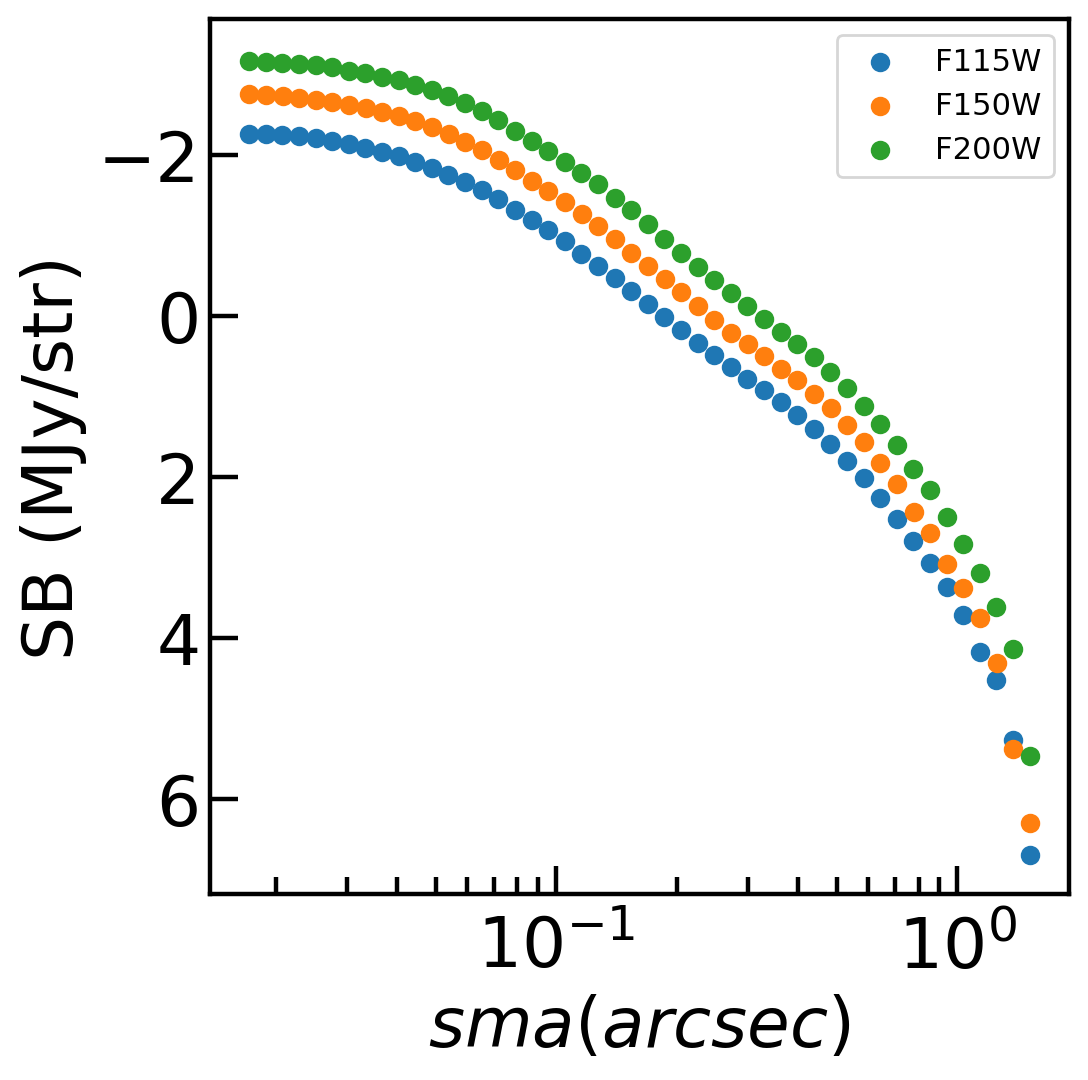

In [17]:
from astropy.visualization import ZScaleInterval
ZInterval = ZScaleInterval()
#cutoutnames, modnames, resnames
fig, axes = plt.subplots(1, 1, figsize = (6, 6))

axes.set_xlabel('${sma} (arcsec)$')
axes.set_ylabel('SB (MJy/str)')
axes.set_xscale('log')

for ii in range(len(modnames)):
    cutind = fits.open(cutoutnames[ii])[1].data
    modind = fits.open(modnames[ii])[1].data
    resind = fits.open(resnames[ii])[1].data
    isoind = isolist[ii]
    tabind = fittabs[ii]
  
    axes.scatter(tabind['sma_arcsec'], -2.5*np.log10(isoind.intens), label=f'{filters[ii]}')
    axes.invert_yaxis()

    plt.tight_layout()
    plt.legend(fontsize=11)

## Angle and Intensity 

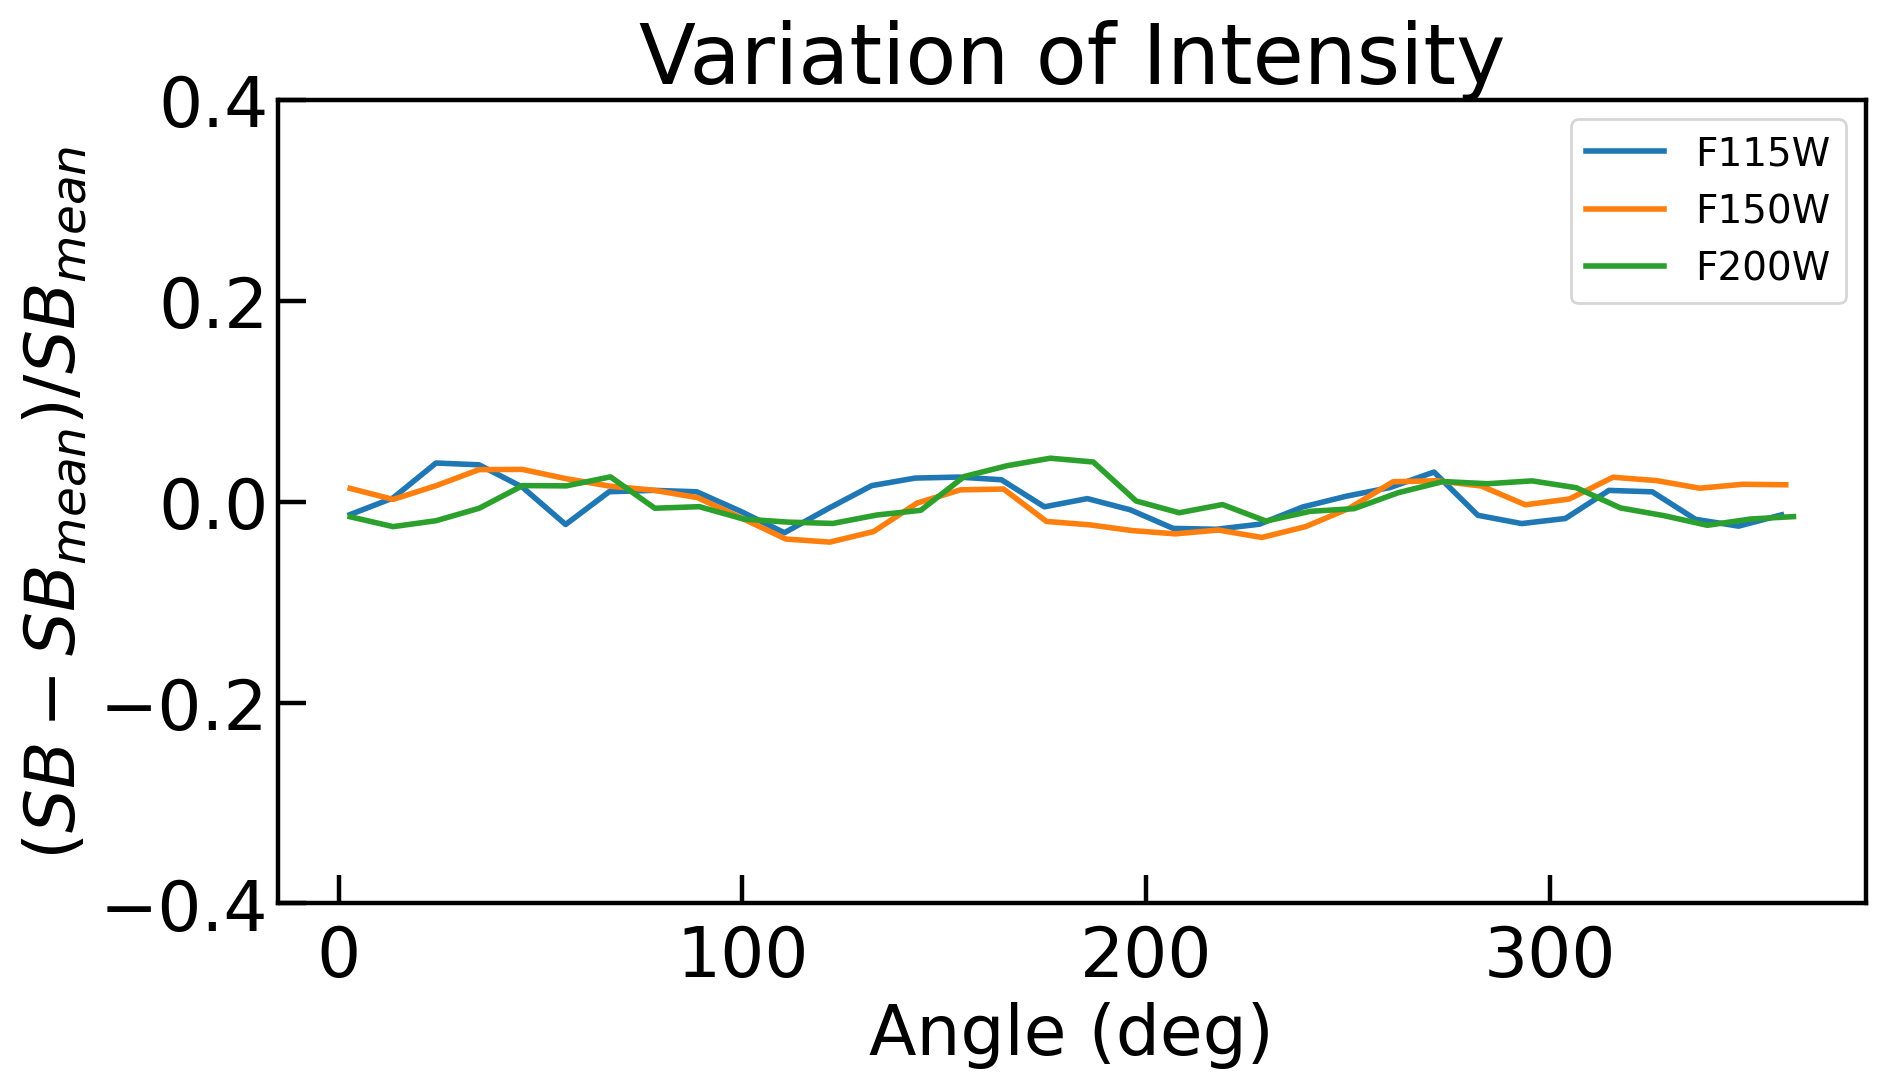

In [18]:
#cutoutnames, modnames, resnames
fig, axes = plt.subplots(1, 1, figsize = (10, 6))

axes.set_ylabel("$(SB- SB_{mean}$)/$SB_{mean}$")
axes.set_xlabel("Angle (deg)")
axes.set_title('Variation of Intensity')
axes.set_ylim(-0.4, 0.4)

for ii in range(len(modnames)):
    cutind = fits.open(cutoutnames[ii])[1].data
    modind = fits.open(modnames[ii])[1].data
    resind = fits.open(resnames[ii])[1].data
    isoind = isolist[ii]
    
    iso = isoind.get_closest(np.median(isoind.sma))
    xd, yd = iso.sampled_coordinates()
   
    axes.plot(iso.sample.values[0] / np.pi*180., (iso.sample.values[2]-np.mean(iso.sample.values[2]))/np.mean(iso.sample.values[2]), label=f'{filters[ii]}')

    plt.tight_layout()
    
plt.legend(fontsize=14)

## Elliptical Feature and others

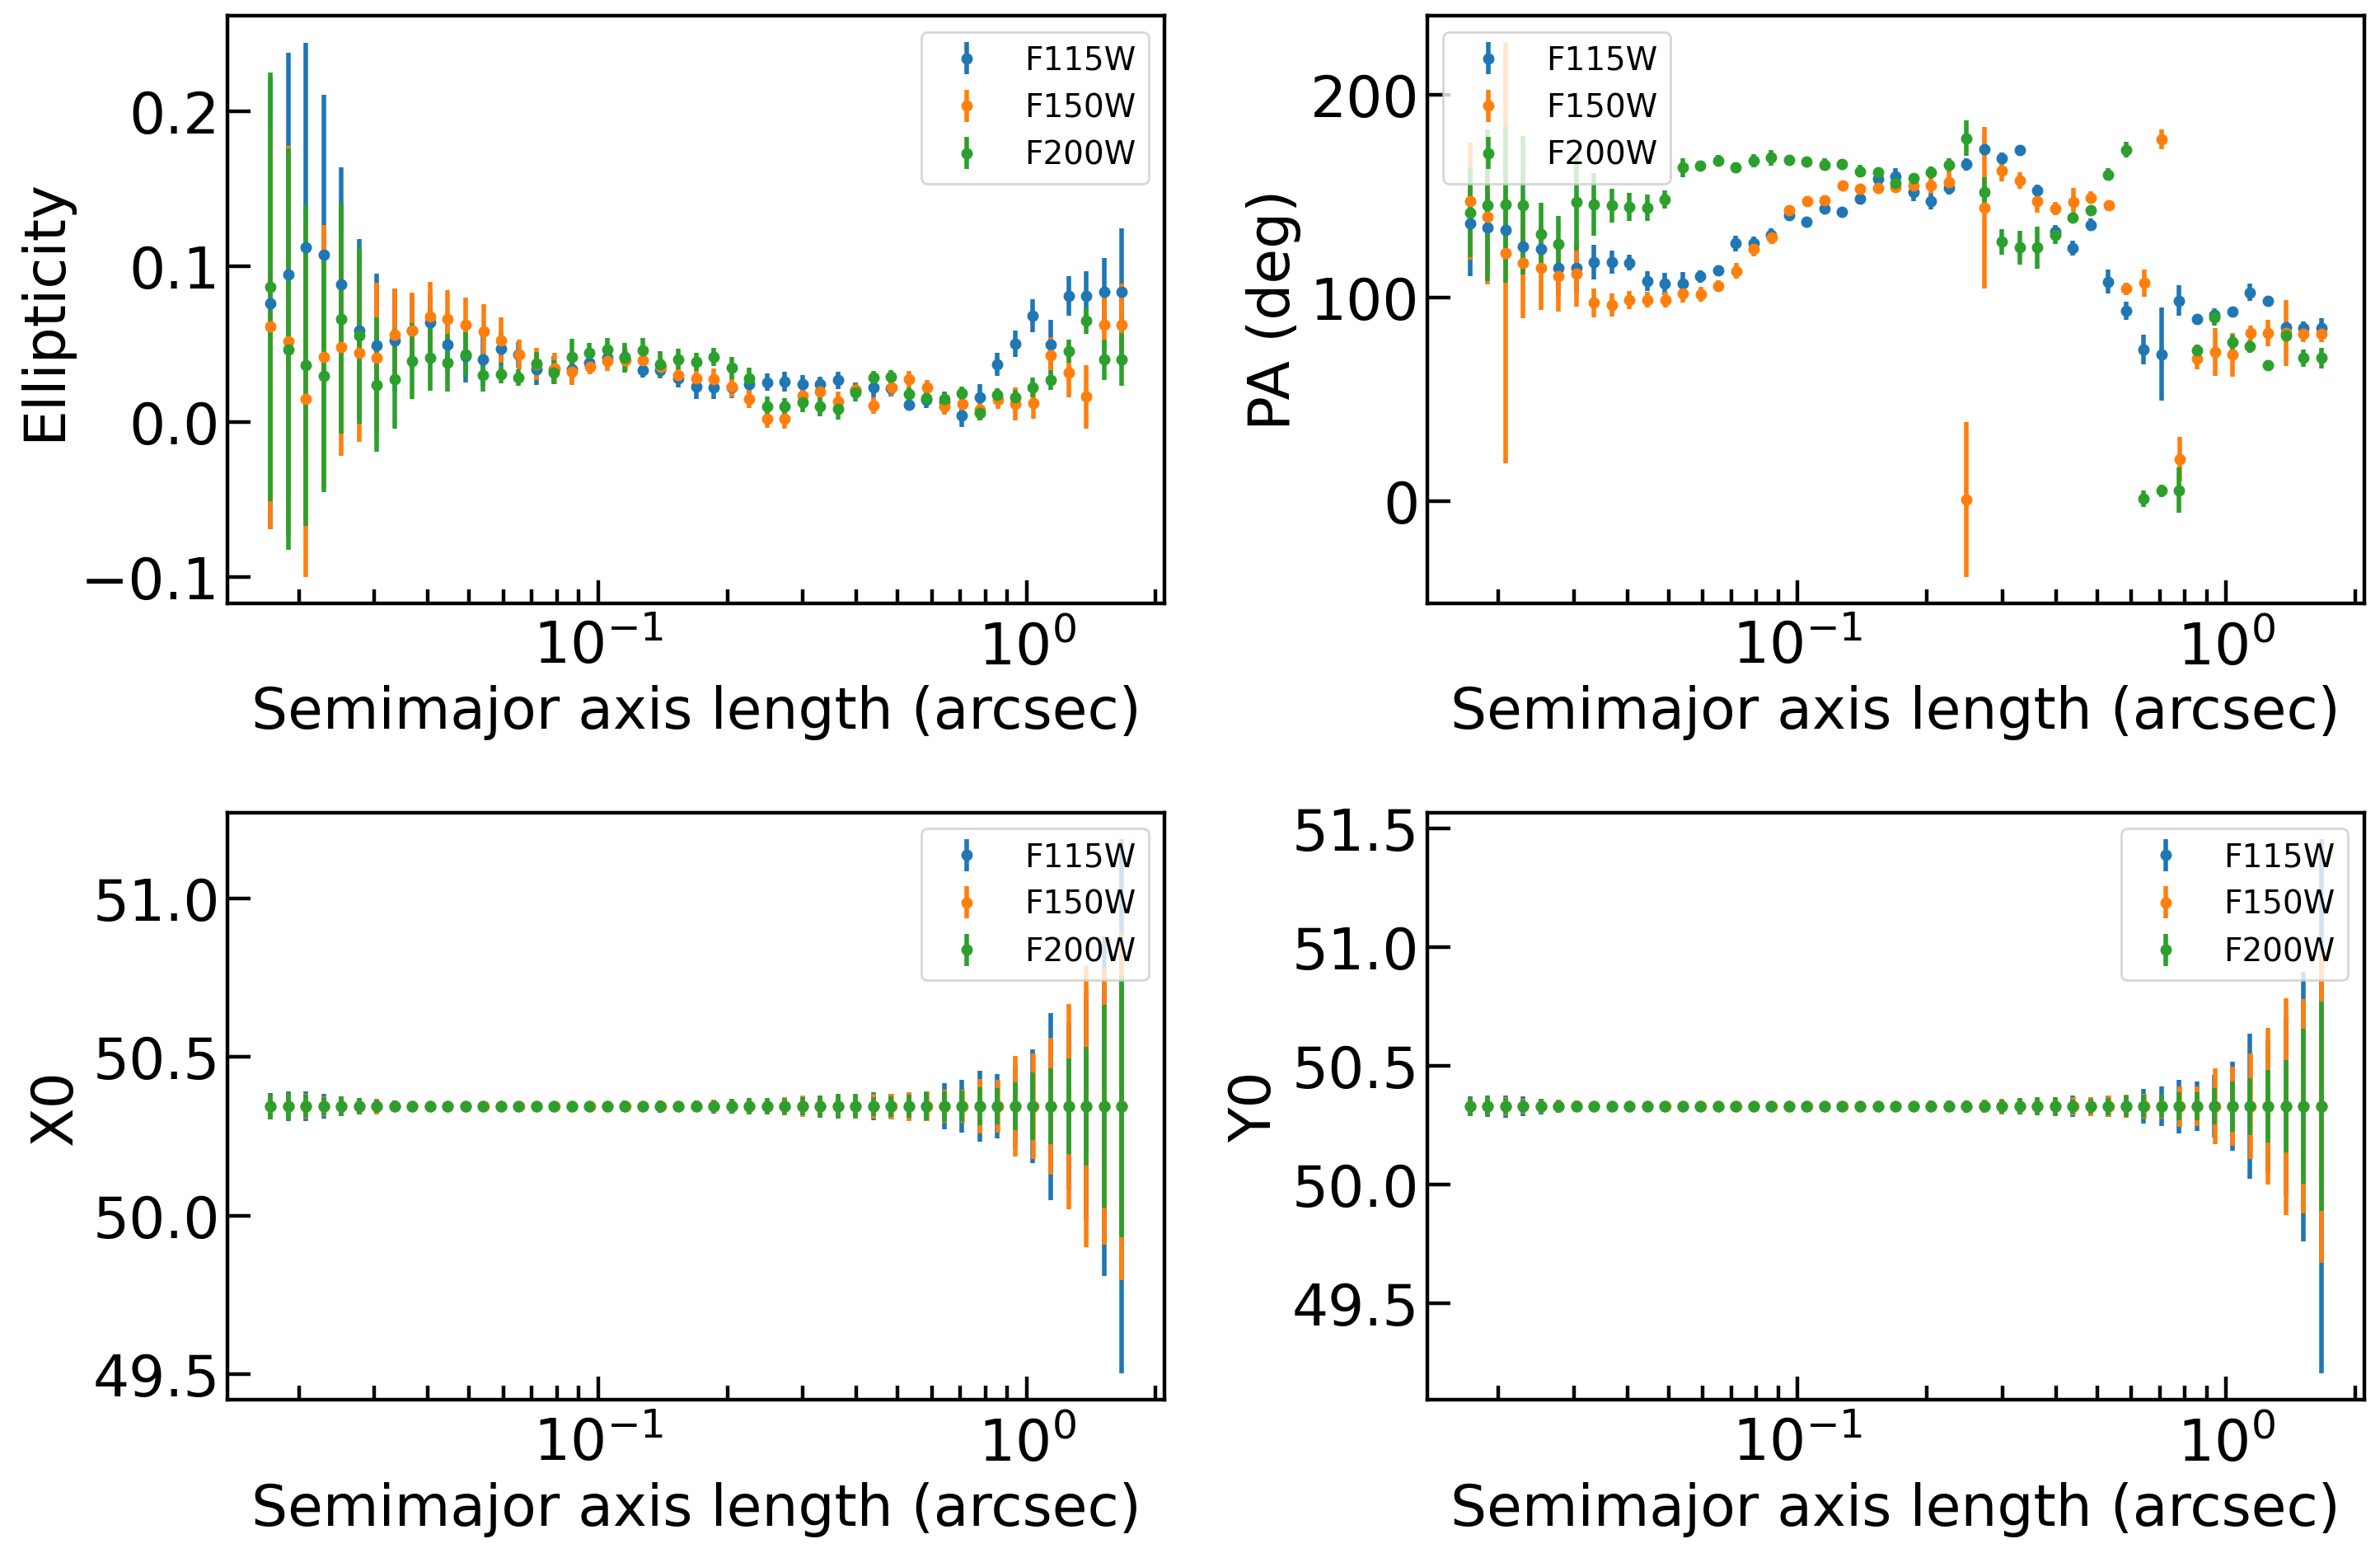

In [19]:
from astropy.visualization import ZScaleInterval
#cutoutnames, modnames, resnames
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

x0finder = []
y0finder = []

for ii in range(len(modnames)):
    cutind = fits.open(cutoutnames[ii])[1].data
    modind = fits.open(modnames[ii])[1].data
    resind = fits.open(resnames[ii])[1].data
    isoind = isolist[ii]
    tabind = fittabs[ii]
 
   
    axes[0,0].errorbar(tabind['sma_arcsec'], isoind.eps, yerr=isoind.ellip_err, fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[0,0].set_xlabel('Semimajor axis length (arcsec)')
    axes[0,0].set_ylabel('Ellipticity')
    axes[0,0].set_xscale('log')
    axes[0,0].legend(fontsize=14)
    
    axes[0,1].errorbar(tabind['sma_arcsec'], isoind.pa/np.pi*180., yerr=isoind.pa_err/np.pi* 80., fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[0,1].set_xlabel('Semimajor axis length (arcsec)')
    axes[0,1].set_ylabel('PA (deg)')
    axes[0,1].set_xscale('log')
    axes[0,1].legend(fontsize=14)
    
    axes[1,0].errorbar(tabind['sma_arcsec'], isoind.x0, yerr=isoind.x0_err, fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[1,0].set_xlabel('Semimajor axis length (arcsec)')
    axes[1,0].set_ylabel('X0')
    axes[1,0].legend(fontsize=14)
    axes[1,0].set_xscale('log')
    # axes[1,0].axhline(np.median(isoind.x0), color='red', ls='--', lw=2)
    
    axes[1,1].errorbar(tabind['sma_arcsec'], isoind.y0, yerr=isoind.y0_err, fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[1,1].set_xlabel('Semimajor axis length (arcsec)')
    axes[1,1].set_ylabel('Y0')
    axes[1,1].legend(fontsize=14)
    axes[1,1].set_xscale('log')
    # axes[1,1].axhline(np.median(isoind.y0), color='red', ls='--', lw=2)

    x0finder.append(np.median(isoind.x0))
    y0finder.append(np.median(isoind.y0))
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)
    plt.tight_layout()


In [20]:
print(f"The Truth X0 Value is {np.mean(x0finder)}")
print(f"The Truth Y0 Value is {np.mean(y0finder)}")

The Truth X0 Value is 50.344
The Truth Y0 Value is 50.329


## Get a true center point in galaxy image with ellipse fitting  + fix_center=True

## And Put the X0 / Y0 Value into True center in Ellipse Geometry

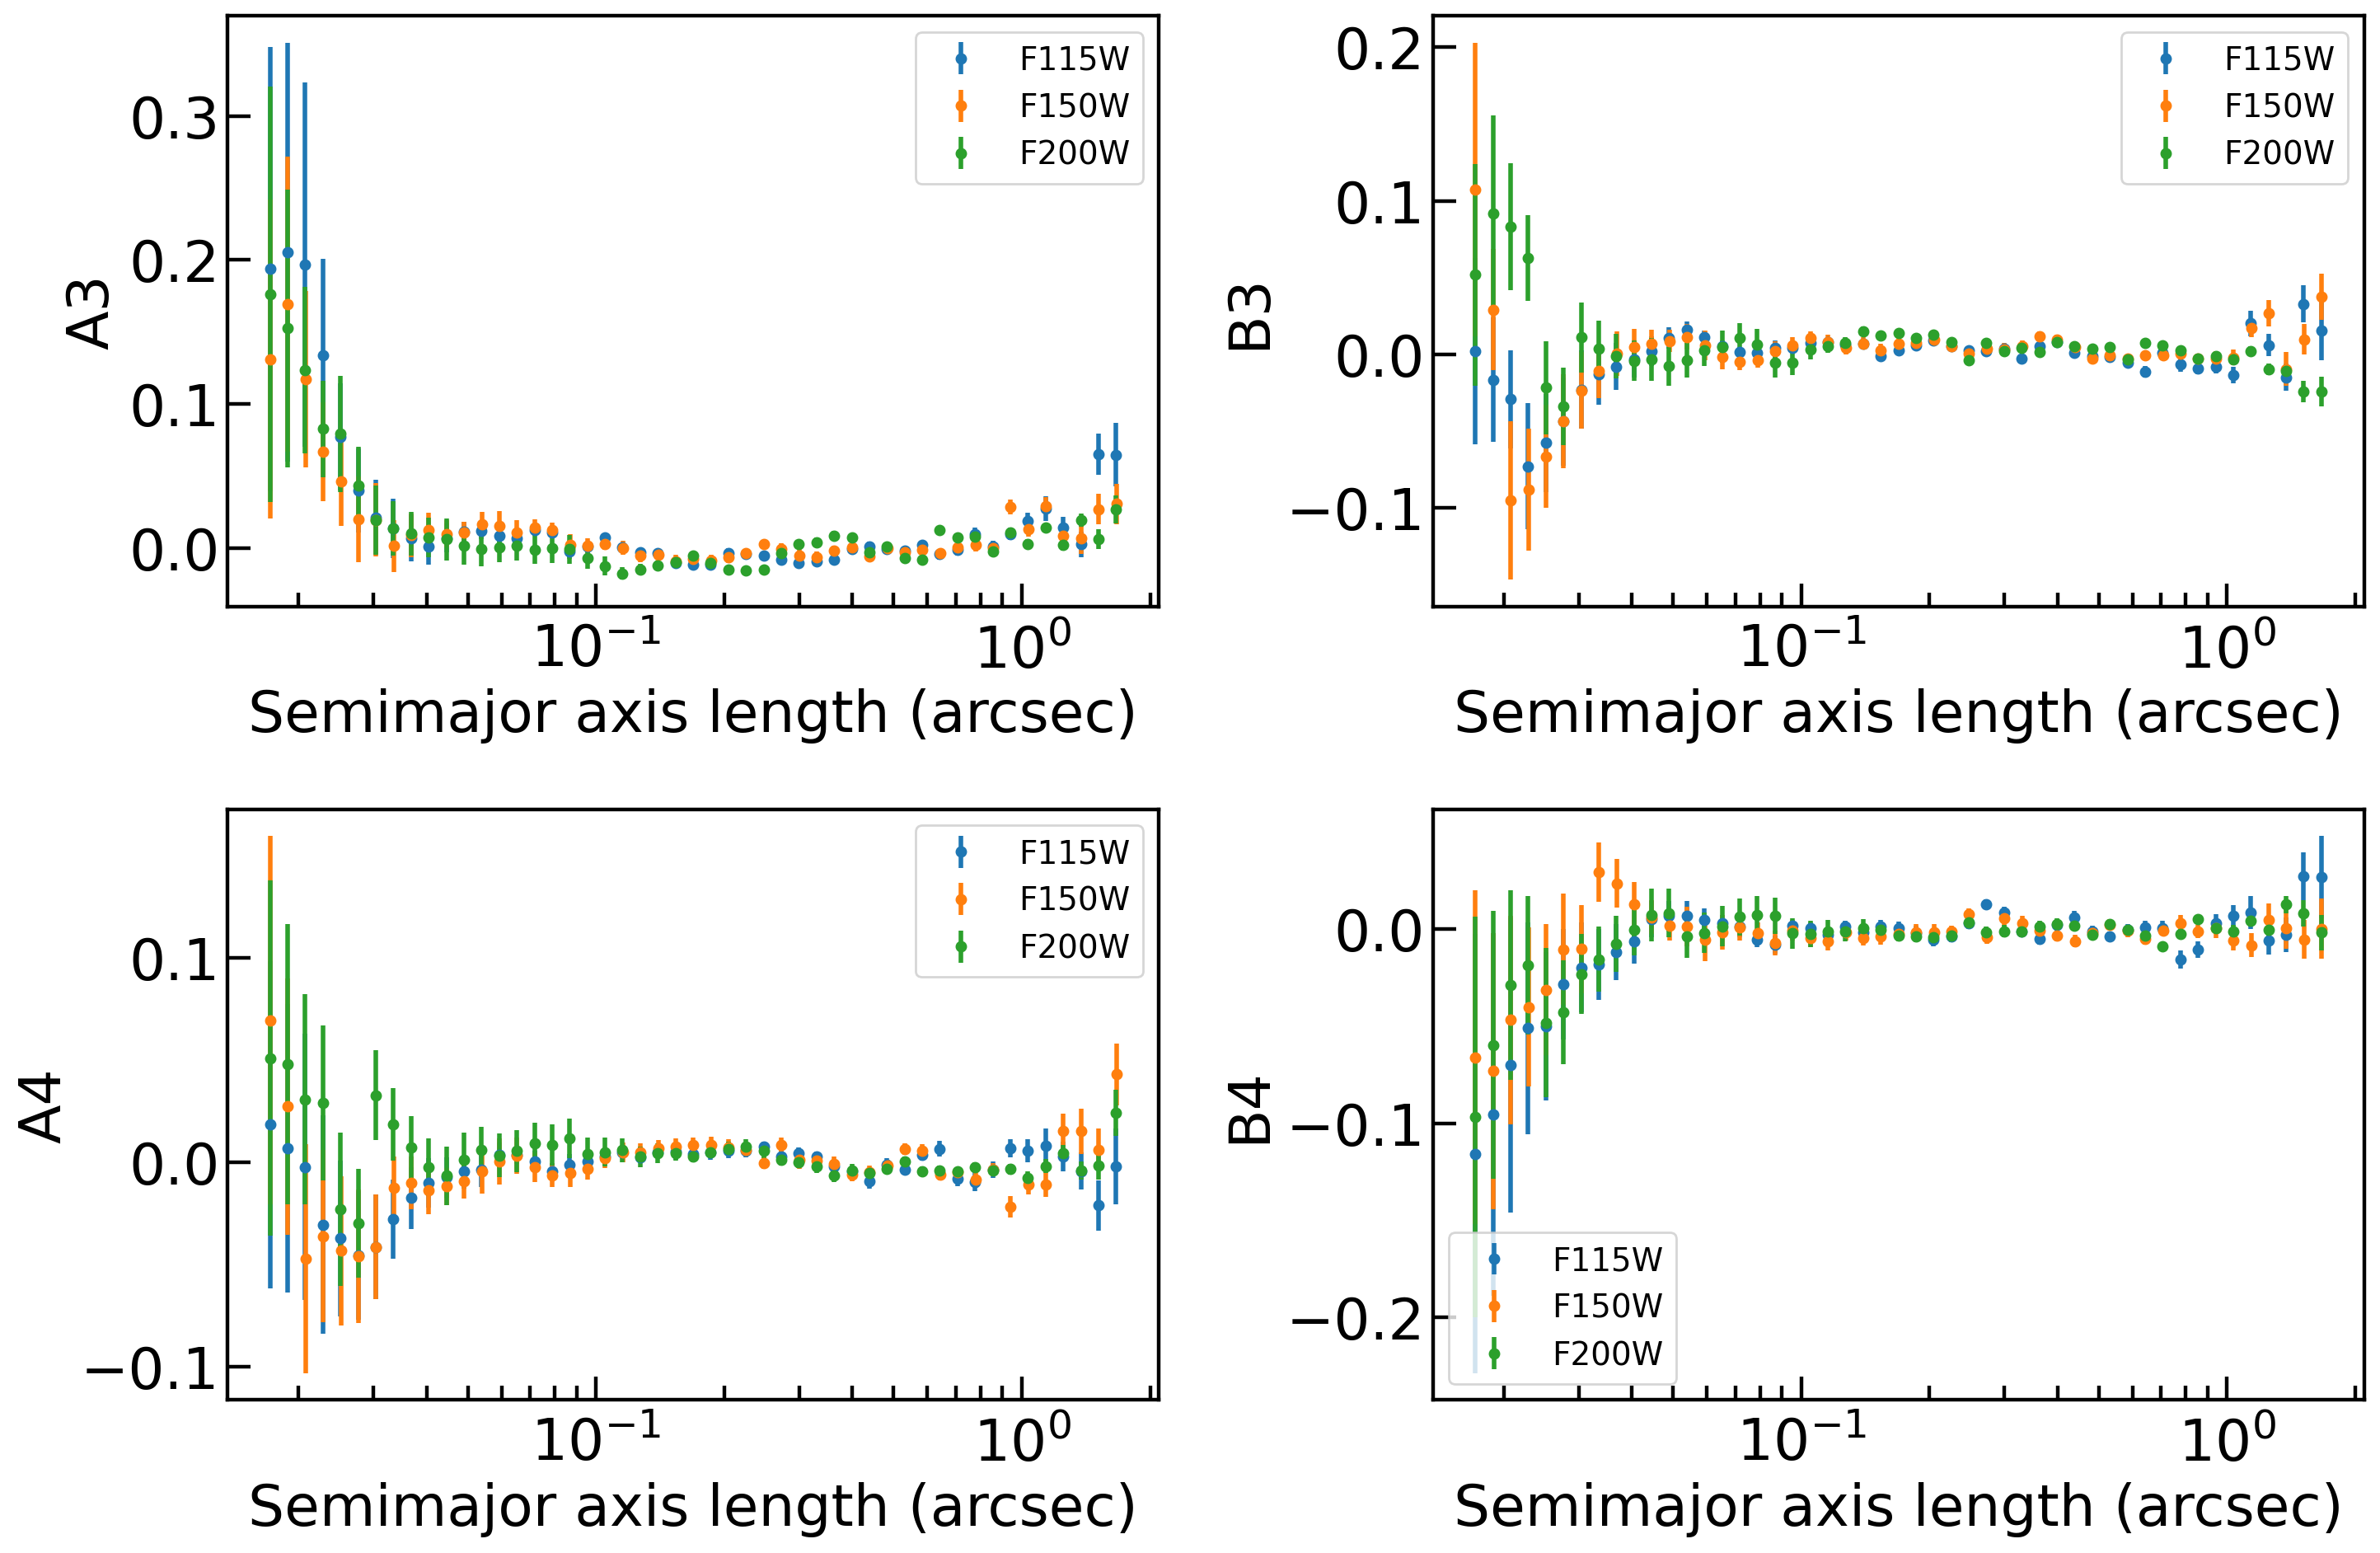

In [21]:
from astropy.visualization import ZScaleInterval
#cutoutnames, modnames, resnames
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

for ii in range(len(modnames)):
    cutind = fits.open(cutoutnames[ii])[1].data
    modind = fits.open(modnames[ii])[1].data
    resind = fits.open(resnames[ii])[1].data
    isoind = isolist[ii]
    tabind = fittabs[ii]
    
    axes[0,0].errorbar(tabind['sma_arcsec'], isoind.a3, yerr=isoind.a3_err, fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[0,0].set_xlabel('Semimajor axis length (arcsec)')
    axes[0,0].set_ylabel('A3')
    axes[0,0].legend(fontsize=14)
    axes[0,0].set_xscale('log')
    
    axes[0,1].errorbar(tabind['sma_arcsec'], isoind.b3, yerr=isoind.b3_err, fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[0,1].set_xlabel('Semimajor axis length (arcsec)')
    axes[0,1].set_ylabel('B3')
    axes[0,1].legend(fontsize=14)
    axes[0,1].set_xscale('log')
    
    axes[1,0].errorbar(tabind['sma_arcsec'], isoind.a4, yerr=isoind.a4_err, fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[1,0].set_xlabel('Semimajor axis length (arcsec)')
    axes[1,0].set_ylabel('A4')
    axes[1,0].legend(fontsize=14)
    axes[1,0].set_xscale('log')
  
    axes[1,1].errorbar(tabind['sma_arcsec'], isoind.b4, yerr=isoind.b4_err, fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[1,1].set_xlabel('Semimajor axis length (arcsec)')
    axes[1,1].set_ylabel('B4')
    axes[1,1].legend(fontsize=14)
    axes[1,1].set_xscale('log')

    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)
    plt.tight_layout()


core plot

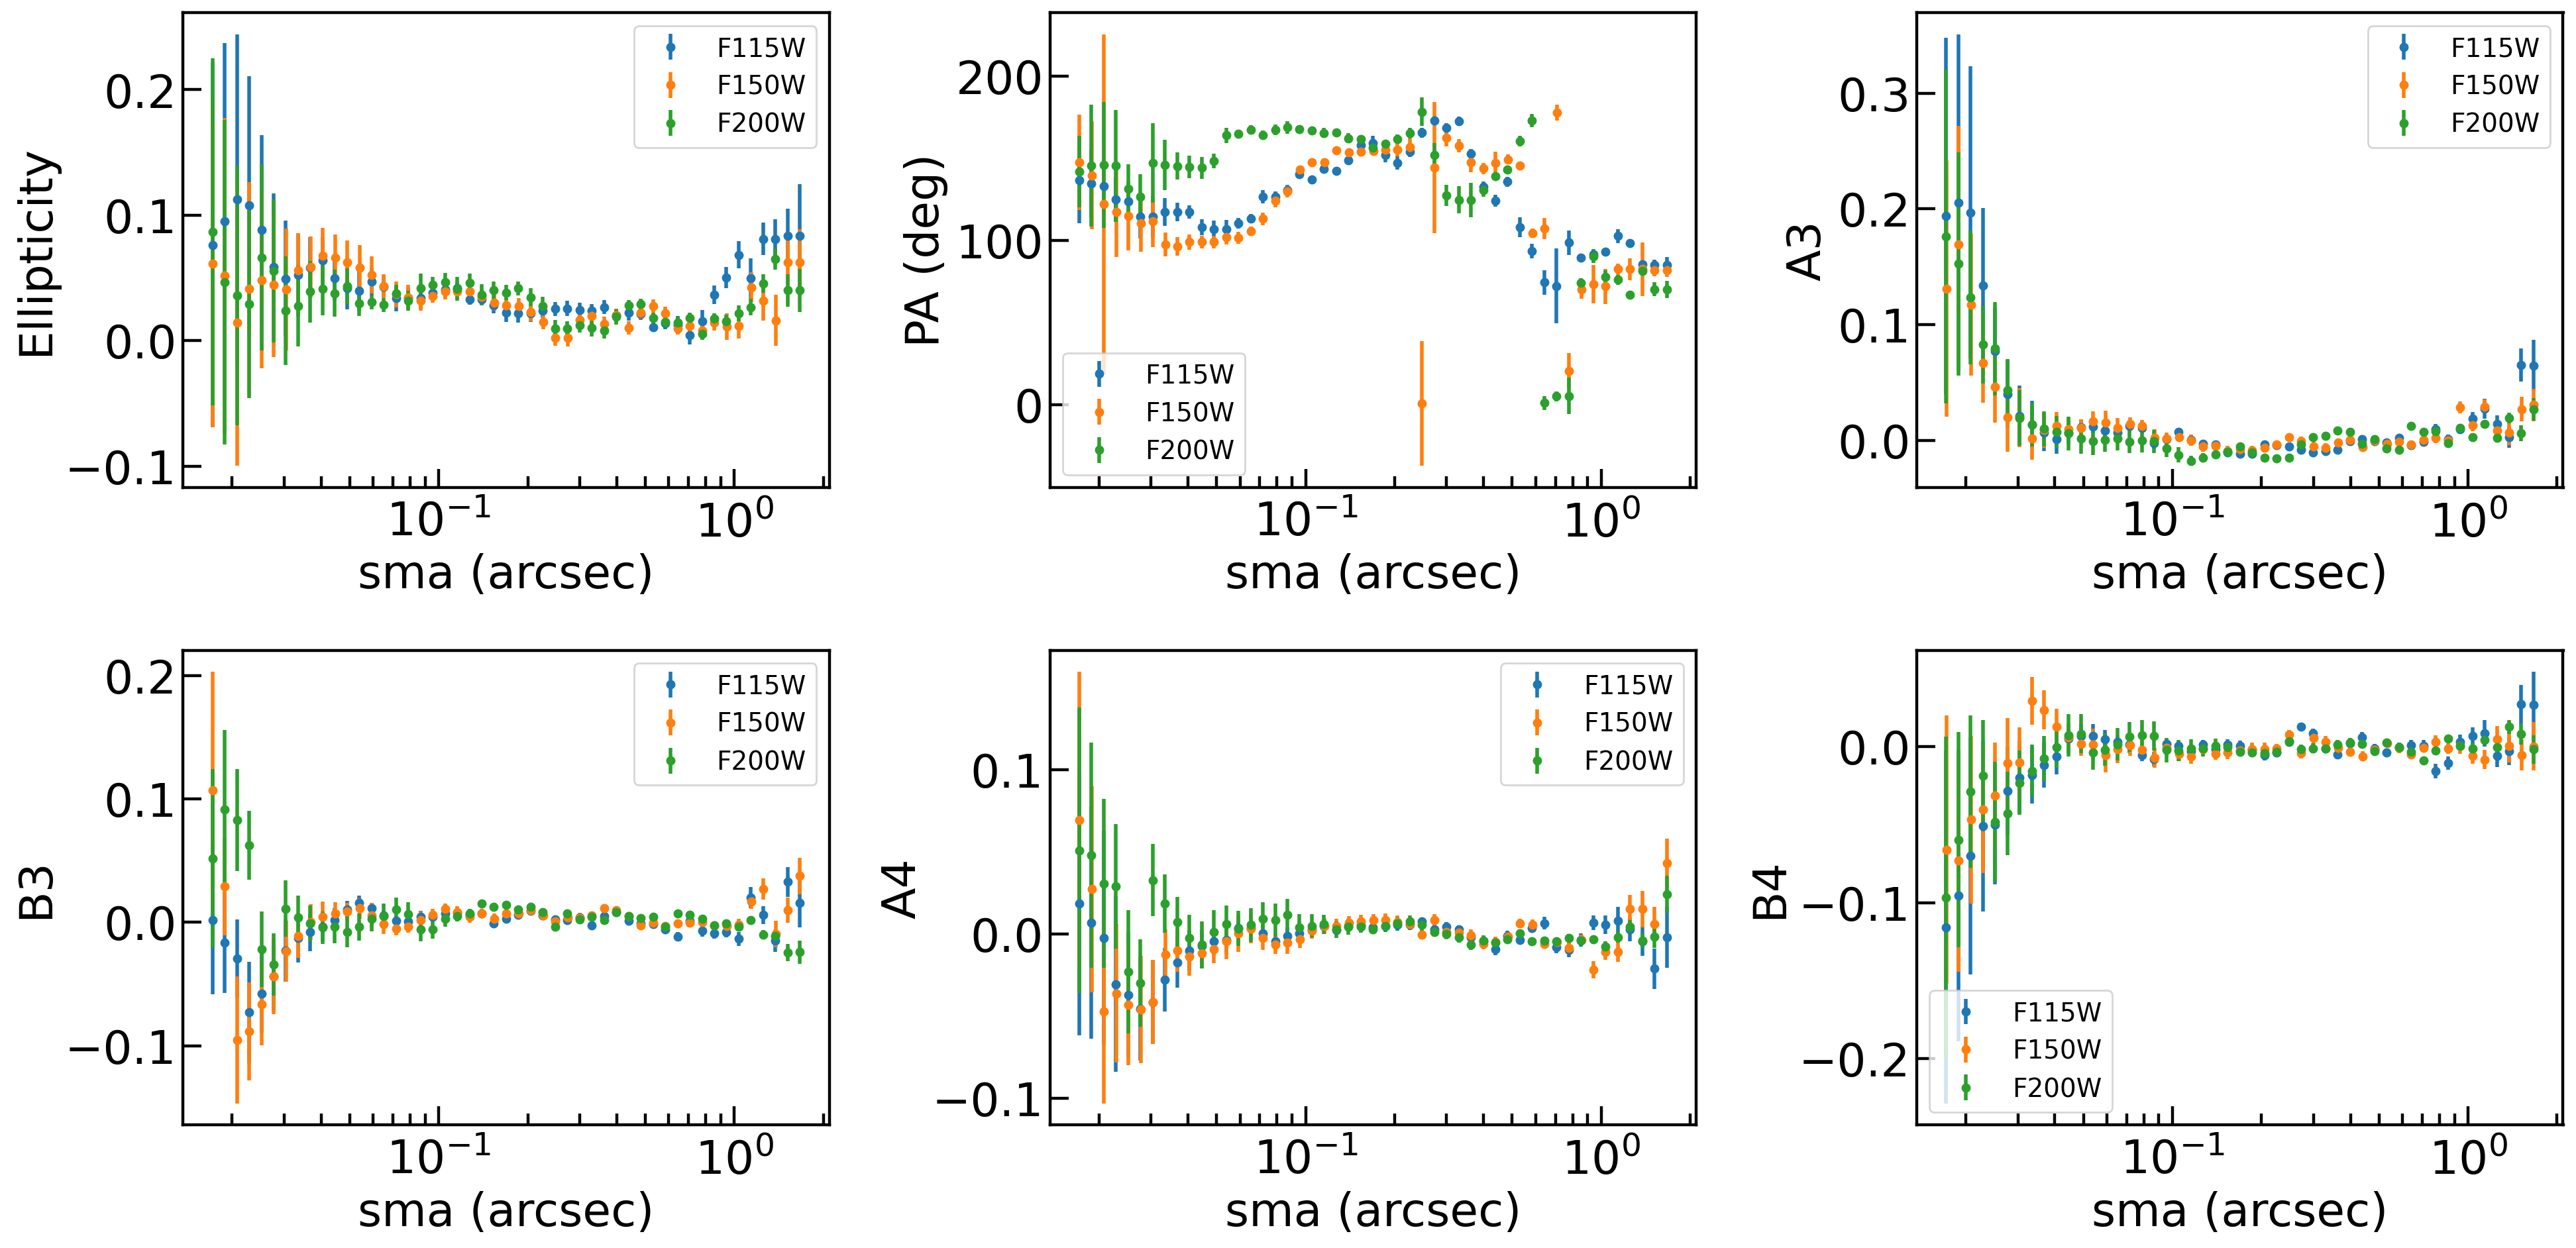

In [22]:
from astropy.visualization import ZScaleInterval
#cutoutnames, modnames, resnames
fig, axes = plt.subplots(2, 3, figsize = (20, 10))

for ii in range(len(modnames)):
    cutind = fits.open(cutoutnames[ii])[1].data
    modind = fits.open(modnames[ii])[1].data
    resind = fits.open(resnames[ii])[1].data
    isoind = isolist[ii]
    tabind = fittabs[ii]
 
   
    axes[0,0].errorbar(tabind['sma_arcsec'], isoind.eps, yerr=isoind.ellip_err, fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[0,0].set_xlabel('sma (arcsec)')
    axes[0,0].set_ylabel('Ellipticity')
    axes[0,0].set_xscale('log')
    axes[0,0].legend(fontsize=14)
    
    axes[0,1].errorbar(tabind['sma_arcsec'], isoind.pa/np.pi*180., yerr=isoind.pa_err/np.pi* 80., fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[0,1].set_xlabel('sma (arcsec)')
    axes[0,1].set_ylabel('PA (deg)')
    axes[0,1].set_xscale('log')
    axes[0,1].legend(fontsize=14)
    
    axes[0,2].errorbar(tabind['sma_arcsec'], isoind.a3, yerr=isoind.a3_err, fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[0,2].set_xlabel('sma (arcsec)')
    axes[0,2].set_ylabel('A3')
    axes[0,2].legend(fontsize=14)
    axes[0,2].set_xscale('log')
    
    axes[1,0].errorbar(tabind['sma_arcsec'], isoind.b3, yerr=isoind.b3_err, fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[1,0].set_xlabel('sma (arcsec)')
    axes[1,0].set_ylabel('B3')
    axes[1,0].legend(fontsize=14)
    axes[1,0].set_xscale('log')
    
    axes[1,1].errorbar(tabind['sma_arcsec'], isoind.a4, yerr=isoind.a4_err, fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[1,1].set_xlabel('sma (arcsec)')
    axes[1,1].set_ylabel('A4')
    axes[1,1].legend(fontsize=14)
    axes[1,1].set_xscale('log')
  
    axes[1,2].errorbar(tabind['sma_arcsec'], isoind.b4, yerr=isoind.b4_err, fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[1,2].set_xlabel('sma (arcsec)')
    axes[1,2].set_ylabel('B4')
    axes[1,2].legend(fontsize=14)
    axes[1,2].set_xscale('log')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)
plt.tight_layout()


watching true important figure Ellipiticity + PA

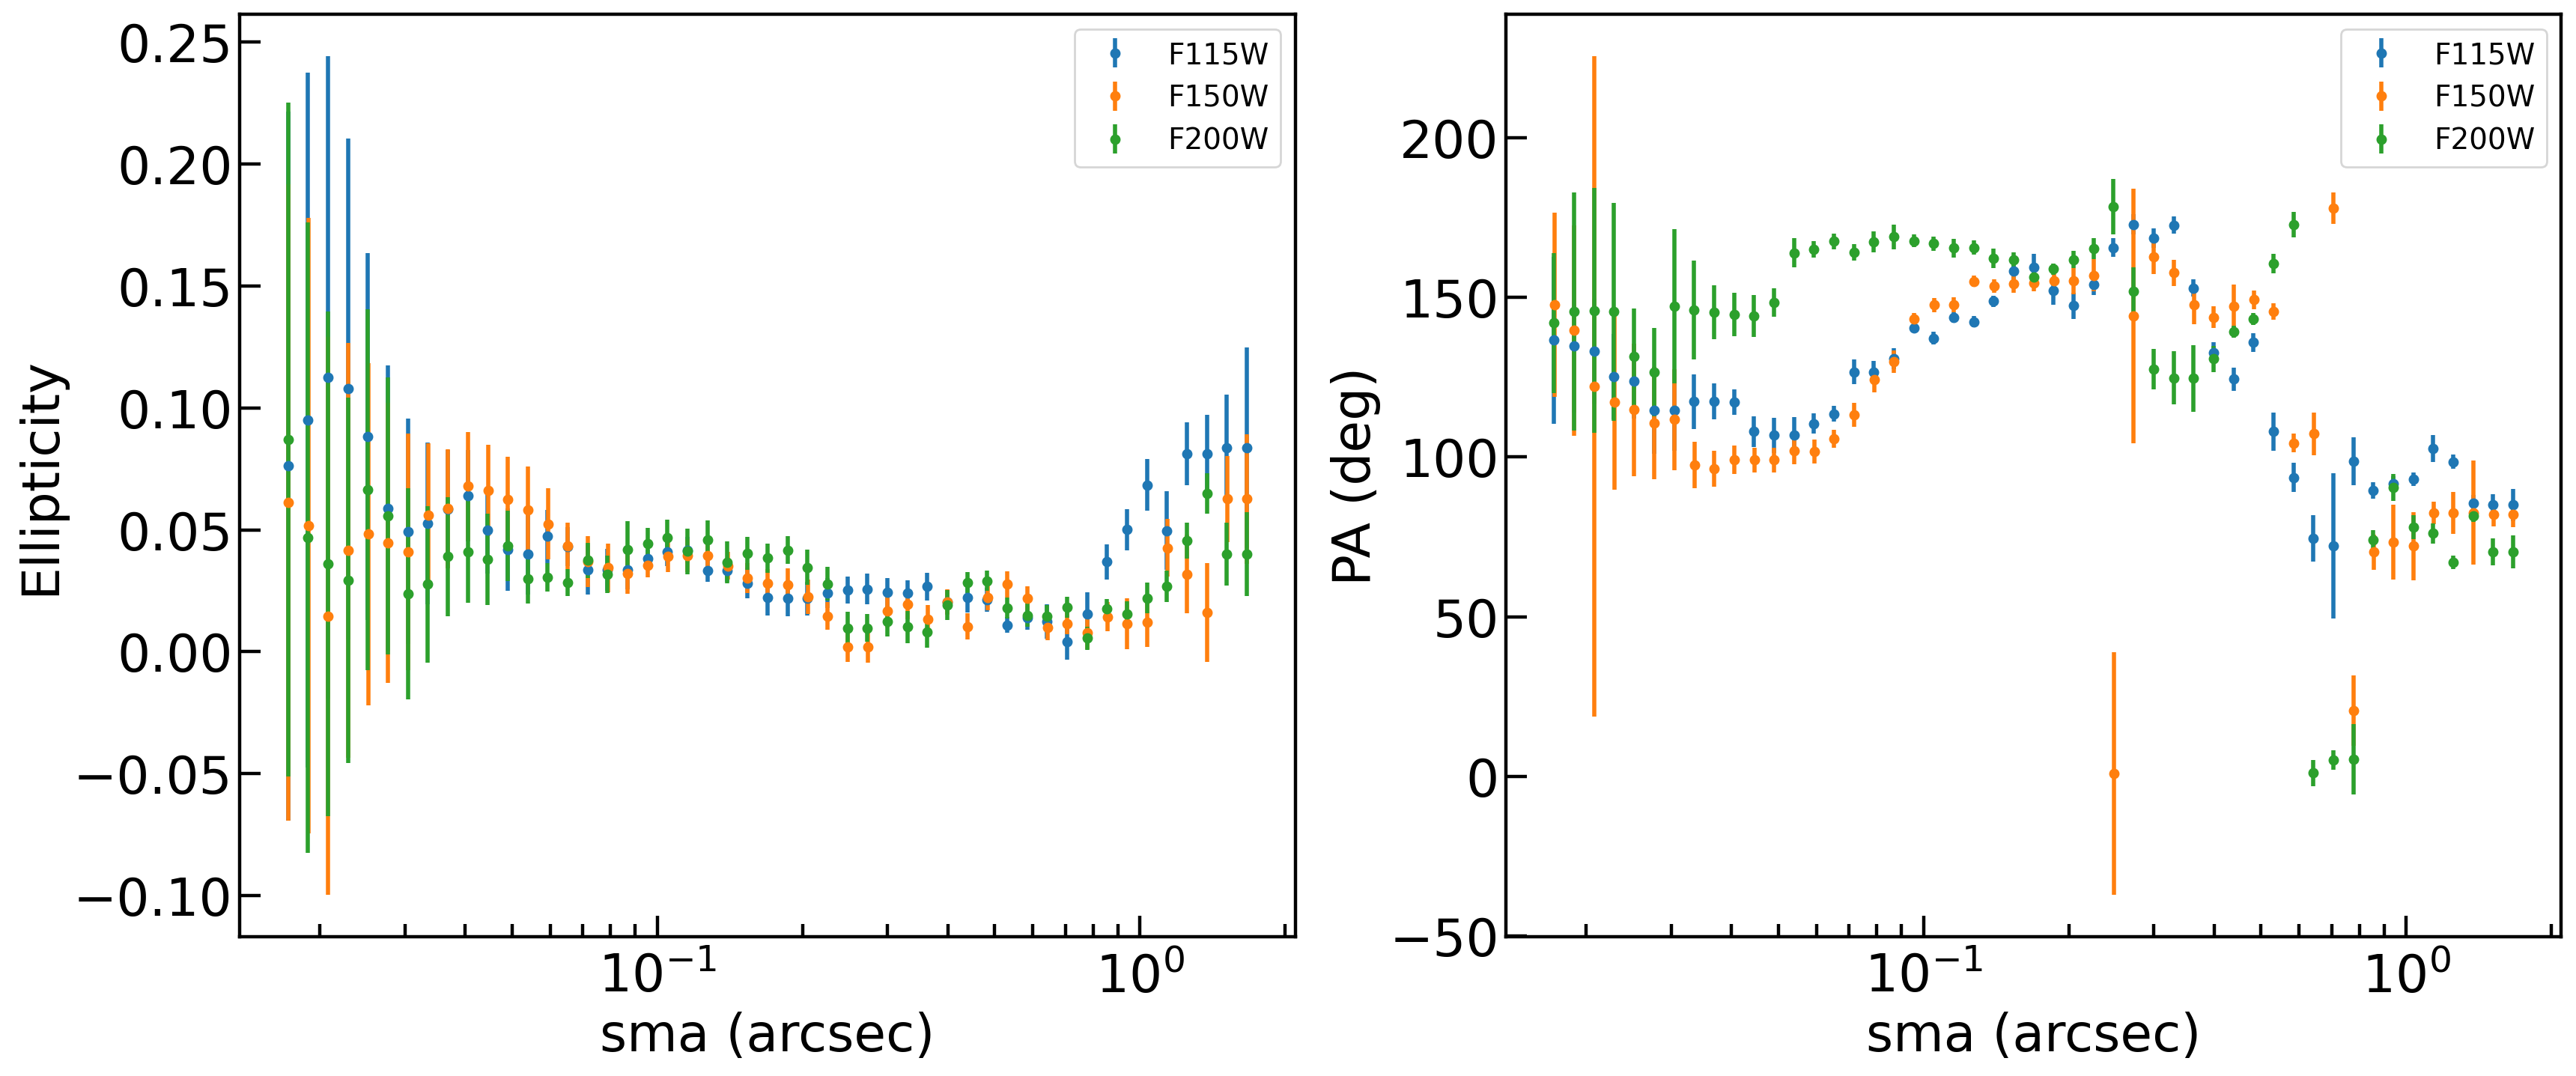

In [37]:
from astropy.visualization import ZScaleInterval
#cutoutnames, modnames, resnames
fig, axes = plt.subplots(1, 2, figsize = (20, 8))

for ii in range(len(modnames)):
    cutind = fits.open(cutoutnames[ii])[1].data
    modind = fits.open(modnames[ii])[1].data
    resind = fits.open(resnames[ii])[1].data
    isoind = isolist[ii]
    tabind = fittabs[ii]
 
   
    axes[0].errorbar(tabind['sma_arcsec'], isoind.eps, yerr=isoind.ellip_err, fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[0].set_xlabel('sma (arcsec)')
    axes[0].set_ylabel('Ellipticity')
    axes[0].set_xscale('log')
    axes[0].legend(fontsize=14)
    
    axes[1].errorbar(tabind['sma_arcsec'], isoind.pa/np.pi*180., yerr=isoind.pa_err/np.pi* 80., fmt='o', markersize=4, label=f'{filters[ii]}')
    axes[1].set_xlabel('sma (arcsec)')
    axes[1].set_ylabel('PA (deg)')
    axes[1].set_xscale('log')
    axes[1].legend(fontsize=14)

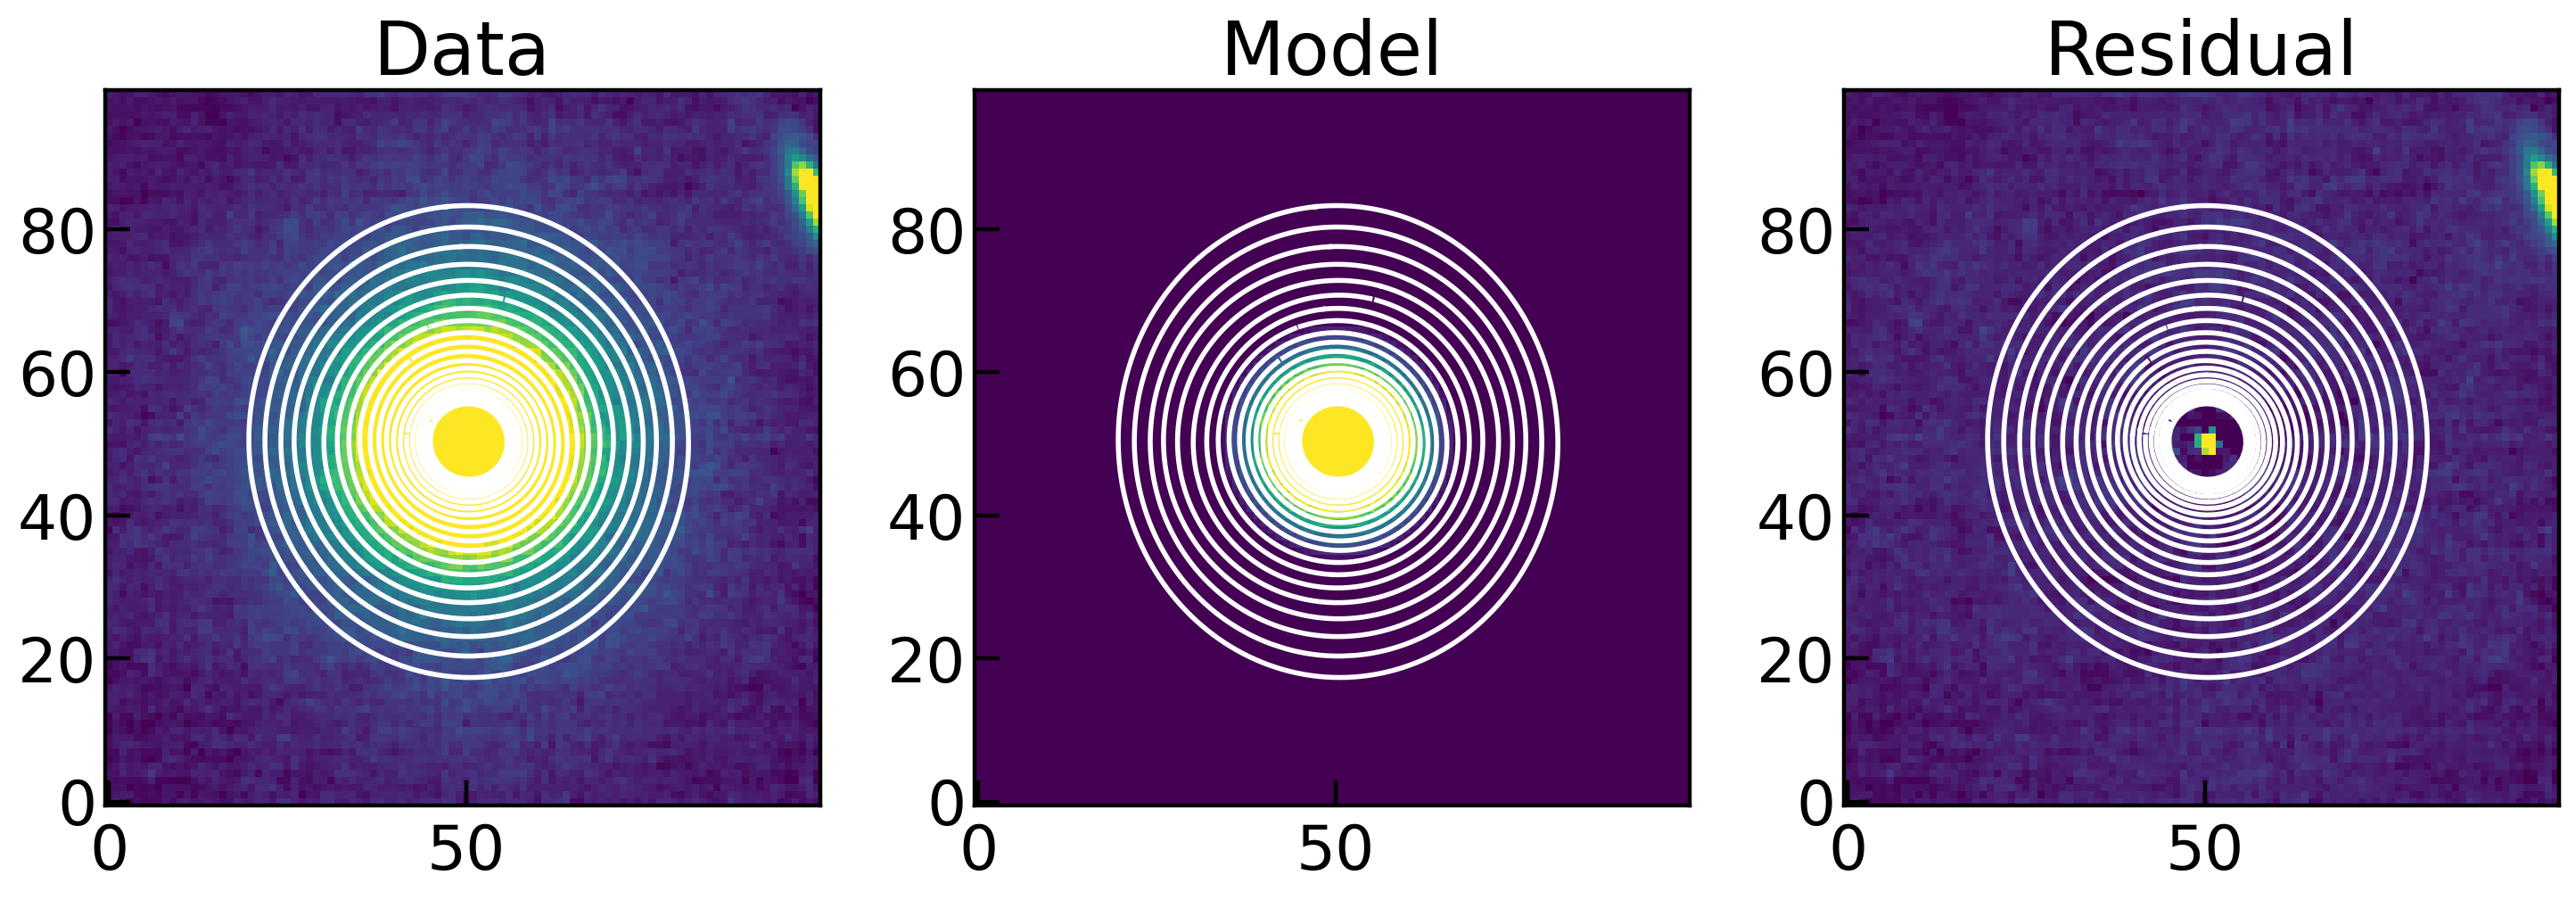

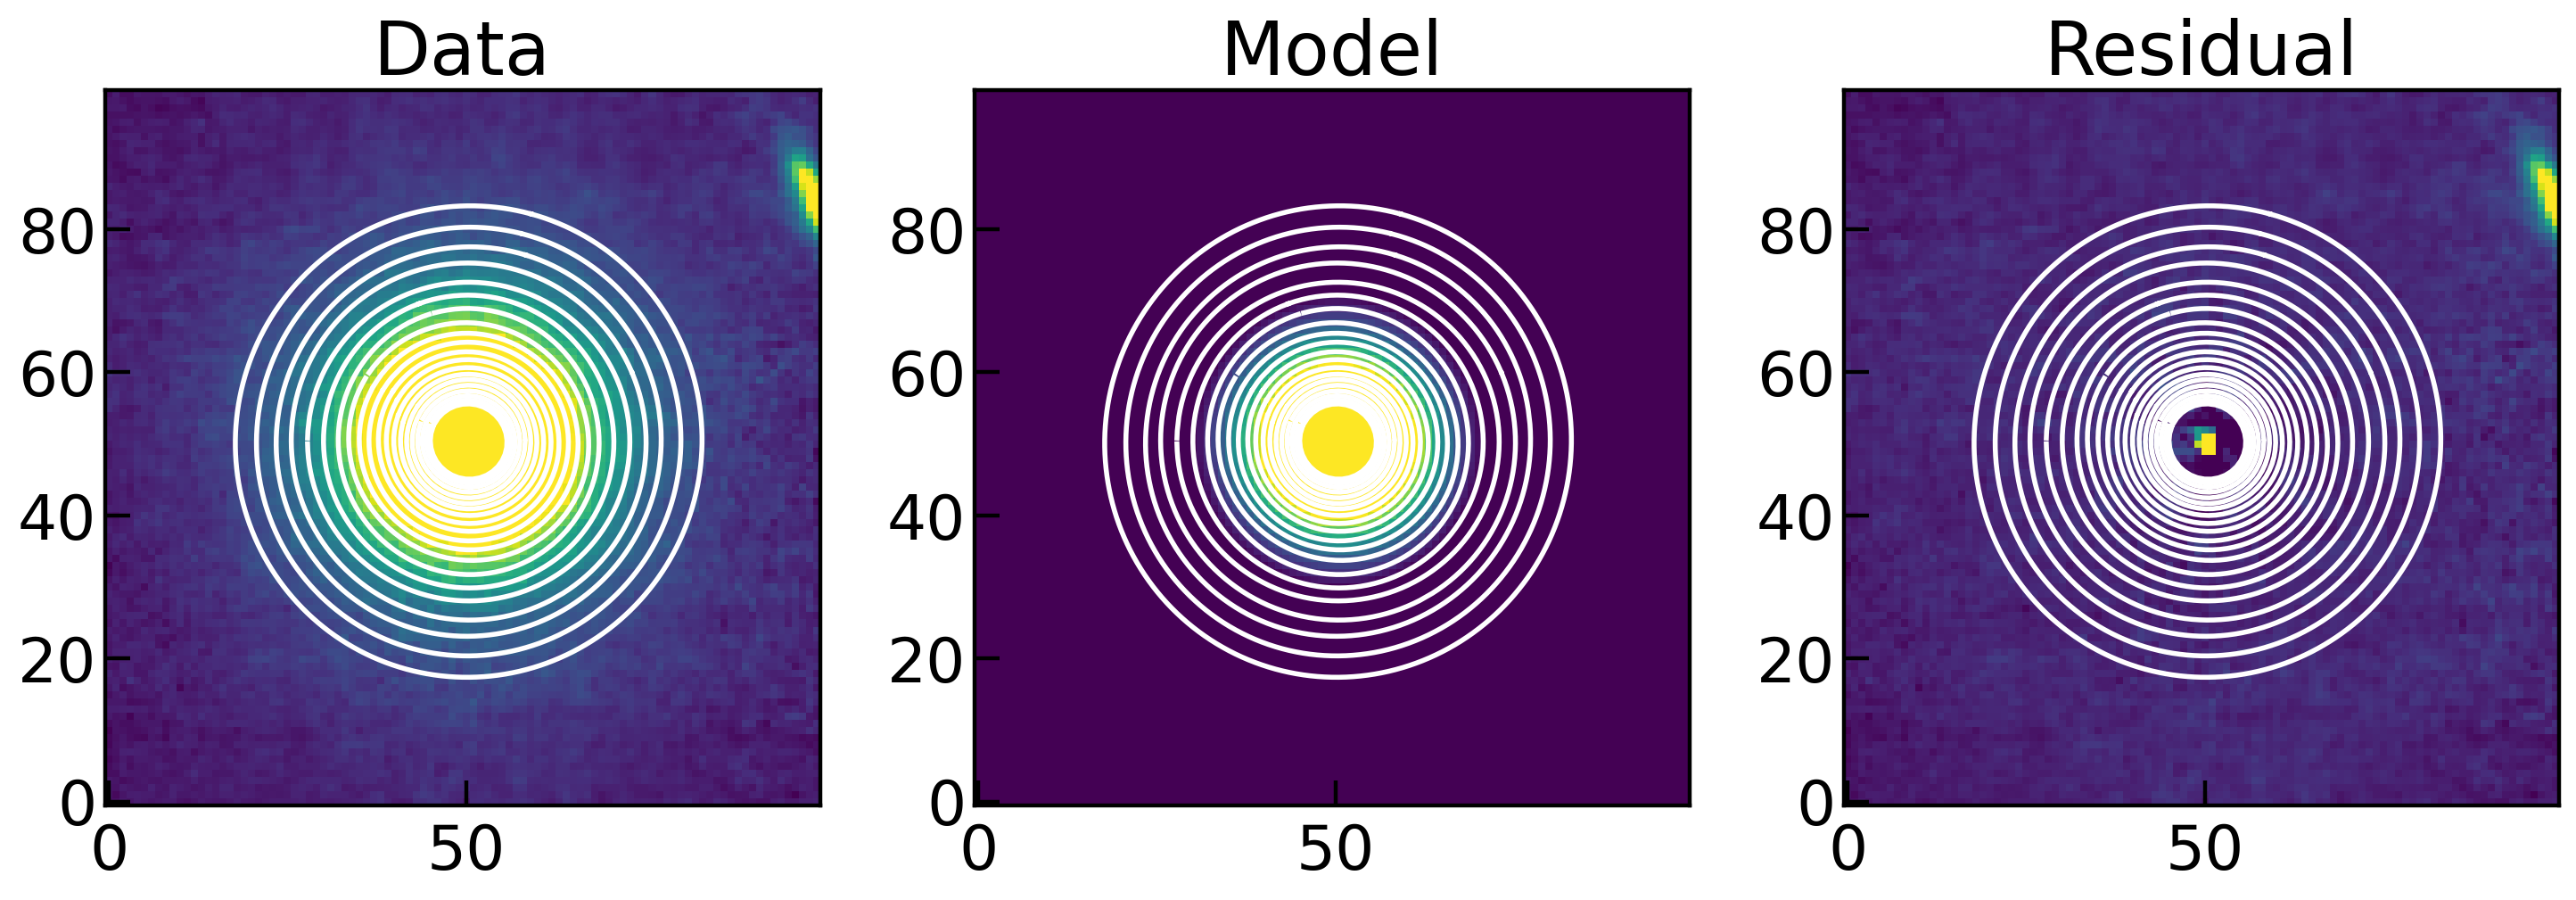

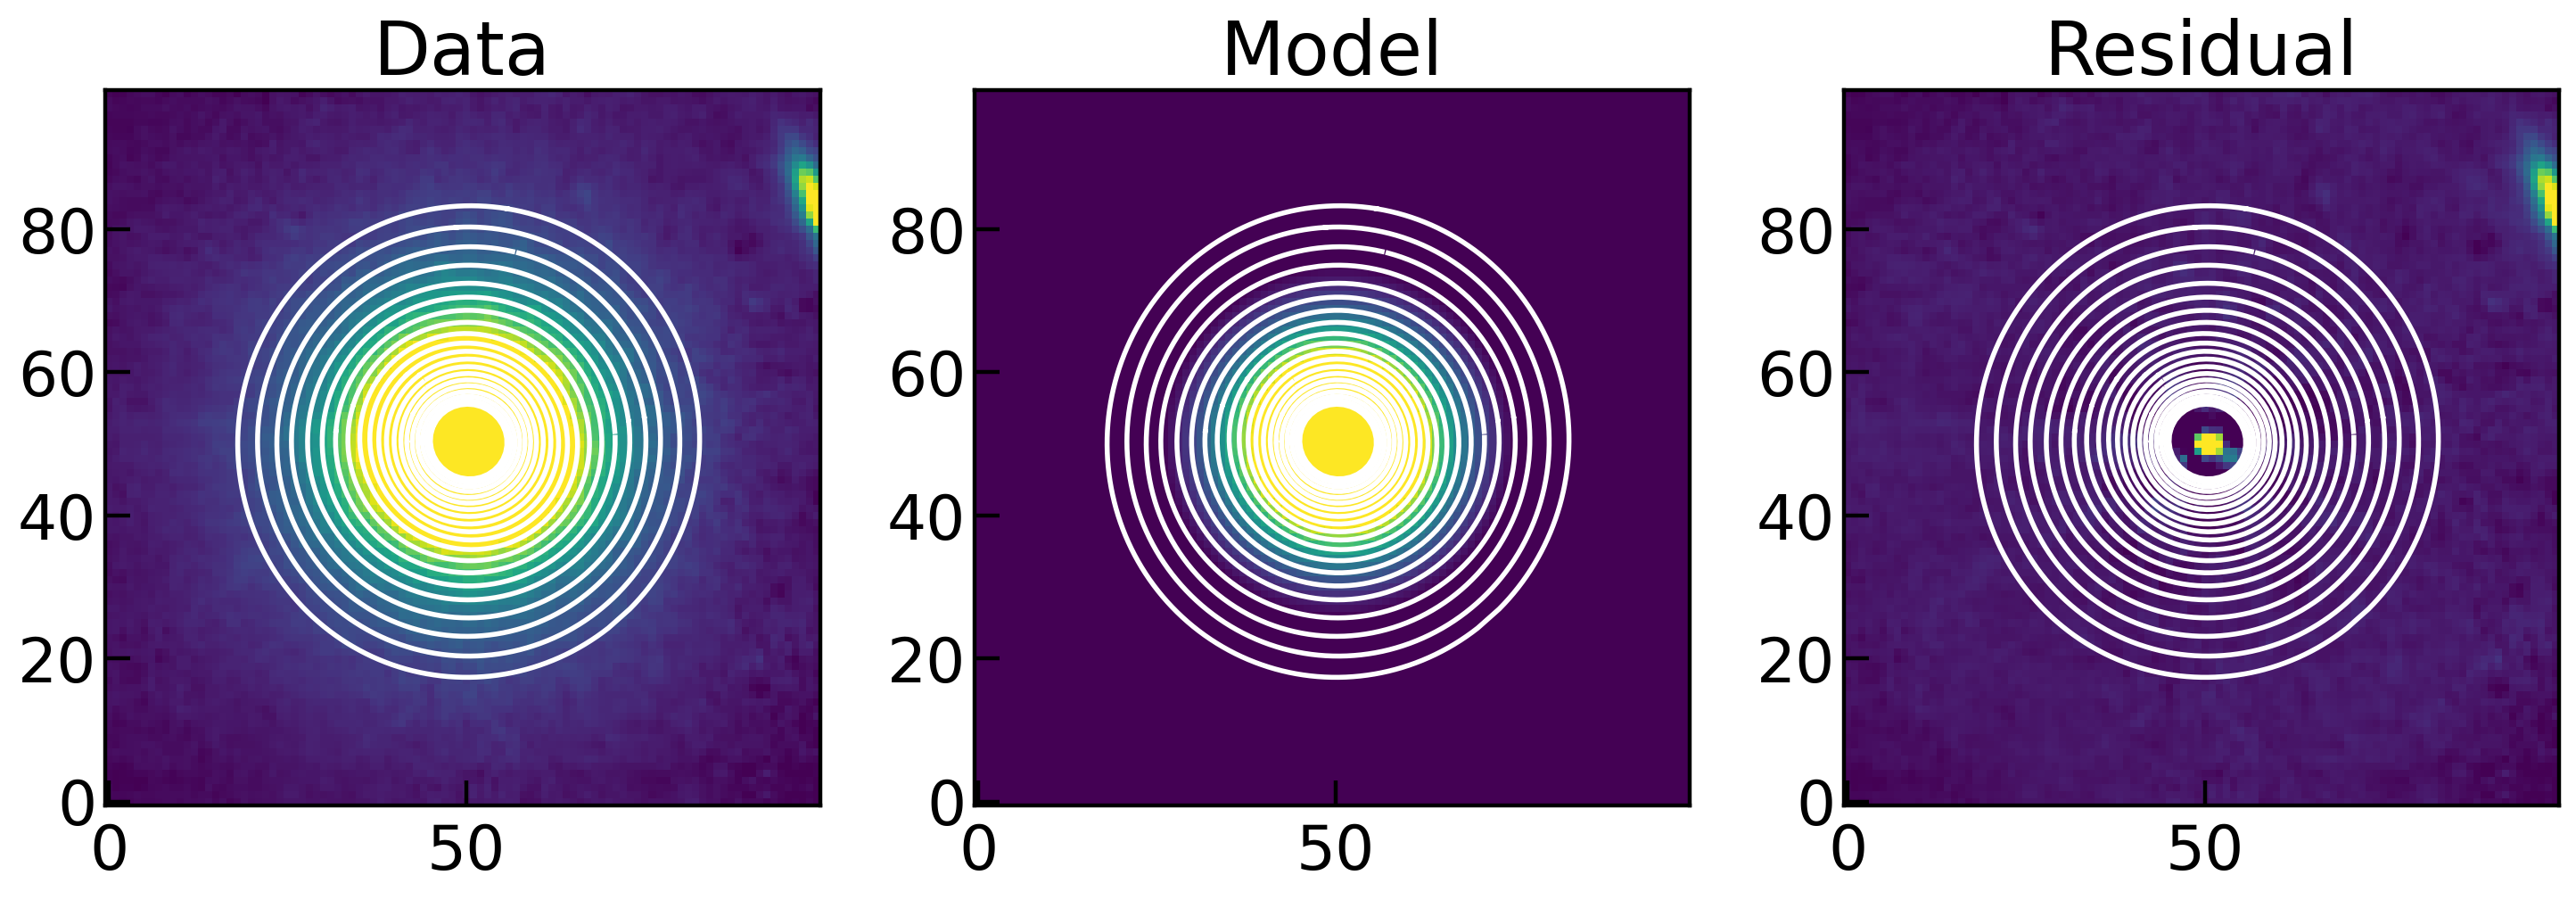

In [24]:
from astropy.visualization import ZScaleInterval
ZInterval = ZScaleInterval()
#cutoutnames, modnames, resnames
for ii in range(len(modnames)):
    cutind = fits.open(cutoutnames[ii])[1].data
    modind = fits.open(modnames[ii])[1].data
    resind = fits.open(resnames[ii])[1].data
    isoind = isolist[ii]

    ZInterval = ZScaleInterval()
    vmin, vmax = ZInterval.get_limits(cutind)
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))

    ax[0].imshow(cutind, vmin=vmin, vmax=vmax)
    ax[0].set_title("Data")
    ax[1].imshow(modind, vmin=vmin, vmax=vmax)
    ax[1].set_title("Model")
    ax[2].imshow(resind, vmin=vmin, vmax=vmax)
    ax[2].set_title("Residual")

    kkk = np.linspace(0.5, 0.9, 20)
    for i in range(np.size(kkk)):
        xd, yd = isoind.get_closest(np.quantile(isoind.sma, kkk[i])).sampled_coordinates()
        for j in range(np.size(ax)):
            ax[j].plot(xd, yd, color='white')

    plt.tight_layout()
    plt.show()
    plt.close()

Residual Plot Magnify

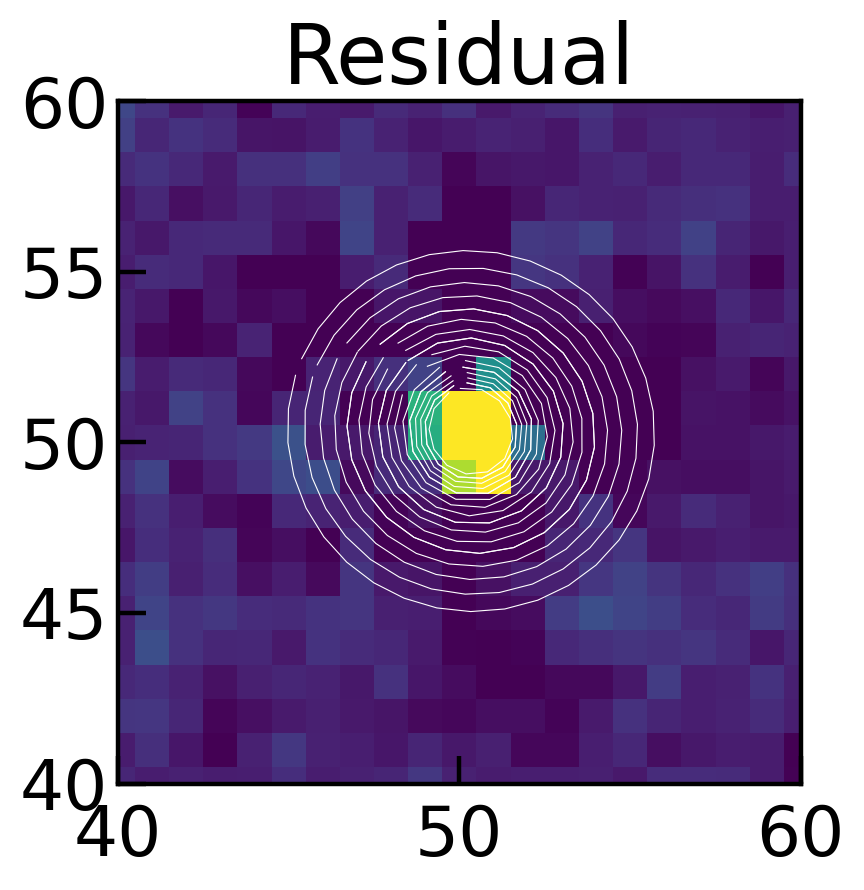

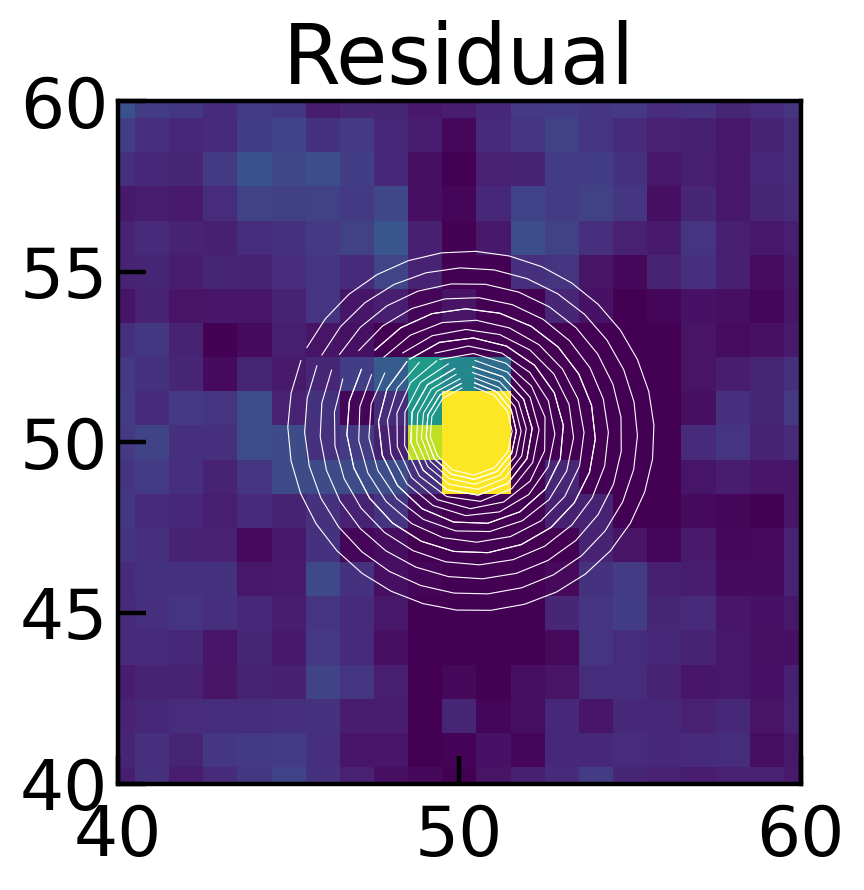

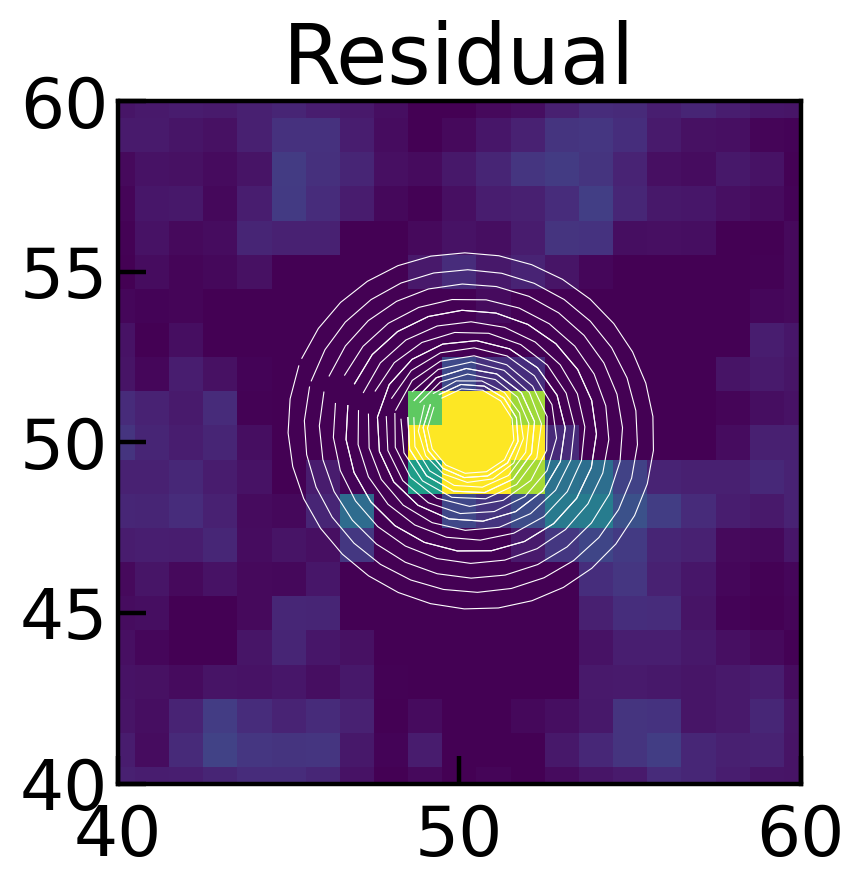

In [25]:
from astropy.visualization import ZScaleInterval
ZInterval = ZScaleInterval()
msz=10
#cutoutnames, modnames, resnames
for ii in range(len(modnames)):
    cutind = fits.open(cutoutnames[ii])[1].data
    modind = fits.open(modnames[ii])[1].data
    resind = fits.open(resnames[ii])[1].data
    isoind = isolist[ii]

    ZInterval = ZScaleInterval()
    vmin, vmax = ZInterval.get_limits(cutind)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(resind, vmin=vmin, vmax=vmax)
    ax.set_title("Residual")
    ax.set_xlim(np.shape(resind)[0]/2-msz, np.shape(resind)[1]/2+msz)
    ax.set_ylim(np.shape(resind)[0]/2-msz, np.shape(resind)[1]/2+msz)
    
    kkk = np.linspace(0.2, 0.5, 20)
    for i in range(np.size(kkk)):
        xd, yd = isoind.get_closest(np.quantile(isoind.sma, kkk[i])).sampled_coordinates()
        ax.plot(xd, yd, color='white', lw=0.4)

    plt.tight_layout()
    plt.show()
    plt.close()

## Mag Difference

In [27]:
filters

['F115W', 'F150W', 'F200W']

In [28]:
isolist

In [29]:
from scipy.interpolate import interp1d
#cutoutnames, modnames, resnames
F115W_mag = -2.5*np.log10(isolist[0].intens)
F150W_mag = -2.5*np.log10(isolist[1].intens)
F200W_mag = -2.5*np.log10(isolist[2].intens)

F115W_sma = isolist[0].sma
F150W_sma = isolist[1].sma
F200W_sma = isolist[2].sma

/tmp/ipykernel_26143/2528961399.py:3: RuntimeWarning: invalid value encountered in log10
  F115W_mag = -2.5*np.log10(isolist[0].intens)
/tmp/ipykernel_26143/2528961399.py:4: RuntimeWarning: invalid value encountered in log10
  F150W_mag = -2.5*np.log10(isolist[1].intens)
/tmp/ipykernel_26143/2528961399.py:5: RuntimeWarning: invalid value encountered in log10
  F200W_mag = -2.5*np.log10(isolist[2].intens)


In [30]:
inter115 = interp1d(F115W_sma, F115W_mag)
inter150 = interp1d(F150W_sma, F150W_mag)
inter200 = interp1d(F200W_sma, F200W_mag)

In [31]:
resasm115 = inter115(F200W_sma[2:-2])
resasm150 = inter150(F200W_sma[2:-2])

resasm115_2 = inter115(F150W_sma[2:-2])

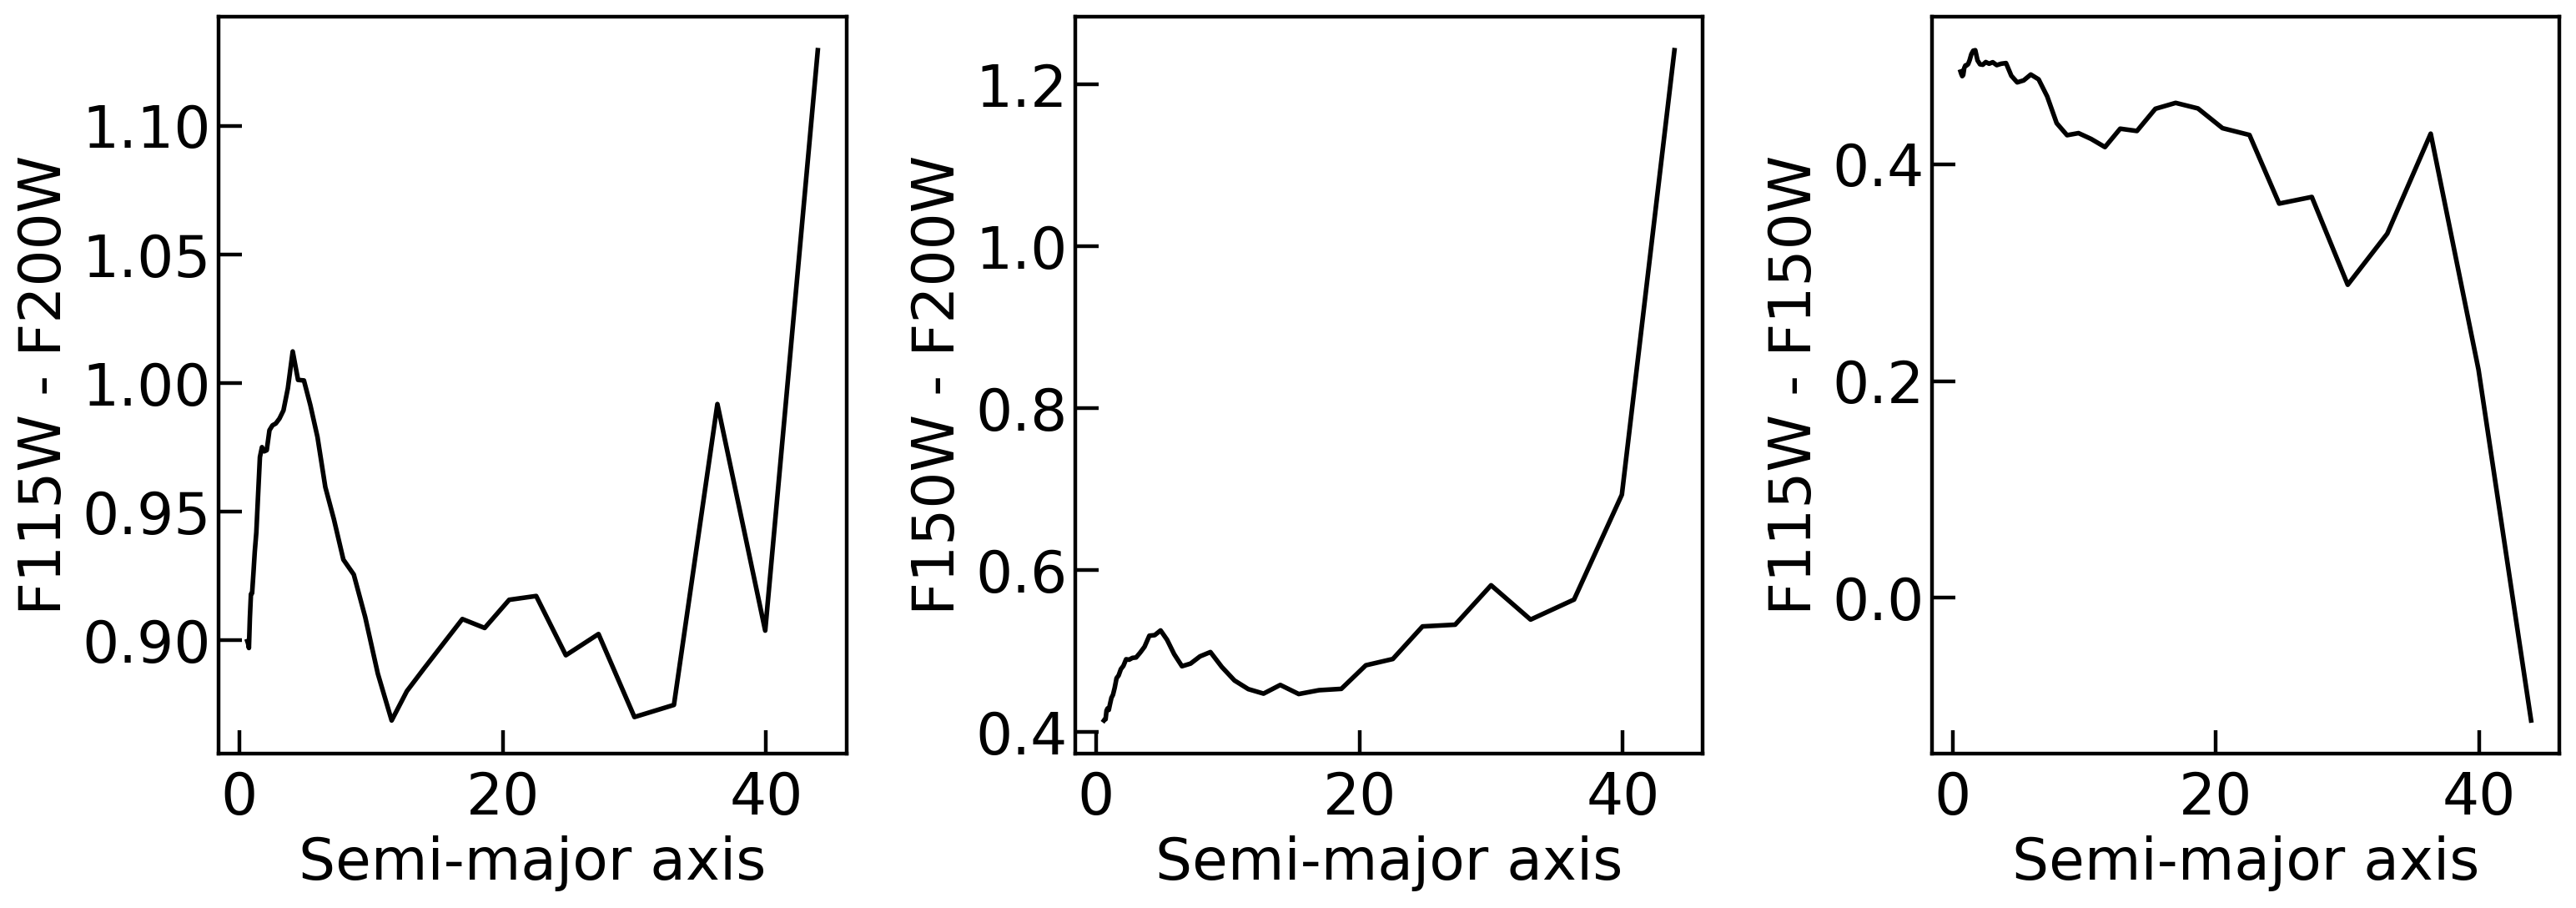

In [32]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
ax[0].plot(F200W_sma[2:-2], resasm115 - F200W_mag[2:-2], color = 'black')
ax[0].set_xlabel('Semi-major axis')
ax[0].set_ylabel('F115W - F200W')
ax[1].plot(F200W_sma[2:-2], resasm150 - F200W_mag[2:-2], color = 'black')
ax[1].set_xlabel('Semi-major axis')
ax[1].set_ylabel('F150W - F200W')
ax[2].plot(F150W_sma[2:-2], resasm115_2 - F150W_mag[2:-2], color = 'black')
ax[2].set_xlabel('Semi-major axis')
ax[2].set_ylabel('F115W - F150W')
plt.tight_layout()

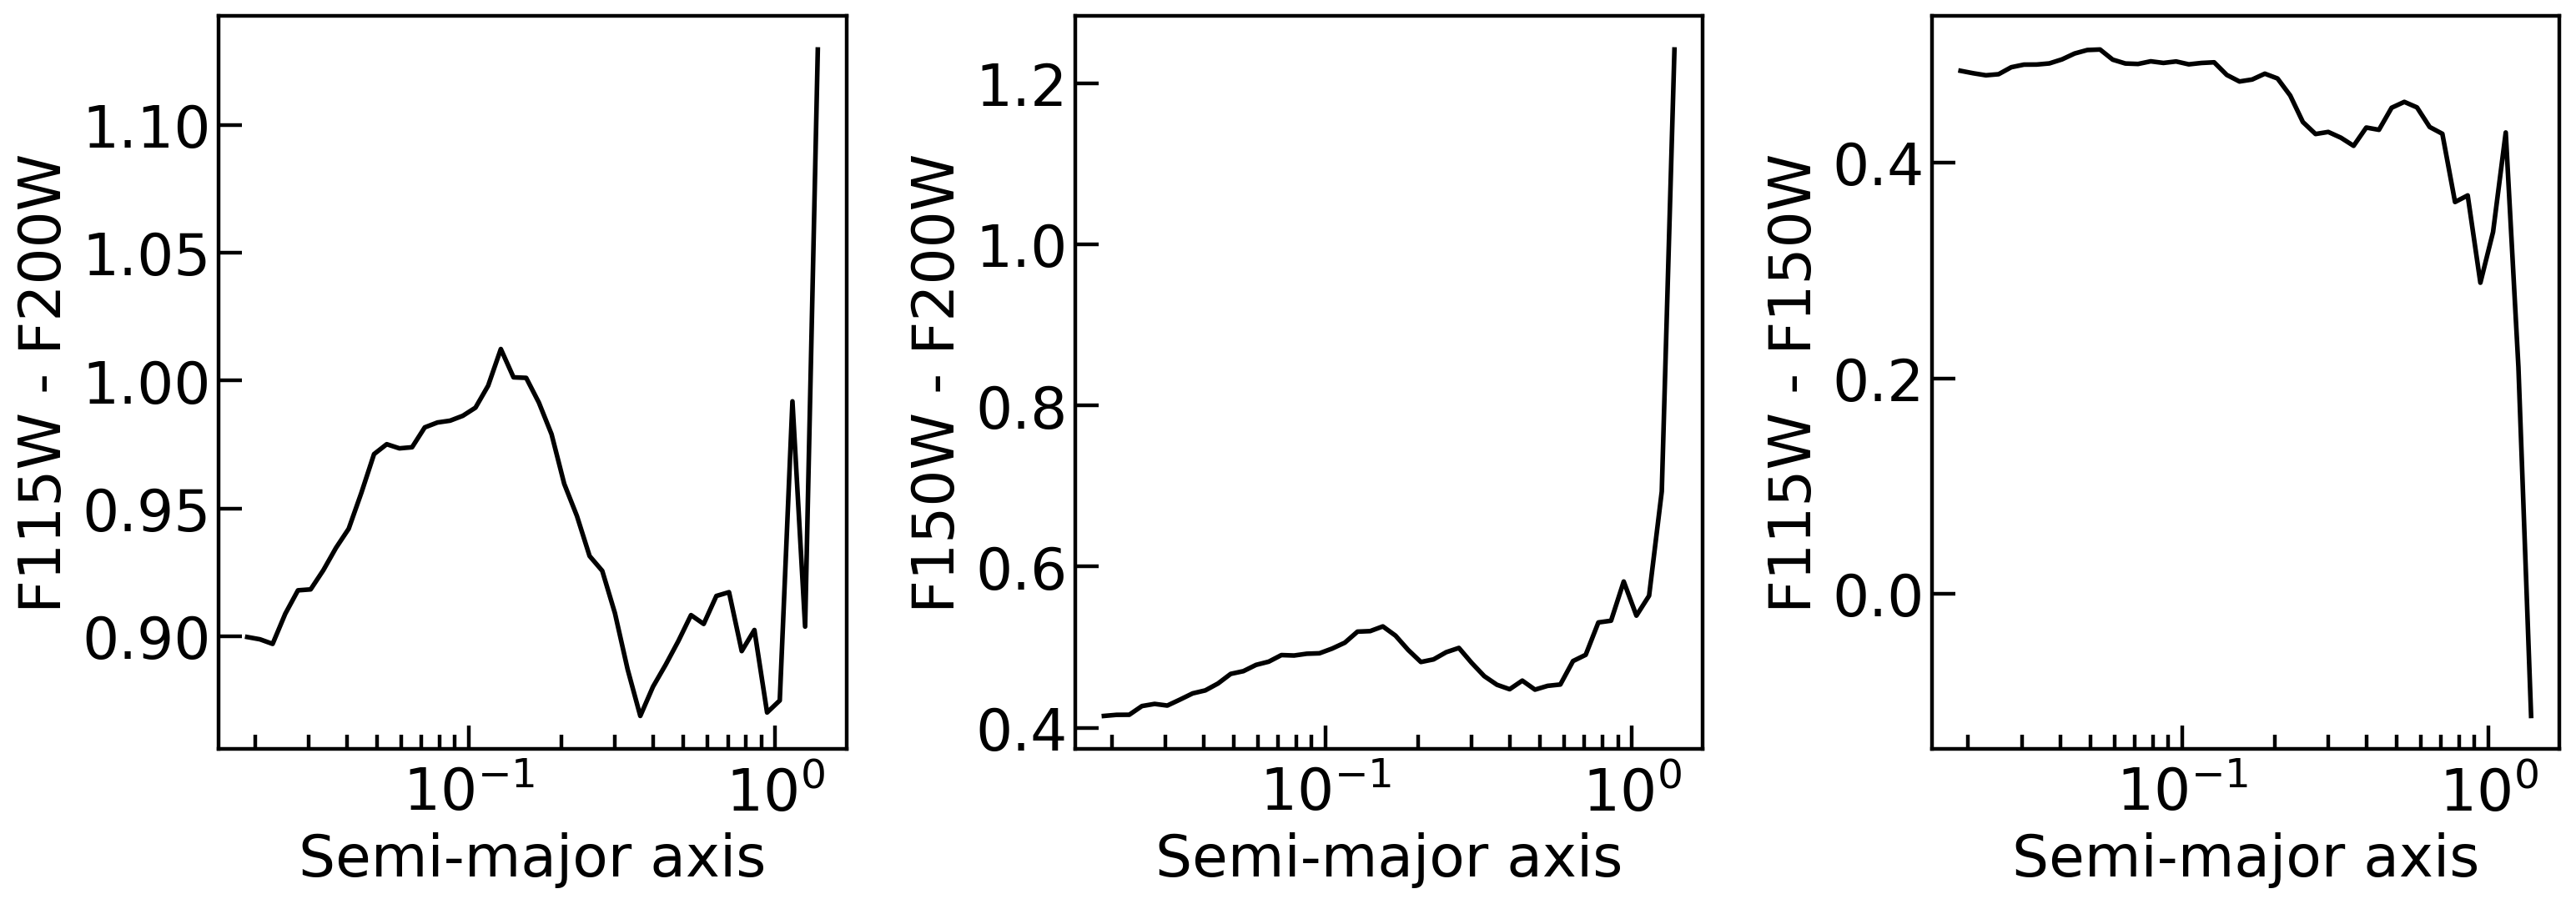

In [33]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
ax[0].plot(F200W_sma[2:-2]*pixel_scale[0], resasm115 - F200W_mag[2:-2], color = 'black')
ax[0].set_xlabel('Semi-major axis')
ax[0].set_ylabel('F115W - F200W')
ax[0].set_xscale('log')
ax[1].plot(F200W_sma[2:-2]*pixel_scale[0], resasm150 - F200W_mag[2:-2], color = 'black')
ax[1].set_xlabel('Semi-major axis')
ax[1].set_ylabel('F150W - F200W')
ax[1].set_xscale('log')
ax[2].plot(F150W_sma[2:-2]*pixel_scale[0], resasm115_2 - F150W_mag[2:-2], color = 'black')
ax[2].set_xlabel('Semi-major axis')
ax[2].set_ylabel('F115W - F150W')
ax[2].set_xscale('log')

plt.tight_layout()

In [34]:
def sersic(r, n, Ie, re):
    bn = (2*n) - 1/3 + 4/(305*n)
    res = Ie*np.exp(-bn * (((r/re)**(1/n)) - 1))
    return res

sersic fitting

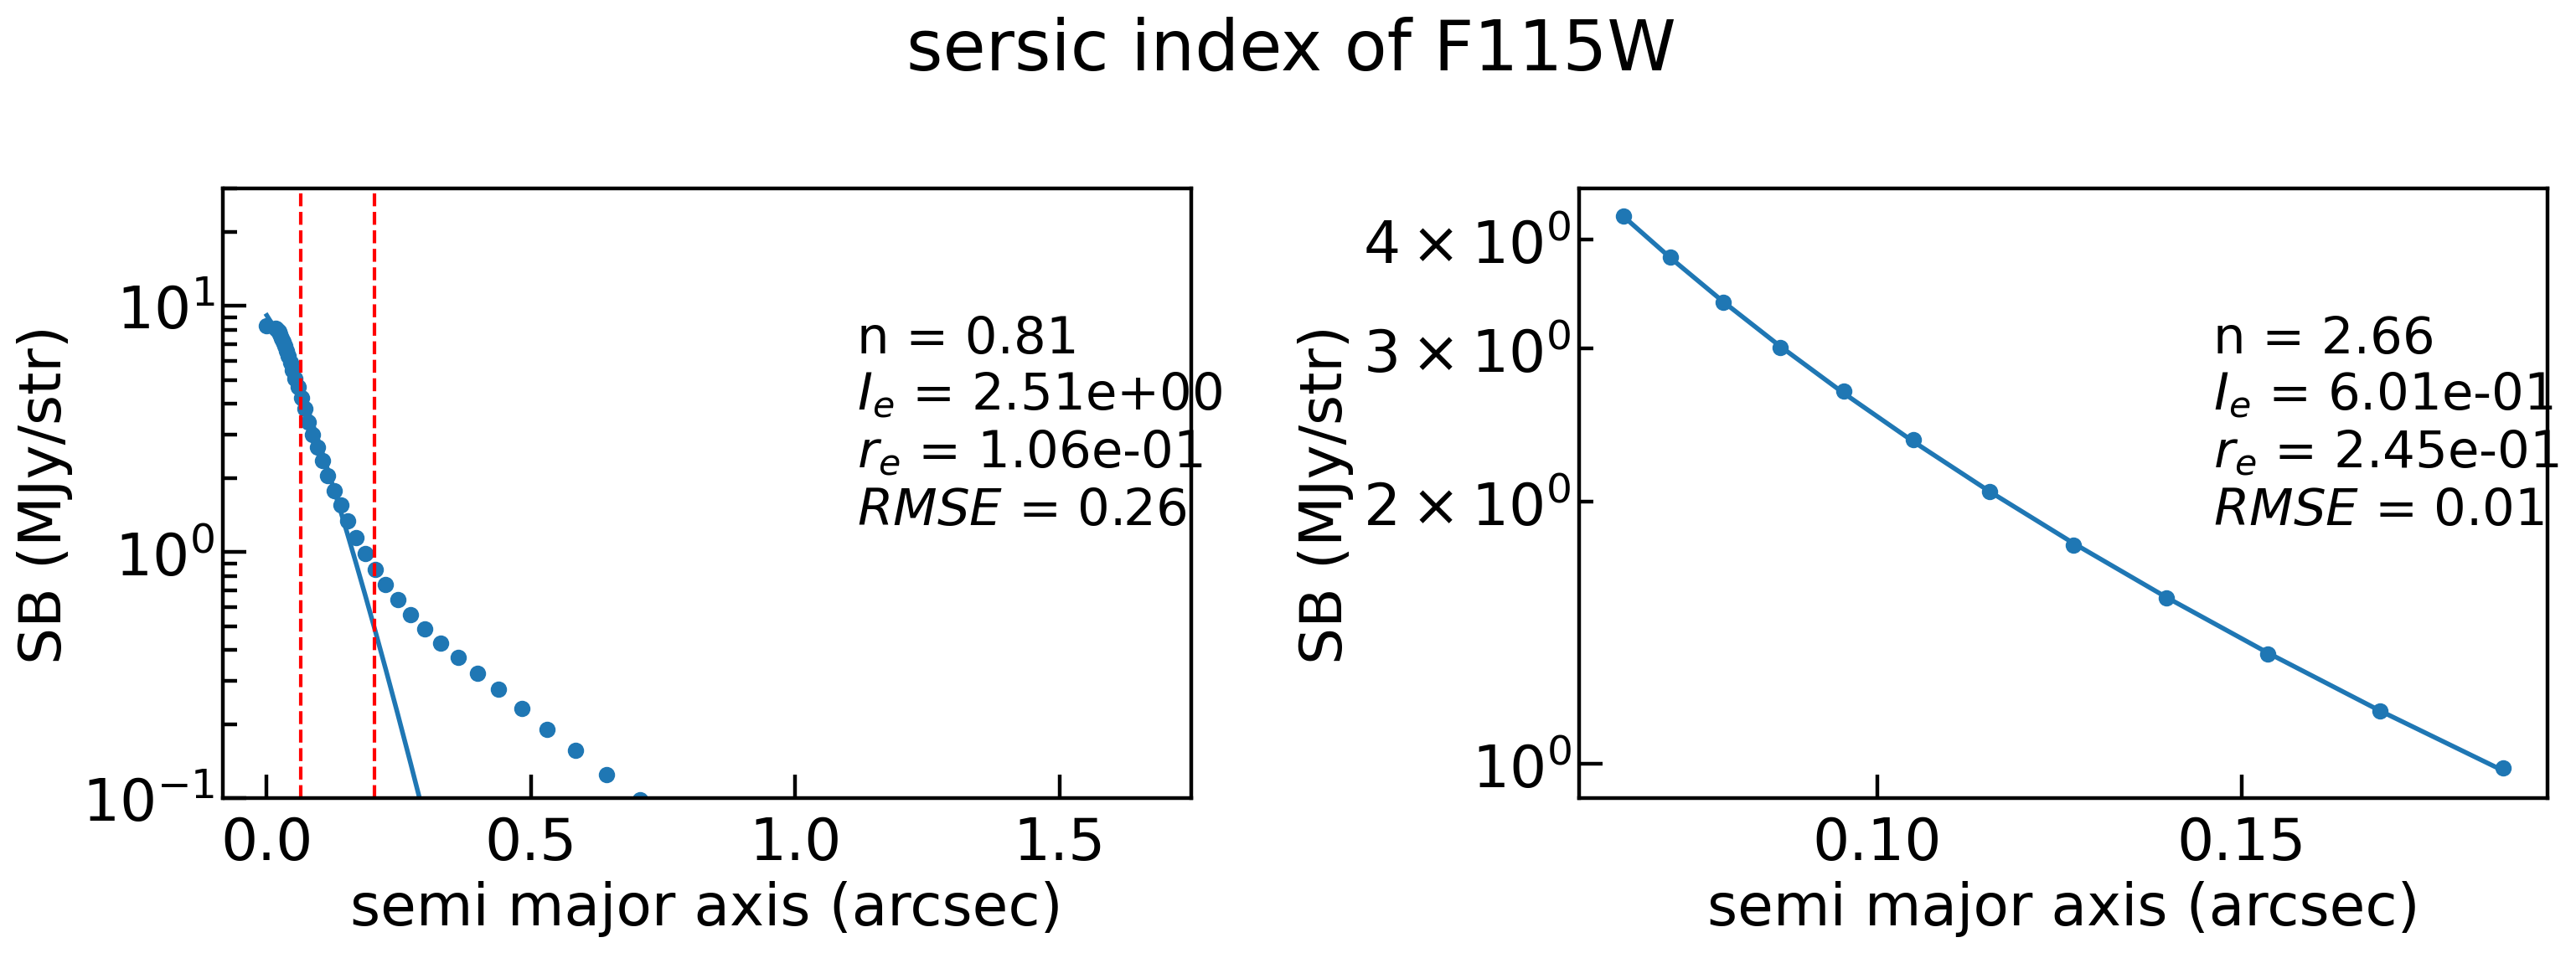

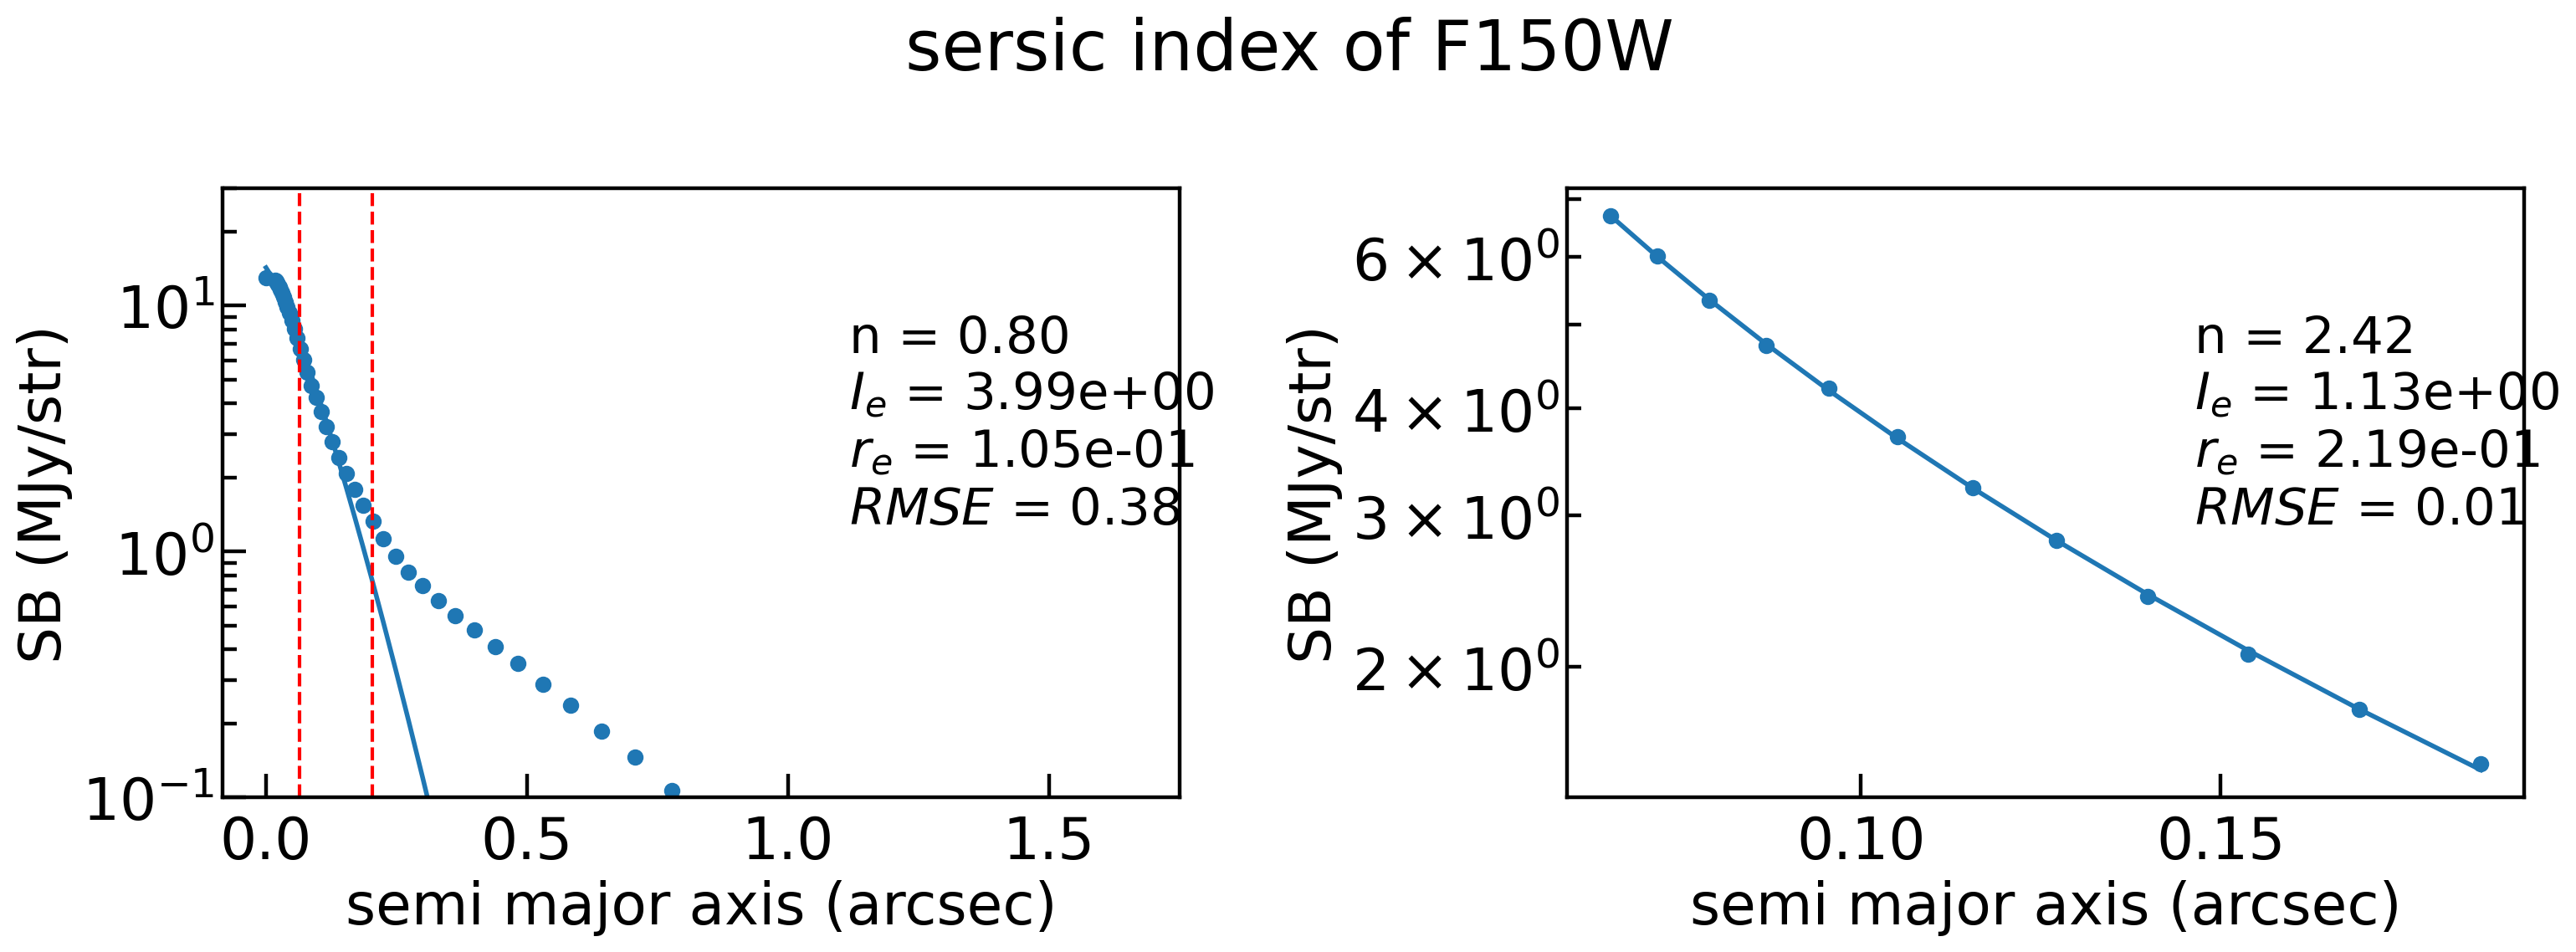

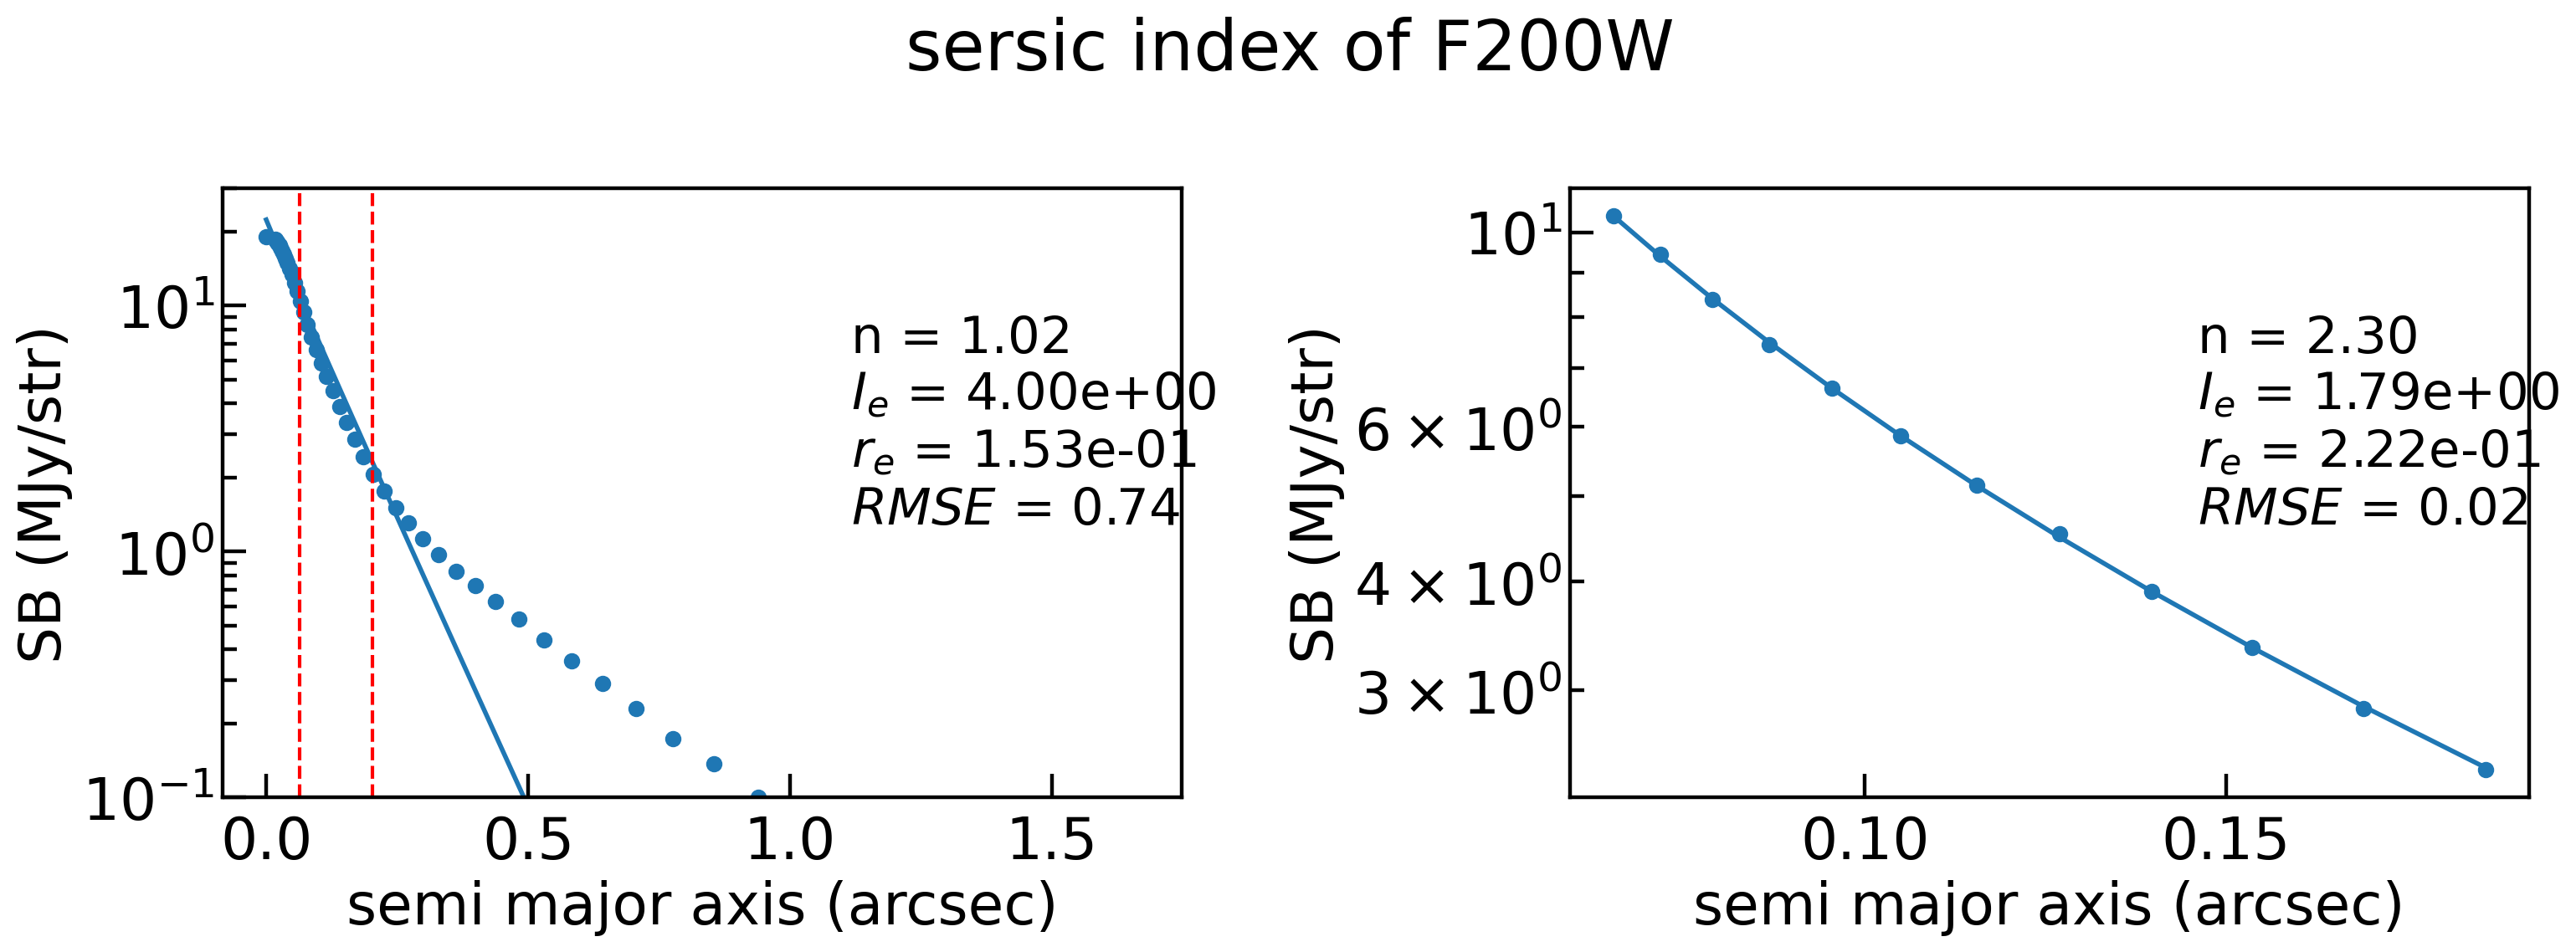

In [35]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
maxfev= 20000
lower = 0.3
upper = 0.55
p0 = [3, 1, 0.5]
bounds = ((0.5, 0, 0), (10, 4, 5.5))


for ii in range(len(filters)):    
    fittab = fittabs[ii]
    fittab_edit = fittab
    fittab_edit = fittab_edit[fittab_edit['sma_arcsec']>np.quantile(fittab['sma_arcsec'], lower)]
    fittab_edit = fittab_edit[fittab_edit['sma_arcsec']<np.quantile(fittab['sma_arcsec'], upper)]  
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'sersic index of {filters[ii]}')
    9
    popt, pcov = curve_fit(sersic, fittab['sma_arcsec'], fittab['intens'], p0=p0, maxfev=maxfev, bounds=bounds)
    axs[0].plot(fittab['sma_arcsec'], sersic(fittab['sma_arcsec'], *popt))
    axs[0].scatter(fittab['sma_arcsec'], (fittab['intens']))
    # axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].annotate('n = {:.2f}\n$I_e$ = {:.2e}\n$r_e$ = {:.2e}\n$RMSE$ = {:.2f}'.format(popt[0], popt[1], popt[2], mean_squared_error(sersic(fittab['sma_arcsec'], *popt), (fittab['intens']), squared=False)), (0.655, 0.45), xycoords = 'axes fraction', fontsize = 22)
    axs[0].set_xlabel('semi major axis (arcsec)')
    axs[0].set_ylabel('SB (MJy/str)')
    axs[0].set_ylim([0.1,30])
    axs[0].axvline(np.quantile(fittab['sma_arcsec'], lower), ls="--", lw=1.5, color='red')
    axs[0].axvline(np.quantile(fittab['sma_arcsec'], upper), ls="--", lw=1.5, color='red')

    popt, pcov = curve_fit(sersic, fittab_edit['sma_arcsec'], fittab_edit['intens'], p0=p0, maxfev=maxfev, bounds=bounds)
    axs[1].plot(fittab_edit['sma_arcsec'], sersic(fittab_edit['sma_arcsec'], *popt))
    axs[1].scatter(fittab_edit['sma_arcsec'], (fittab_edit['intens']))
    # axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].annotate('n = {:.2f}\n$I_e$ = {:.2e}\n$r_e$ = {:.2e}\n$RMSE$ = {:.2f}'.format(popt[0], popt[1], popt[2], mean_squared_error(sersic(fittab_edit['sma_arcsec'], *popt), (fittab_edit['intens']), squared=False)), (0.655, 0.45), xycoords = 'axes fraction', fontsize = 22)
    axs[1].set_xlabel('semi major axis (arcsec)')
    axs[1].set_ylabel('SB (MJy/str)')

    plt.tight_layout()